# 요약
1. 데이터 병합 : 날짜(base_date), 읍면동(emd_nm), 6개지역(region) 기준으로 병합

2. 결측값 처리 : 병합으로 생겨난 결측값 수정

3. 음식물 쓰레기 버린 횟수(em_cnt) 범주화

4. 연도/월 범주형 변수 생성

5. 제주 전체 지역 모델링

6. 제주 4구역 모델링

In [ ]:
# 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import math

plt.rc('font', family='NanumBarunGothic')
pd.set_option('display.max_row', 100)

In [ ]:
# 회귀분석 라이브러리
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# xgboost 라이브러리
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# 의사결정나무 라이브러리
import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. 데이터 병합

In [ ]:
# '음식물쓰레기' 데이터 로드
data1 = pd.read_csv('/content/drive/MyDrive/21 세미프로젝트_2차 (1)/코드_유진/음식물쓰레기_지역살림_합계용_nan처리_2년치제거.csv', encoding='cp949')
data1 = data1.drop(['emd_cd'], axis=1)
data1

,base_date,emd_nm,region,emd_cd,em_cnt,em_g
0,2018-01-01,남원읍,서귀포시_동,50130253.0,304.0,1239600.0
1,2018-01-01,성산읍,서귀포시_동,50130259.0,90.0,424100.0
2,2018-01-01,표선면,서귀포시_동,50130320.0,112.0,452850.0
3,2018-01-01,대정읍,서귀포시_서,50130250.0,309.0,1264950.0
4,2018-01-01,안덕면,서귀포시_서,50130310.0,77.0,296200.0
...,...,...,...,...,...,...
49602,2021-06-30,이도이동,제주시_중,50110540.0,4032.0,7304500.0
49603,2021-06-30,이도일동,제주시_중,50110530.0,90.0,139750.0
49604,2021-06-30,이호동,제주시_중,50110680.0,339.0,764450.0
49605,2021-06-30,일도이동,제주시_중,50110520.0,2856.0,4963450.0


In [ ]:
# '거주인구' 데이터 로드
data2 = pd.read_csv('/content/drive/MyDrive/21 세미프로젝트_2차 (1)/코드_재현/mergedata2_내국인거주인구.csv', encoding='cp949')
data2 = data2.drop(['city','n_resd_12', 'n_work_12', 'n_visit_12', 'n_resd_24', 'n_work_24', 'n_visit_24'], axis=1)
data2

,base_date,city,emd_nm,n_resd_12,n_work_12,n_visit_12,n_resd_24,n_work_24,n_visit_24,region,resid_reg_pop,foreign_pop
0,2018-01-01,서귀포시,남원읍,12912.5789,968.7152,7425.8300,13654.8669,443.0476,3467.5591,서귀포시_동,19112,628
1,2018-01-02,서귀포시,남원읍,13644.7718,1823.9205,5506.4173,13734.3061,759.4897,2443.2286,서귀포시_동,19112,628
2,2018-01-03,서귀포시,남원읍,13515.1857,1854.2316,6094.3738,13614.5918,681.6981,2557.9769,서귀포시_동,19112,628
3,2018-01-04,서귀포시,남원읍,12644.7535,1784.2432,5572.5483,13435.1816,692.6310,2669.9062,서귀포시_동,19112,628
4,2018-01-05,서귀포시,남원읍,13389.4337,1685.4956,4564.8582,13448.5294,638.2652,2556.1146,서귀포시_동,19112,628
...,...,...,...,...,...,...,...,...,...,...,...,...
54906,2021-06-26,제주시,화북동,30359.1353,1726.9094,10787.9762,31086.7498,1324.1743,10760.4770,제주시_중,24300,330
54907,2021-06-27,제주시,화북동,29565.1500,1351.0056,10367.1751,31292.3531,1153.9619,10471.0976,제주시_중,24300,330
54908,2021-06-28,제주시,화북동,30894.5045,3580.5841,12110.5064,31653.6407,1926.1140,10968.1114,제주시_중,24300,330
54909,2021-06-29,제주시,화북동,30452.3461,3549.7202,12125.7589,31253.6449,2011.0351,11184.8210,제주시_중,24300,330


In [ ]:
# '내국인 유동인구' 중 resd=제주 데이터 로드
data21 = pd.read_csv('/content/drive/MyDrive/21 세미프로젝트_2차 (1)/코드_유진/유동인구_3파트/유동인구_전체_3파트_merge.csv', encoding='cp949')
data21 = data21.drop(['index'], axis=1)
data21

,base_date,region,emd_nm,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,index,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080
0,2018-01-01,서귀포시_동,남원읍,16153.5654,812.6967,11107.5655,32585.7557,2484.3162,19002.9037,19855.3082,461.6855,6160.3374,19551.2075,998.2235,11951.1205,40878.1785,3923.7522,23220.8175,18843.0999,1061.6917,6119.8320,14684.5211,566.0329,5139.2220,30916.7317,909.5769,6540.5814,17877.4276,165.9416,2053.9942,0,17803.0511,490.9392,5466.4894,37964.1653,1291.2687,7806.0479,17345.1800,408.5209,1961.6359
1,2018-01-01,서귀포시_동,성산읍,16727.8881,1250.9516,14703.8154,33126.8217,2341.8504,22326.8821,18136.0794,218.9821,5708.9318,16652.6077,863.4747,14905.7896,43521.3791,3686.8327,26526.2522,18698.6502,280.2342,5761.8376,14829.6794,742.1910,7717.2921,29849.8498,1020.5545,8790.3556,16643.7411,134.7935,2288.3799,1,15068.5259,352.4037,7137.4200,39374.1297,1884.8375,10411.3381,17193.1875,136.0177,1897.8613
2,2018-01-01,서귀포시_동,표선면,8873.5163,568.9623,6859.5800,24223.4533,2424.2823,12676.6533,13613.2390,553.3855,3888.2846,11639.7076,896.8565,6581.0867,28059.1008,2421.2159,15794.0004,12813.2761,376.5487,3673.6925,7730.9421,307.4551,4429.1290,22582.4659,756.7657,5185.7867,11953.0293,153.8146,1669.3967,2,10624.6740,428.6640,3078.3089,26516.8208,1105.8330,6666.7966,11748.0776,136.4772,1292.0889
3,2018-01-01,서귀포시_서,대정읍,19245.1729,781.7883,8205.6476,42315.9377,1907.2044,15550.1501,26920.4007,831.5445,5199.6318,26000.9456,992.0483,8203.5551,50768.3756,2393.0628,19205.2393,24984.8080,403.5440,5113.3672,17495.0165,545.2812,4760.0934,39764.7801,999.5837,6984.4644,23763.6830,454.8418,2280.0025,3,22458.4297,803.5026,4916.7731,46811.6633,1199.0711,8170.6528,22576.7086,220.0100,1855.1657
4,2018-01-01,서귀포시_서,안덕면,16913.5385,3380.7731,14187.6894,26786.2950,3727.2655,21288.5303,13508.6455,1025.5352,6225.1073,17267.1705,2603.6085,11333.9277,32752.9210,6468.8658,24651.9595,15827.6182,1042.6635,6114.3590,14655.7078,1722.1888,8070.7980,25031.3898,1246.0013,8651.1944,12914.8697,222.9044,3297.1231,4,15048.2112,1394.3328,6746.4510,30815.8761,2924.9774,10374.2006,14596.5623,355.8513,1871.3620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52352,2021-06-30,제주시_중,이도2동,122657.0680,21701.3394,69833.8889,121049.8113,31516.5995,64941.3425,51735.9993,3524.3363,22012.7711,105821.3438,11164.0412,49292.4264,94907.2536,28374.3655,59763.4002,43316.8566,3780.9720,21908.7288,130111.1956,9101.0172,43922.9353,143830.2800,8822.4937,33772.4080,55313.4543,1633.2513,10762.6049,52352,110940.4282,5617.9672,39269.4743,126545.3244,9027.8786,37007.4136,50994.5422,1710.9141,11695.7794
52353,2021-06-30,제주시_중,이호동,5090.7488,535.4197,3648.4354,6918.4482,1456.7255,7537.4279,4843.4559,260.0317,2429.0365,4210.0467,662.1842,4011.1319,6762.7915,2196.7090,10364.8247,4497.6730,283.4709,3469.9727,5536.1844,147.2096,4359.9596,8984.1205,392.9849,4582.0540,5379.1671,184.1524,1352.3155,52353,5104.2802,168.3704,4580.8548,9015.0224,606.3196,5947.7833,5232.7780,127.2341,1562.7727
52354,2021-06-30,제주시_중,일도1동,1270.1962,237.9582,3400.2110,2257.7188,1419.0302,7465.5576,2625.2158,578.3686,5317.5085,1464.8202,235.6243,3098.1344,2950.6077,1144.0477,6631.9541,2247.7499,296.8503,3296.7741,1909.0860,128.7721,1951.8501,2869.4610,543.5638,3294.3765,2995.3500,225.7419,2247.4200,52354,1744.7538,151.6659,2183.3393,3699.2967,4

In [ ]:
# '내국인 유동인구' 중 resd=그외 데이터 로드
data22 = pd.read_csv('/content/drive/MyDrive/21 세미프로젝트_2차 (1)/코드_유진/유동인구_3파트/유동인구_그외_전체_3파트_merge.csv', encoding='cp949')
data22

,base_date,region,emd_nm,n_e_resd_12_w_01020,n_e_work_12_w_01020,n_e_visit_12_w_01020,n_e_resd_12_w_304050,n_e_work_12_w_304050,n_e_visit_12_w_304050,n_e_resd_12_w_607080,n_e_work_12_w_607080,n_e_visit_12_w_607080,n_e_resd_12_m_01020,n_e_work_12_m_01020,n_e_visit_12_m_01020,n_e_resd_12_m_304050,n_e_work_12_m_304050,n_e_visit_12_m_304050,n_e_resd_12_m_607080,n_e_work_12_m_607080,n_e_visit_12_m_607080,n_e_resd_24_w_01020,n_e_work_24_w_01020,n_e_visit_24_w_01020,n_e_resd_24_w_304050,n_e_work_24_w_304050,n_e_visit_24_w_304050,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080
0,2018-01-01,서귀포시_동,남원읍,0.0,238.4790,11539.0598,0.0,491.3384,16050.1526,0.0,0.0000,4636.6660,0.0,389.8104,10443.0953,0.0,965.1529,15785.0081,0.0,192.6757,3484.0395,0.0,168.7808,8314.9211,0.0,428.2292,11621.5075,0.0,0.0000,3513.4114,0.0,339.2087,8304.6658,0.0,741.1480,11032.1695,0.0,193.0342,2585.7948
1,2018-01-01,서귀포시_동,성산읍,0.0,419.6024,30581.4812,0.0,645.6705,38292.8514,0.0,186.4553,7595.3546,0.0,267.4227,26124.6164,0.0,1541.1003,34305.7064,0.0,289.0103,7621.1685,0.0,391.9059,20583.6217,0.0,491.1014,23389.4367,0.0,165.8707,4256.0307,0.0,367.3045,17202.1982,0.0,1326.8781,21573.6964,0.0,276.3276,3915.3667
2,2018-01-01,서귀포시_동,표선면,0.0,180.5146,11066.0683,0.0,482.0737,17610.8027,0.0,248.6163,4272.5371,0.0,364.8953,9423.1256,0.0,995.8757,15170.4908,0.0,394.7566,4601.0238,0.0,156.8768,9721.6850,0.0,407.7292,14276.8166,0.0,228.0861,3276.4695,0.0,344.2965,8101.8225,0.0,759.8231,12903.9506,0.0,421.7818,3173.9354
3,2018-01-01,서귀포시_서,대정읍,0.0,463.6985,7274.5049,0.0,212.3121,9819.6431,0.0,196.1733,3132.9494,0.0,427.4759,5936.6970,0.0,796.3328,10307.6216,0.0,298.1486,2397.7150,0.0,342.1410,5068.1368,0.0,184.5390,5937.4816,0.0,166.1916,1810.7644,0.0,378.9049,3982.0264,0.0,622.9472,6479.4503,0.0,289.8330,1625.0470
4,2018-01-01,서귀포시_서,안덕면,0.0,133.9160,15648.2139,0.0,150.3796,23500.2606,0.0,201.9970,5665.3941,0.0,381.5949,13360.8733,0.0,1028.2140,21441.7286,0.0,468.9400,5250.5587,0.0,119.0318,9049.8287,0.0,181.6826,12432.1039,0.0,171.0644,3075.9533,0.0,378.8563,7988.2868,0.0,696.1453,11409.2345,0.0,403.8552,2717.3990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52352,2021-06-30,제주시_중,이도2동,0.0,822.6223,18501.9023,0.0,1089.1050,8619.6839,0.0,257.8379,4508.2818,0.0,629.6329,16316.2000,0.0,1456.9243,12545.3250,0.0,719.9646,5646.0208,0.0,655.9708,16139.3463,0.0,537.7482,7275.2894,0.0,279.2269,3611.7409,0.0,553.6133,15321.2889,0.0,1172.9501,11439.9484,0.0,892.3953,4979.8951
52353,2021-06-30,제주시_중,이호동,0.0,63.8746,6272.5477,0.0,96.0426,2964.9347,0.0,36.2185,951.2923,0.0,36.4622,4077.4549,0.0,119.2511,4386.4481,0.0,81.1929,1666.5110,0.0,16.6593,5520.2685,0.0,67.4080,2110.0370,0.0,39.8421,746.5294,0.0,14.0199,4475.5807,0.0,94.0707,3161.5063,0.0,118.9187,1311.5173
52354,2021-06-30,제주시_중,일도1동,0.0,47.2122,2478.7846,0.0,43.4115,1605.7604,0.0,47.0840,576.2460,0.0,2.8047,1719.7892,0.0,84.0050,1807.1456,0.0,84.6808,943.8936,0.0,11.1115,2535.8294,0.0,47.7891,1043.5580,0.0,39.8421,308.9147,0.0,8.4171,1622.2702,0.0,69.4560,1414.2323,0.0,69.9850,551.7238
52355,2021-06-30,제주시_중,일도2동,0.0,192.6015,6334.9247,0.0,342.9211,3547.7520,0.0,206.5106,1816.3748,0.0,283.6146,5608.5362,0.0,270.8036,5110.6937,0.0,528.5254,3728.5483,0.0,149.1942,5272.6929,0.0,237.2438,2735.2854,0.0,175.1833,1639.5574,0.0,297.8015,5066.2934,0.0,292.8568,4202.9211,0.0,666.1039,3256.2192


In [ ]:
# '외국인 장기체류' 데이터 로드
data3 = pd.read_csv('/content/drive/MyDrive/21 세미프로젝트_2차 (1)/코드_현정/newdata3_장기체류_외국인_유동인구', encoding='cp949')
data3 = data3.drop(['city','emd_cd'], axis=1)
data3

,base_date,city,emd_cd,emd_nm,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,region,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24
0,2018-01-01,서귀포시,50130250,대정읍,1066.0740,13.0664,270.6256,서귀포시_서,1129.0599,24.0387,226.4320,0.0,35.5750,152.2208,0.0,29.8549,119.3026
1,2018-01-01,서귀포시,50130253,남원읍,328.2548,15.1443,194.9233,서귀포시_동,345.7900,15.2458,69.6760,0.0,37.1352,131.6772,0.0,54.7028,75.8742
2,2018-01-01,서귀포시,50130259,성산읍,565.2860,50.8318,417.2296,서귀포시_동,587.2609,26.4585,273.7653,0.0,29.1916,267.4784,0.0,29.5355,178.0462
3,2018-01-01,서귀포시,50130310,안덕면,774.4354,163.9979,320.0297,서귀포시_서,870.6209,125.2491,232.6036,0.0,23.6567,203.9756,0.0,46.3578,159.0939
4,2018-01-01,서귀포시,50130320,표선면,352.3231,8.7340,112.4051,서귀포시_동,378.4108,7.3327,73.9492,0.0,28.3955,123.1803,0.0,36.7293,64.5151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54906,2021-06-30,제주시,50110660,노형동,1904.9165,223.3201,734.2286,제주시_중,2017.5754,163.1943,700.2975,0.0,25.3740,503.8571,0.0,30.6144,541.0726
54907,2021-06-30,제주시,50110670,외도동,174.7087,18.6687,88.9797,제주시_중,188.3524,21.9826,72.1834,0.0,5.2404,125.5656,0.0,5.2404,108.9141
54908,2021-06-30,제주시,50110680,이호동,123.8899,35.8655,130.5498,제주시_중,150.9372,23.5358,128.9502,0.0,0.0000,155.5012,0.0,0.0000,129.6280
54909,2021-06-30,제주시,50110690,도두동,79.5474,45.4058,117.7125,제주시_중,77.3760,15.7211,67.8271,0.0,0.0000,155.3555,0.0,0.0000,98.5622


In [ ]:
# '외국인 단기체류' 데이터 로드
data4 = pd.read_csv('/content/drive/MyDrive/21 세미프로젝트_2차 (1)/코드_현정/newdata2_단기체류_외국인_유동인구', encoding='cp949')
data4 = data4.drop(['city','emd_cd'], axis=1)
data4

,base_date,city,emd_cd,emd_nm,f_s_visit_12,region,f_s_visit_24
0,2018-01-01,서귀포시,50130250,대정읍,188.9941,서귀포시_서,99.1991
1,2018-01-01,서귀포시,50130253,남원읍,182.2464,서귀포시_동,209.9038
2,2018-01-01,서귀포시,50130259,성산읍,486.4469,서귀포시_동,333.5771
3,2018-01-01,서귀포시,50130310,안덕면,278.4404,서귀포시_서,217.4879
4,2018-01-01,서귀포시,50130320,표선면,280.6459,서귀포시_동,94.5728
...,...,...,...,...,...,...,...
53711,2021-06-28,서귀포시,50130510,송산동,NaN,서귀포시_중,0.0166
53712,2021-06-29,제주시,50110670,외도동,NaN,제주시_중,0.9212
53713,2021-06-30,서귀포시,50130550,효돈동,NaN,서귀포시_중,0.9212
53714,2021-06-30,제주시,50110670,외도동,NaN,제주시_중,0.2013


In [ ]:
# '카드소비' 데이터 로드
data5 = pd.read_csv('/content/drive/MyDrive/21 세미프로젝트_2차 (1)/코드_유진/카드소비_지역살림_nan처리.csv', encoding='cp949')
data5 = data5.drop(['emd_cd'], axis=1)
data5

,base_date,region,emd_nm,emd_cd,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e
0,2018-01-01,서귀포시_동,남원읍,50130253,19474238,24828201,644192.0,18592157.0,5864209
1,2018-01-01,서귀포시_동,성산읍,50130259,15169445,15468906,352538.0,5948563.0,6757977
2,2018-01-01,서귀포시_동,표선면,50130320,13160715,12063919,171850.0,8359864.0,3924809
3,2018-01-01,서귀포시_서,대정읍,50130250,20044093,37142481,512113.0,4144384.0,9787299
4,2018-01-01,서귀포시_서,안덕면,50130310,13282287,17670059,299510.0,7054001.0,3509668
...,...,...,...,...,...,...,...,...,...
52352,2021-06-30,제주시_중,이도일동,50110530,12810706,15569460,5838643.0,14812696.0,4999267
52353,2021-06-30,제주시_중,이호동,50110680,9331254,6601473,2551769.0,3066187.0,2737930
52354,2021-06-30,제주시_중,일도이동,50110520,53166999,52547555,18958135.0,63144990.0,24088369
52355,2021-06-30,제주시_중,일도일동,50110510,4233751,4383494,2853016.0,5190155.0,2041677


In [ ]:
# '코로나19' 데이터 로드
data6 = pd.read_csv('/content/drive/MyDrive/21 세미프로젝트_2차 (1)/new_data/covid19_최종.csv', encoding='cp949')
data6 = data6.drop(['Unnamed: 0'],axis=1)
data6

,base_date,covid19_cnt
0,2018-01-01,0
1,2018-01-02,0
2,2018-01-03,0
3,2018-01-04,0
4,2018-01-05,0
...,...,...
1272,2021-06-26,668
1273,2021-06-27,614
1274,2021-06-28,501
1275,2021-06-29,595


In [ ]:
# '기상청 날씨' 데이터 로드
data7 = pd.read_csv('/content/drive/MyDrive/21 세미프로젝트_2차 (1)/코드_재현/newdata2_기상데이터.csv', encoding='cp949')
data7

,base_date,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,region
0,2018-01-01,6.1,0.0,340.0,7.8,58.4,1018.5,제주시_서
1,2018-01-02,7.4,0.0,360.0,5.3,54.3,1019.3,제주시_서
2,2018-01-03,4.7,0.0,360.0,9.5,71.8,1020.0,제주시_서
3,2018-01-04,3.7,2.2,20.0,7.7,78.8,1016.1,제주시_서
4,2018-01-05,4.7,4.5,340.0,10.7,77.0,1011.6,제주시_서
...,...,...,...,...,...,...,...,...
7657,2021-06-26,25.7,0.0,110.0,2.2,67.4,1006.8,제주시_중
7658,2021-06-27,24.7,0.0,50.0,3.5,78.4,1004.1,제주시_중
7659,2021-06-28,24.3,0.0,50.0,3.5,81.3,1002.3,제주시_중
7660,2021-06-29,24.6,0.0,50.0,3.0,76.6,1003.6,제주시_중


In [ ]:
# '입도객 현황' 데이터 로드
data8 = pd.read_csv('/content/drive/MyDrive/21 세미프로젝트_2차/데이터/new_입도객현황.CSV', encoding='cp949')
data8

,회의및업무,레저스포츠,부분패키지,휴양및관람,패키지,개별여행,교육여행,기타방문,친지방문,mon_date
0,78743,126413,83664,757889,29762,931530,234,2936,78741,2018-01
1,54538,103573,130051,681718,31465,731347,0,2690,50344,2018-02
2,97756,94279,152597,758206,47396,833785,18785,9912,54840,2018-03
3,175460,180153,289775,772325,218246,716499,62891,5109,28582,2018-04
4,52129,149737,198131,823440,191777,815996,73417,65940,41241,2018-05
5,54838,161547,196771,870959,46173,935068,10689,2560,77419,2018-06
6,61369,124283,157426,867169,43148,922316,3123,2906,64040,2018-07
7,36720,136388,78686,949466,29427,1038643,3199,5246,15737,2018-08
8,69860,64870,152195,858283,65658,880738,25738,12475,67365,2018-09
9,121210,136051,123683,700049,136307,868257,69517,17315,84105,2018-10


## 0) 읍면동 내 숫자 > 한글

In [ ]:
data2['emd_nm']= data2['emd_nm'].replace(['일도1동','일도2동', '이도1동', '이도2동', '삼도1동', '삼도2동', '용담1동', '용담2동'], ['일도일동', '일도이동', '이도일동', '이도이동', '삼도일동', '삼도이동', '용담일동', '용담이동'])

In [ ]:
data21['emd_nm']= data21['emd_nm'].replace(['일도1동','일도2동', '이도1동', '이도2동', '삼도1동', '삼도2동', '용담1동', '용담2동'], ['일도일동', '일도이동', '이도일동', '이도이동', '삼도일동', '삼도이동', '용담일동', '용담이동'])

In [ ]:
data22['emd_nm']= data22['emd_nm'].replace(['일도1동','일도2동', '이도1동', '이도2동', '삼도1동', '삼도2동', '용담1동', '용담2동'], ['일도일동', '일도이동', '이도일동', '이도이동', '삼도일동', '삼도이동', '용담일동', '용담이동'])

In [ ]:
data3['emd_nm']= data3['emd_nm'].replace(['일도1동','일도2동', '이도1동', '이도2동', '삼도1동', '삼도2동', '용담1동', '용담2동'], ['일도일동', '일도이동', '이도일동', '이도이동', '삼도일동', '삼도이동', '용담일동', '용담이동'])

In [ ]:
data4['emd_nm']= data4['emd_nm'].replace(['일도1동','일도2동', '이도1동', '이도2동', '삼도1동', '삼도2동', '용담1동', '용담2동'], ['일도일동', '일도이동', '이도일동', '이도이동', '삼도일동', '삼도이동', '용담일동', '용담이동'])

## 1) data1 + data2

In [ ]:
df1 = pd.merge(data1,data2, how='outer', on=['base_date', 'emd_nm', 'region'])
df1

,base_date,emd_nm,region,em_cnt,em_g,resid_reg_pop,foreign_pop
0,2018-01-01,남원읍,서귀포시_동,304.0,1239600.0,19112,628
1,2018-01-01,성산읍,서귀포시_동,90.0,424100.0,15338,1575
2,2018-01-01,표선면,서귀포시_동,112.0,452850.0,12253,409
3,2018-01-01,대정읍,서귀포시_서,309.0,1264950.0,21085,1518
4,2018-01-01,안덕면,서귀포시_서,77.0,296200.0,11462,522
...,...,...,...,...,...,...,...
54906,2021-06-26,추자면,NaN,NaN,NaN,1626,251
54907,2021-06-27,추자면,NaN,NaN,NaN,1626,251
54908,2021-06-28,추자면,NaN,NaN,NaN,1626,251
54909,2021-06-29,추자면,NaN,NaN,NaN,1626,251


## 1.1) + data21

In [ ]:
df11 = pd.merge(df1,data21, how='outer', on=['base_date', 'emd_nm', 'region'])
df11

,base_date,emd_nm,region,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080
0,2018-01-01,남원읍,서귀포시_동,304.0,1239600.0,19112,628,16153.5654,812.6967,11107.5655,32585.7557,2484.3162,19002.9037,19855.3082,461.6855,6160.3374,19551.2075,998.2235,11951.1205,40878.1785,3923.7522,23220.8175,18843.0999,1061.6917,6119.8320,14684.5211,566.0329,5139.2220,30916.7317,909.5769,6540.5814,17877.4276,165.9416,2053.9942,17803.0511,490.9392,5466.4894,37964.1653,1291.2687,7806.0479,17345.1800,408.5209,1961.6359
1,2018-01-01,성산읍,서귀포시_동,90.0,424100.0,15338,1575,16727.8881,1250.9516,14703.8154,33126.8217,2341.8504,22326.8821,18136.0794,218.9821,5708.9318,16652.6077,863.4747,14905.7896,43521.3791,3686.8327,26526.2522,18698.6502,280.2342,5761.8376,14829.6794,742.1910,7717.2921,29849.8498,1020.5545,8790.3556,16643.7411,134.7935,2288.3799,15068.5259,352.4037,7137.4200,39374.1297,1884.8375,10411.3381,17193.1875,136.0177,1897.8613
2,2018-01-01,표선면,서귀포시_동,112.0,452850.0,12253,409,8873.5163,568.9623,6859.5800,24223.4533,2424.2823,12676.6533,13613.2390,553.3855,3888.2846,11639.7076,896.8565,6581.0867,28059.1008,2421.2159,15794.0004,12813.2761,376.5487,3673.6925,7730.9421,307.4551,4429.1290,22582.4659,756.7657,5185.7867,11953.0293,153.8146,1669.3967,10624.6740,428.6640,3078.3089,26516.8208,1105.8330,6666.7966,11748.0776,136.4772,1292.0889
3,2018-01-01,대정읍,서귀포시_서,309.0,1264950.0,21085,1518,19245.1729,781.7883,8205.6476,42315.9377,1907.2044,15550.1501,26920.4007,831.5445,5199.6318,26000.9456,992.0483,8203.5551,50768.3756,2393.0628,19205.2393,24984.8080,403.5440,5113.3672,17495.0165,545.2812,4760.0934,39764.7801,999.5837,6984.4644,23763.6830,454.8418,2280.0025,22458.4297,803.5026,4916.7731,46811.6633,1199.0711,8170.6528,22576.7086,220.0100,1855.1657
4,2018-01-01,안덕면,서귀포시_서,77.0,296200.0,11462,522,16913.5385,3380.7731,14187.6894,26786.2950,3727.2655,21288.5303,13508.6455,1025.5352,6225.1073,17267.1705,2603.6085,11333.9277,32752.9210,6468.8658,24651.9595,15827.6182,1042.6635,6114.3590,14655.7078,1722.1888,8070.7980,25031.3898,1246.0013,8651.1944,12914.8697,222.9044,3297.1231,15048.2112,1394.3328,6746.4510,30815.8761,2924.9774,10374.2006,14596.5623,355.8513,1871.3620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54906,2021-06-26,추자면,NaN,NaN,NaN,1626,251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54907,2021-06-27,추자면,NaN,NaN,NaN,1626,251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54908,2021-06-28,추자면,NaN,NaN,NaN,1626,251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54909,2021-06-29,추자면,NaN,NaN,NaN,1626,251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2) + data22

In [ ]:
df12 = pd.merge(df11,data22, how='outer', on=['base_date', 'emd_nm', 'region'])
df12

,base_date,emd_nm,region,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,n_e_resd_12_w_01020,n_e_work_12_w_01020,n_e_visit_12_w_01020,n_e_resd_12_w_304050,n_e_work_12_w_304050,n_e_visit_12_w_304050,n_e_resd_12_w_607080,n_e_work_12_w_607080,n_e_visit_12_w_607080,n_e_resd_12_m_01020,n_e_work_12_m_01020,n_e_visit_12_m_01020,n_e_resd_12_m_304050,n_e_work_12_m_304050,n_e_visit_12_m_304050,n_e_resd_12_m_607080,n_e_work_12_m_607080,n_e_visit_12_m_607080,n_e_resd_24_w_01020,n_e_work_24_w_01020,n_e_visit_24_w_01020,n_e_resd_24_w_304050,n_e_work_24_w_304050,n_e_visit_24_w_304050,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080
0,2018-01-01,남원읍,서귀포시_동,304.0,1239600.0,19112,628,16153.5654,812.6967,11107.5655,32585.7557,2484.3162,19002.9037,19855.3082,461.6855,6160.3374,19551.2075,998.2235,11951.1205,40878.1785,3923.7522,23220.8175,18843.0999,1061.6917,6119.8320,14684.5211,566.0329,5139.2220,30916.7317,909.5769,6540.5814,17877.4276,165.9416,2053.9942,17803.0511,490.9392,5466.4894,37964.1653,1291.2687,7806.0479,17345.1800,408.5209,1961.6359,0.0,238.4790,11539.0598,0.0,491.3384,16050.1526,0.0,0.0000,4636.6660,0.0,389.8104,10443.0953,0.0,965.1529,15785.0081,0.0,192.6757,3484.0395,0.0,168.7808,8314.9211,0.0,428.2292,11621.5075,0.0,0.0000,3513.4114,0.0,339.2087,8304.6658,0.0,741.1480,11032.1695,0.0,193.0342,2585.7948
1,2018-01-01,성산읍,서귀포시_동,90.0,424100.0,15338,1575,16727.8881,1250.9516,14703.8154,33126.8217,2341.8504,22326.8821,18136.0794,218.9821,5708.9318,16652.6077,863.4747,14905.7896,43521.3791,3686.8327,26526.2522,18698.6502,280.2342,5761.8376,14829.6794,742.1910,7717.2921,29849.8498,1020.5545,8790.3556,16643.7411,134.7935,2288.3799,15068.5259,352.4037,7137.4200,39374.1297,1884.8375,10411.3381,17193.1875,136.0177,1897.8613,0.0,419.6024,30581.4812,0.0,645.6705,38292.8514,0.0,186.4553,7595.3546,0.0,267.4227,26124.6164,0.0,1541.1003,34305.7064,0.0,289.0103,7621.1685,0.0,391.9059,20583.6217,0.0,491.1014,23389.4367,0.0,165.8707,4256.0307,0.0,367.3045,17202.1982,0.0,1326.8781,21573.6964,0.0,276.3276,3915.3667
2,2018-01-01,표선면,서귀포시_동,112.0,452850.0,12253,409,8873.5163,568.9623,6859.5800,24223.4533,2424.2823,12676.6533,13613.2390,553.3855,3888.2846,11639.7076,896.8565,6581.0867,28059.1008,2421.2159,15794.0004,12813.2761,376.5487,3673.6925,7730.9421,307.4551,4429.1290,22582.4659,756.7657,5185.7867,11953.0293,153.8146,1669.3967,10624.6740,428.6640,3078.3089,26516.8208,1105.8330,6666.7966,11748.0776,136.4772,1292.0889,0.0,180.5146,11066.0683,0.0,482.0737,17610.8027,0.0,248.6163,4272.5371,0.0,364.8953,9423.1256,0.0,995.8757,15170.4908,0.0,394.7566,4601.0238,0.0,156.8768,9721.6850,0.0,407.7292,14276.8166,0.0,228.0861,3276.4695,0.0,344.2965,8101.8225,0.0,759.8231,12903.9506,0.0,421.7818,3173.9354
3,2018-01-01,대정읍,서귀포시_서,309.0,1264950.0,21085,1518,19245.1729,781.7883,8205.6476,42315.9377,1907.2044,15550.1501,26920.4007,831.5445,5199.6318,26000.9456,992.0483,8203.5551,50768.3756,2393.0628,19205.2393,24984.8080,403.5440,5113.3672,17495.0165,545.2812,4760.0934,39764.7801,999.5837,6984.4644,23763.6830,454.8418,2280.0025,22458.4297,803.5026,4916.7731,46811.6633,1199.0711,8170.6528,22576.7086,220.01

## 2) + data3

In [ ]:
df2 = pd.merge(df12,data3, how='outer', on=['base_date', 'emd_nm', 'region'])
df2

,base_date,emd_nm,region,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,...,n_e_visit_12_w_607080,n_e_resd_12_m_01020,n_e_work_12_m_01020,n_e_visit_12_m_01020,n_e_resd_12_m_304050,n_e_work_12_m_304050,n_e_visit_12_m_304050,n_e_resd_12_m_607080,n_e_work_12_m_607080,n_e_visit_12_m_607080,n_e_resd_24_w_01020,n_e_work_24_w_01020,n_e_visit_24_w_01020,n_e_resd_24_w_304050,n_e_work_24_w_304050,n_e_visit_24_w_304050,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24
0,2018-01-01,남원읍,서귀포시_동,304.0,1239600.0,19112,628,16153.5654,812.6967,11107.5655,32585.7557,2484.3162,19002.9037,19855.3082,461.6855,6160.3374,19551.2075,998.2235,11951.1205,40878.1785,3923.7522,23220.8175,18843.0999,1061.6917,6119.8320,14684.5211,566.0329,5139.2220,30916.7317,909.5769,6540.5814,17877.4276,165.9416,2053.9942,17803.0511,490.9392,5466.4894,37964.1653,1291.2687,7806.0479,...,4636.6660,0.0,389.8104,10443.0953,0.0,965.1529,15785.0081,0.0,192.6757,3484.0395,0.0,168.7808,8314.9211,0.0,428.2292,11621.5075,0.0,0.0000,3513.4114,0.0,339.2087,8304.6658,0.0,741.1480,11032.1695,0.0,193.0342,2585.7948,328.2548,15.1443,194.9233,345.7900,15.2458,69.6760,0.0,37.1352,131.6772,0.0,54.7028,75.8742
1,2018-01-01,성산읍,서귀포시_동,90.0,424100.0,15338,1575,16727.8881,1250.9516,14703.8154,33126.8217,2341.8504,22326.8821,18136.0794,218.9821,5708.9318,16652.6077,863.4747,14905.7896,43521.3791,3686.8327,26526.2522,18698.6502,280.2342,5761.8376,14829.6794,742.1910,7717.2921,29849.8498,1020.5545,8790.3556,16643.7411,134.7935,2288.3799,15068.5259,352.4037,7137.4200,39374.1297,1884.8375,10411.3381,...,7595.3546,0.0,267.4227,26124.6164,0.0,1541.1003,34305.7064,0.0,289.0103,7621.1685,0.0,391.9059,20583.6217,0.0,491.1014,23389.4367,0.0,165.8707,4256.0307,0.0,367.3045,17202.1982,0.0,1326.8781,21573.6964,0.0,276.3276,3915.3667,565.2860,50.8318,417.2296,587.2609,26.4585,273.7653,0.0,29.1916,267.4784,0.0,29.5355,178.0462
2,2018-01-01,표선면,서귀포시_동,112.0,452850.0,12253,409,8873.5163,568.9623,6859.5800,24223.4533,2424.2823,12676.6533,13613.2390,553.3855,3888.2846,11639.7076,896.8565,6581.0867,28059.1008,2421.2159,15794.0004,12813.2761,376.5487,3673.6925,7730.9421,307.4551,4429.1290,22582.4659,756.7657,5185.7867,11953.0293,153.8146,1669.3967,10624.6740,428.6640,3078.3089,26516.8208,1105.8330,6666.7966,...,4272.5371,0.0,364.8953,9423.1256,0.0,995.8757,15170.4908,0.0,394.7566,4601.0238,0.0,156.8768,9721.6850,0.0,407.7292,14276.8166,0.0,228.0861,3276.4695,0.0,344.2965,8101.8225,0.0,759.8231,12903.9506,0.0,421.7818,3173.9354,352.3231,8.7340,112.4051,378.4108,7.3327,73.9492,0.0,28.3955,123.1803,0.0,36.7293,64.5151
3,2018-01-01,대정읍,서귀포시_서,309.0,1264950.0,21085,1518,19245.1729,781.7883,8205.6476,42315.9377,1907.2044,15550.1501,26920.4007,831.5445,5199.6318,26000.9456,992.0483,8203.5551,50768.3756,2393.0628,19205.2393,24984.8080,403.5440,5113.3672,17495.0165,545.2812,4760.0934,39764.7801,999.5837,6984.4644,23763.6830,454.8418,2280.0025,22458.4297,803.5026,4916.7731,46811.6633,1199.0711,8170.6528,...,3132.9494,0.0,427.4759,5936.6970,0.0,796.3328

## 3) + data4

In [ ]:
df3 = pd.merge(df2,data4, how='outer', on=['base_date', 'emd_nm', 'region'])
df3

,base_date,emd_nm,region,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,...,n_e_work_12_m_01020,n_e_visit_12_m_01020,n_e_resd_12_m_304050,n_e_work_12_m_304050,n_e_visit_12_m_304050,n_e_resd_12_m_607080,n_e_work_12_m_607080,n_e_visit_12_m_607080,n_e_resd_24_w_01020,n_e_work_24_w_01020,n_e_visit_24_w_01020,n_e_resd_24_w_304050,n_e_work_24_w_304050,n_e_visit_24_w_304050,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24
0,2018-01-01,남원읍,서귀포시_동,304.0,1239600.0,19112,628,16153.5654,812.6967,11107.5655,32585.7557,2484.3162,19002.9037,19855.3082,461.6855,6160.3374,19551.2075,998.2235,11951.1205,40878.1785,3923.7522,23220.8175,18843.0999,1061.6917,6119.8320,14684.5211,566.0329,5139.2220,30916.7317,909.5769,6540.5814,17877.4276,165.9416,2053.9942,17803.0511,490.9392,5466.4894,37964.1653,1291.2687,7806.0479,...,389.8104,10443.0953,0.0,965.1529,15785.0081,0.0,192.6757,3484.0395,0.0,168.7808,8314.9211,0.0,428.2292,11621.5075,0.0,0.0000,3513.4114,0.0,339.2087,8304.6658,0.0,741.1480,11032.1695,0.0,193.0342,2585.7948,328.2548,15.1443,194.9233,345.7900,15.2458,69.6760,0.0,37.1352,131.6772,0.0,54.7028,75.8742,182.2464,209.9038
1,2018-01-01,성산읍,서귀포시_동,90.0,424100.0,15338,1575,16727.8881,1250.9516,14703.8154,33126.8217,2341.8504,22326.8821,18136.0794,218.9821,5708.9318,16652.6077,863.4747,14905.7896,43521.3791,3686.8327,26526.2522,18698.6502,280.2342,5761.8376,14829.6794,742.1910,7717.2921,29849.8498,1020.5545,8790.3556,16643.7411,134.7935,2288.3799,15068.5259,352.4037,7137.4200,39374.1297,1884.8375,10411.3381,...,267.4227,26124.6164,0.0,1541.1003,34305.7064,0.0,289.0103,7621.1685,0.0,391.9059,20583.6217,0.0,491.1014,23389.4367,0.0,165.8707,4256.0307,0.0,367.3045,17202.1982,0.0,1326.8781,21573.6964,0.0,276.3276,3915.3667,565.2860,50.8318,417.2296,587.2609,26.4585,273.7653,0.0,29.1916,267.4784,0.0,29.5355,178.0462,486.4469,333.5771
2,2018-01-01,표선면,서귀포시_동,112.0,452850.0,12253,409,8873.5163,568.9623,6859.5800,24223.4533,2424.2823,12676.6533,13613.2390,553.3855,3888.2846,11639.7076,896.8565,6581.0867,28059.1008,2421.2159,15794.0004,12813.2761,376.5487,3673.6925,7730.9421,307.4551,4429.1290,22582.4659,756.7657,5185.7867,11953.0293,153.8146,1669.3967,10624.6740,428.6640,3078.3089,26516.8208,1105.8330,6666.7966,...,364.8953,9423.1256,0.0,995.8757,15170.4908,0.0,394.7566,4601.0238,0.0,156.8768,9721.6850,0.0,407.7292,14276.8166,0.0,228.0861,3276.4695,0.0,344.2965,8101.8225,0.0,759.8231,12903.9506,0.0,421.7818,3173.9354,352.3231,8.7340,112.4051,378.4108,7.3327,73.9492,0.0,28.3955,123.1803,0.0,36.7293,64.5151,280.6459,94.5728
3,2018-01-01,대정읍,서귀포시_서,309.0,1264950.0,21085,1518,19245.1729,781.7883,8205.6476,42315.9377,1907.2044,15550.1501,26920.4007,831.5445,5199.6318,26000.9456,992.0483,8203.5551,50768.3756,2393.0628,19205.2393,24984.8080,403.5440,5113.3672,17495.0165,545.2812,4760.0934,39764.7801,999.5837,6984.4644,23763.6830,454.8418,2280.0025,22458.4297,803.5026,4916.7731,46811.6633,1199.0711,8170.6528,...,427.4759,5936.6970,0.0,796.3328,10307.6216,0.0,298

## 4) + data5

In [ ]:
df4 = pd.merge(df3,data5, how='outer', on=['base_date', 'emd_nm', 'region'])
df4

,base_date,emd_nm,region,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,...,n_e_resd_12_m_607080,n_e_work_12_m_607080,n_e_visit_12_m_607080,n_e_resd_24_w_01020,n_e_work_24_w_01020,n_e_visit_24_w_01020,n_e_resd_24_w_304050,n_e_work_24_w_304050,n_e_visit_24_w_304050,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e
0,2018-01-01,남원읍,서귀포시_동,304.0,1239600.0,19112,628,16153.5654,812.6967,11107.5655,32585.7557,2484.3162,19002.9037,19855.3082,461.6855,6160.3374,19551.2075,998.2235,11951.1205,40878.1785,3923.7522,23220.8175,18843.0999,1061.6917,6119.8320,14684.5211,566.0329,5139.2220,30916.7317,909.5769,6540.5814,17877.4276,165.9416,2053.9942,17803.0511,490.9392,5466.4894,37964.1653,1291.2687,7806.0479,...,0.0,192.6757,3484.0395,0.0,168.7808,8314.9211,0.0,428.2292,11621.5075,0.0,0.0000,3513.4114,0.0,339.2087,8304.6658,0.0,741.1480,11032.1695,0.0,193.0342,2585.7948,328.2548,15.1443,194.9233,345.7900,15.2458,69.6760,0.0,37.1352,131.6772,0.0,54.7028,75.8742,182.2464,209.9038,19474238.0,24828201.0,644192.0,18592157.0,5864209.0
1,2018-01-01,성산읍,서귀포시_동,90.0,424100.0,15338,1575,16727.8881,1250.9516,14703.8154,33126.8217,2341.8504,22326.8821,18136.0794,218.9821,5708.9318,16652.6077,863.4747,14905.7896,43521.3791,3686.8327,26526.2522,18698.6502,280.2342,5761.8376,14829.6794,742.1910,7717.2921,29849.8498,1020.5545,8790.3556,16643.7411,134.7935,2288.3799,15068.5259,352.4037,7137.4200,39374.1297,1884.8375,10411.3381,...,0.0,289.0103,7621.1685,0.0,391.9059,20583.6217,0.0,491.1014,23389.4367,0.0,165.8707,4256.0307,0.0,367.3045,17202.1982,0.0,1326.8781,21573.6964,0.0,276.3276,3915.3667,565.2860,50.8318,417.2296,587.2609,26.4585,273.7653,0.0,29.1916,267.4784,0.0,29.5355,178.0462,486.4469,333.5771,15169445.0,15468906.0,352538.0,5948563.0,6757977.0
2,2018-01-01,표선면,서귀포시_동,112.0,452850.0,12253,409,8873.5163,568.9623,6859.5800,24223.4533,2424.2823,12676.6533,13613.2390,553.3855,3888.2846,11639.7076,896.8565,6581.0867,28059.1008,2421.2159,15794.0004,12813.2761,376.5487,3673.6925,7730.9421,307.4551,4429.1290,22582.4659,756.7657,5185.7867,11953.0293,153.8146,1669.3967,10624.6740,428.6640,3078.3089,26516.8208,1105.8330,6666.7966,...,0.0,394.7566,4601.0238,0.0,156.8768,9721.6850,0.0,407.7292,14276.8166,0.0,228.0861,3276.4695,0.0,344.2965,8101.8225,0.0,759.8231,12903.9506,0.0,421.7818,3173.9354,352.3231,8.7340,112.4051,378.4108,7.3327,73.9492,0.0,28.3955,123.1803,0.0,36.7293,64.5151,280.6459,94.5728,13160715.0,12063919.0,171850.0,8359864.0,3924809.0
3,2018-01-01,대정읍,서귀포시_서,309.0,1264950.0,21085,1518,19245.1729,781.7883,8205.6476,42315.9377,1907.2044,15550.1501,26920.4007,831.5445,5199.6318,26000.9456,992.0483,8203.5551,50768.3756,2393.0628,19205.2393,24984.8080,403.5440,5113.3672,17495.0165,545.2812,4760.0934,39764.7801,999.5837,6984.4644,23763.6830,454.8418,2280.0025,22458.4297,803.5026,4916.7731,46811.6633,1199.0711,8170.6528,...,0.0,298.1486,2397.7150,0.0,342.1410,5068.1368,0.0,184.5390,5937.4816,0.0,166.1916,1

## 5) + data6

In [ ]:
df5 = pd.merge(df4,data6, how='outer', on=['base_date'])
df5

,base_date,emd_nm,region,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,...,n_e_work_12_m_607080,n_e_visit_12_m_607080,n_e_resd_24_w_01020,n_e_work_24_w_01020,n_e_visit_24_w_01020,n_e_resd_24_w_304050,n_e_work_24_w_304050,n_e_visit_24_w_304050,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt
0,2018-01-01,남원읍,서귀포시_동,304.0,1239600.0,19112,628,16153.5654,812.6967,11107.5655,32585.7557,2484.3162,19002.9037,19855.3082,461.6855,6160.3374,19551.2075,998.2235,11951.1205,40878.1785,3923.7522,23220.8175,18843.0999,1061.6917,6119.8320,14684.5211,566.0329,5139.2220,30916.7317,909.5769,6540.5814,17877.4276,165.9416,2053.9942,17803.0511,490.9392,5466.4894,37964.1653,1291.2687,7806.0479,...,192.6757,3484.0395,0.0,168.7808,8314.9211,0.0,428.2292,11621.5075,0.0,0.0000,3513.4114,0.0,339.2087,8304.6658,0.0,741.1480,11032.1695,0.0,193.0342,2585.7948,328.2548,15.1443,194.9233,345.7900,15.2458,69.6760,0.0,37.1352,131.6772,0.0,54.7028,75.8742,182.2464,209.9038,19474238.0,24828201.0,644192.0,18592157.0,5864209.0,0
1,2018-01-01,성산읍,서귀포시_동,90.0,424100.0,15338,1575,16727.8881,1250.9516,14703.8154,33126.8217,2341.8504,22326.8821,18136.0794,218.9821,5708.9318,16652.6077,863.4747,14905.7896,43521.3791,3686.8327,26526.2522,18698.6502,280.2342,5761.8376,14829.6794,742.1910,7717.2921,29849.8498,1020.5545,8790.3556,16643.7411,134.7935,2288.3799,15068.5259,352.4037,7137.4200,39374.1297,1884.8375,10411.3381,...,289.0103,7621.1685,0.0,391.9059,20583.6217,0.0,491.1014,23389.4367,0.0,165.8707,4256.0307,0.0,367.3045,17202.1982,0.0,1326.8781,21573.6964,0.0,276.3276,3915.3667,565.2860,50.8318,417.2296,587.2609,26.4585,273.7653,0.0,29.1916,267.4784,0.0,29.5355,178.0462,486.4469,333.5771,15169445.0,15468906.0,352538.0,5948563.0,6757977.0,0
2,2018-01-01,표선면,서귀포시_동,112.0,452850.0,12253,409,8873.5163,568.9623,6859.5800,24223.4533,2424.2823,12676.6533,13613.2390,553.3855,3888.2846,11639.7076,896.8565,6581.0867,28059.1008,2421.2159,15794.0004,12813.2761,376.5487,3673.6925,7730.9421,307.4551,4429.1290,22582.4659,756.7657,5185.7867,11953.0293,153.8146,1669.3967,10624.6740,428.6640,3078.3089,26516.8208,1105.8330,6666.7966,...,394.7566,4601.0238,0.0,156.8768,9721.6850,0.0,407.7292,14276.8166,0.0,228.0861,3276.4695,0.0,344.2965,8101.8225,0.0,759.8231,12903.9506,0.0,421.7818,3173.9354,352.3231,8.7340,112.4051,378.4108,7.3327,73.9492,0.0,28.3955,123.1803,0.0,36.7293,64.5151,280.6459,94.5728,13160715.0,12063919.0,171850.0,8359864.0,3924809.0,0
3,2018-01-01,대정읍,서귀포시_서,309.0,1264950.0,21085,1518,19245.1729,781.7883,8205.6476,42315.9377,1907.2044,15550.1501,26920.4007,831.5445,5199.6318,26000.9456,992.0483,8203.5551,50768.3756,2393.0628,19205.2393,24984.8080,403.5440,5113.3672,17495.0165,545.2812,4760.0934,39764.7801,999.5837,6984.4644,23763.6830,454.8418,2280.0025,22458.4297,803.5026,4916.7731,46811.6633,1199.0711,8170.6528,...,298.1486,2397.7150,0.0,342.1410,5068.1368,0.0,184.5390,5937.4816,0.0,166.1916,1810.7644,0.0,378.90

## 6) + data7

In [ ]:
df6 = pd.merge(df5,data7, how='outer', on=['base_date', 'region'])
df6

,base_date,emd_nm,region,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,...,n_e_work_24_w_304050,n_e_visit_24_w_304050,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압
0,2018-01-01,남원읍,서귀포시_동,304.0,1239600.0,19112,628,16153.5654,812.6967,11107.5655,32585.7557,2484.3162,19002.9037,19855.3082,461.6855,6160.3374,19551.2075,998.2235,11951.1205,40878.1785,3923.7522,23220.8175,18843.0999,1061.6917,6119.8320,14684.5211,566.0329,5139.2220,30916.7317,909.5769,6540.5814,17877.4276,165.9416,2053.9942,17803.0511,490.9392,5466.4894,37964.1653,1291.2687,7806.0479,...,428.2292,11621.5075,0.0,0.0000,3513.4114,0.0,339.2087,8304.6658,0.0,741.1480,11032.1695,0.0,193.0342,2585.7948,328.2548,15.1443,194.9233,345.7900,15.2458,69.6760,0.0,37.1352,131.6772,0.0,54.7028,75.8742,182.2464,209.9038,19474238.0,24828201.0,644192.0,18592157.0,5864209.0,0,4.8,0.0,340.0,2.4,55.0,1025.0
1,2018-01-01,성산읍,서귀포시_동,90.0,424100.0,15338,1575,16727.8881,1250.9516,14703.8154,33126.8217,2341.8504,22326.8821,18136.0794,218.9821,5708.9318,16652.6077,863.4747,14905.7896,43521.3791,3686.8327,26526.2522,18698.6502,280.2342,5761.8376,14829.6794,742.1910,7717.2921,29849.8498,1020.5545,8790.3556,16643.7411,134.7935,2288.3799,15068.5259,352.4037,7137.4200,39374.1297,1884.8375,10411.3381,...,491.1014,23389.4367,0.0,165.8707,4256.0307,0.0,367.3045,17202.1982,0.0,1326.8781,21573.6964,0.0,276.3276,3915.3667,565.2860,50.8318,417.2296,587.2609,26.4585,273.7653,0.0,29.1916,267.4784,0.0,29.5355,178.0462,486.4469,333.5771,15169445.0,15468906.0,352538.0,5948563.0,6757977.0,0,4.8,0.0,340.0,2.4,55.0,1025.0
2,2018-01-01,표선면,서귀포시_동,112.0,452850.0,12253,409,8873.5163,568.9623,6859.5800,24223.4533,2424.2823,12676.6533,13613.2390,553.3855,3888.2846,11639.7076,896.8565,6581.0867,28059.1008,2421.2159,15794.0004,12813.2761,376.5487,3673.6925,7730.9421,307.4551,4429.1290,22582.4659,756.7657,5185.7867,11953.0293,153.8146,1669.3967,10624.6740,428.6640,3078.3089,26516.8208,1105.8330,6666.7966,...,407.7292,14276.8166,0.0,228.0861,3276.4695,0.0,344.2965,8101.8225,0.0,759.8231,12903.9506,0.0,421.7818,3173.9354,352.3231,8.7340,112.4051,378.4108,7.3327,73.9492,0.0,28.3955,123.1803,0.0,36.7293,64.5151,280.6459,94.5728,13160715.0,12063919.0,171850.0,8359864.0,3924809.0,0,4.8,0.0,340.0,2.4,55.0,1025.0
3,2018-01-01,대정읍,서귀포시_서,309.0,1264950.0,21085,1518,19245.1729,781.7883,8205.6476,42315.9377,1907.2044,15550.1501,26920.4007,831.5445,5199.6318,26000.9456,992.0483,8203.5551,50768.3756,2393.0628,19205.2393,24984.8080,403.5440,5113.3672,17495.0165,545.2812,4760.0934,39764.7801,999.5837,6984.4644,23763.6830,454.8418,2280.0025,22458.4297,803.5026,4916.7731,46811.6633,1199.0711,8170.6528,...,184.5390,5937.4816,0.0,166.1916,1810.7644,0.0,378.9049,3982.0264,0.0,622.9472,6479.4503,0.0,289.8330,1625.0470,1066.0740,13.0664,270.6256,1129.0599,24.0387,226.4320,0.0,35.5750,152.2208,0.0,29.8549,119.3026,188.9941,99.1991,20044093.0,3

## 7) + data8

In [ ]:
df6['mon_date'] = df6['base_date'].str[:7]
df7 = pd.merge(df6,data8, how='outer', on=['mon_date'])
df7

,base_date,emd_nm,region,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_010,n_work_12_w_010,n_visit_12_w_010,n_resd_12_w_2030,n_work_12_w_2030,n_visit_12_w_2030,n_resd_12_w_4050,n_work_12_w_4050,n_visit_12_w_4050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_010,n_work_12_m_010,n_visit_12_m_010,n_resd_12_m_2030,n_work_12_m_2030,n_visit_12_m_2030,n_resd_12_m_4050,n_work_12_m_4050,n_visit_12_m_4050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_010,n_work_24_w_010,n_visit_24_w_010,n_resd_24_w_2030,n_work_24_w_2030,n_visit_24_w_2030,n_resd_24_w_4050,n_work_24_w_4050,n_visit_24_w_4050,...,n_e_visit_12,n_e_resd_24,n_e_work_24,n_e_visit_24,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,mon_date,회의및업무,레저스포츠,부분패키지,휴양및관람,패키지,개별여행,교육여행,기타방문,친지방문
0,2018-01-01,남원읍,서귀포시_동,304.0,1239600.0,19112,628,12282.0379,309.7821,7149.6595,11369.7160,1039.9797,8658.8180,25087.5672,1947.2511,14301.9917,12282.0379,309.7821,7149.6595,13431.5041,552.6608,8204.7414,13830.4874,1214.1335,9151.8525,33167.3945,3155.1814,17815.3441,13431.5041,552.6608,8204.7414,11116.7550,310.1085,3410.4454,10713.7699,449.6845,3775.2824,23770.7279,715.8168,4494.0756,...,5384.3519,0.0,177.5468,5065.5000,328.2548,15.1443,194.9233,345.7900,15.2458,69.6760,0.0,37.1352,131.6772,0.0,54.7028,75.8742,182.2464,209.9038,19474238.0,24828201.0,644192.0,18592157.0,5864209.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,2018-01,78743.0,126413.0,83664.0,757889.0,29762.0,931530.0,234.0,2936.0,78741.0
1,2018-01-01,성산읍,서귀포시_동,90.0,424100.0,15338,1575,11246.4975,456.3920,9070.7495,13662.7883,1277.2383,12882.9641,24945.4240,1859.1717,15076.9839,11246.4975,456.3920,9070.7495,10542.9586,259.5572,8671.4897,16560.1642,1603.9982,13825.6974,33070.8640,2686.7520,18934.8547,10542.9586,259.5572,8671.4897,9961.4793,489.2847,4825.1202,12089.0266,392.2430,5978.2243,22629.0233,881.2178,5704.3032,...,17826.2318,0.0,316.3545,11652.3570,565.2860,50.8318,417.2296,587.2609,26.4585,273.7653,0.0,29.1916,267.4784,0.0,29.5355,178.0462,486.4469,333.5771,15169445.0,15468906.0,352538.0,5948563.0,6757977.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,2018-01,78743.0,126413.0,83664.0,757889.0,29762.0,931530.0,234.0,2936.0,78741.0
2,2018-01-01,표선면,서귀포시_동,112.0,452850.0,12253,409,4746.0792,244.5777,4556.2986,9338.0856,807.0670,5664.8840,19012.8048,1941.5999,9315.0507,4746.0792,244.5777,4556.2986,6196.6096,510.7231,4102.1806,11169.9707,964.9599,6051.3990,22332.2281,1842.3894,12221.5075,6196.6096,510.7231,4102.1806,4121.4692,179.4947,3188.3673,8552.4856,301.3299,3001.6307,17639.4532,583.3962,3424.9177,...,5661.7254,0.0,218.1366,5241.6184,352.3231,8.7340,112.4051,378.4108,7.3327,73.9492,0.0,28.3955,123.1803,0.0,36.7293,64.5151,280.6459,94.5728,13160715.0,12063919.0,171850.0,8359864.0,3924809.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,2018-01,78743.0,126413.0,83664.0,757889.0,29762.0,931530.0,234.0,2936.0,78741.0
3,2018-01-01,대정읍,서귀포시_서,309.0,1264950.0,21085,1518,14617.8395,415.7634,5649.3803,14154.6993,658.3483,7610.6515,32788.5718,1614.8810,10495.7659,14617.8395,415.7634,5649.3803,17837.9943,586.0983,4939.4126,16989.5070,1036.2648,8107.0025,41941.8199,1762.7480,14362.3793,17837.9943,586.0983,4939.4126,12978.0182,244.7165,3099.6725,13539.4860,528.3704,4128.6813,30742.2924,771.7780,4516.2040,...,3832.4617,0.0,202.2320,2562.9975,1066.0740,13.0664,270.6256,1129.0599,24.0387,226.4320,0.0,35.5750,152.2208,0.0,29.8549,119.3026,188.9941,99.1991,20044093.0,37142481.0,512113.0,4144384.0,9787299.0,0,6.1,0.0,340.0,7.8,58.4,1018.5,2018-01,78743.0,126413.0,83664.0,757889.0,29762.0,931530.0,234.0,2936.0,78741.0
4,2018-01-01,안덕면,서귀포시_서,77.0,296200.0,11462,522,9905.4995,872.1163,9977.0136,13799.2181,3722.1489,11250.0332,19995.1159,2513.7734,14249.1729,9905.4995,872.1163,9977.0136,10312.5

In [ ]:
final = df7.drop(['mon_date'], axis=1)
final

,base_date,emd_nm,region,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_010,n_work_12_w_010,n_visit_12_w_010,n_resd_12_w_2030,n_work_12_w_2030,n_visit_12_w_2030,n_resd_12_w_4050,n_work_12_w_4050,n_visit_12_w_4050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_010,n_work_12_m_010,n_visit_12_m_010,n_resd_12_m_2030,n_work_12_m_2030,n_visit_12_m_2030,n_resd_12_m_4050,n_work_12_m_4050,n_visit_12_m_4050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_010,n_work_24_w_010,n_visit_24_w_010,n_resd_24_w_2030,n_work_24_w_2030,n_visit_24_w_2030,n_resd_24_w_4050,n_work_24_w_4050,n_visit_24_w_4050,...,n_e_work_12,n_e_visit_12,n_e_resd_24,n_e_work_24,n_e_visit_24,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,회의및업무,레저스포츠,부분패키지,휴양및관람,패키지,개별여행,교육여행,기타방문,친지방문
0,2018-01-01,남원읍,서귀포시_동,304.0,1239600.0,19112,628,12282.0379,309.7821,7149.6595,11369.7160,1039.9797,8658.8180,25087.5672,1947.2511,14301.9917,12282.0379,309.7821,7149.6595,13431.5041,552.6608,8204.7414,13830.4874,1214.1335,9151.8525,33167.3945,3155.1814,17815.3441,13431.5041,552.6608,8204.7414,11116.7550,310.1085,3410.4454,10713.7699,449.6845,3775.2824,23770.7279,715.8168,4494.0756,...,193.5384,5384.3519,0.0,177.5468,5065.5000,328.2548,15.1443,194.9233,345.7900,15.2458,69.6760,0.0,37.1352,131.6772,0.0,54.7028,75.8742,182.2464,209.9038,19474238.0,24828201.0,644192.0,18592157.0,5864209.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,78743.0,126413.0,83664.0,757889.0,29762.0,931530.0,234.0,2936.0,78741.0
1,2018-01-01,성산읍,서귀포시_동,90.0,424100.0,15338,1575,11246.4975,456.3920,9070.7495,13662.7883,1277.2383,12882.9641,24945.4240,1859.1717,15076.9839,11246.4975,456.3920,9070.7495,10542.9586,259.5572,8671.4897,16560.1642,1603.9982,13825.6974,33070.8640,2686.7520,18934.8547,10542.9586,259.5572,8671.4897,9961.4793,489.2847,4825.1202,12089.0266,392.2430,5978.2243,22629.0233,881.2178,5704.3032,...,313.2511,17826.2318,0.0,316.3545,11652.3570,565.2860,50.8318,417.2296,587.2609,26.4585,273.7653,0.0,29.1916,267.4784,0.0,29.5355,178.0462,486.4469,333.5771,15169445.0,15468906.0,352538.0,5948563.0,6757977.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,78743.0,126413.0,83664.0,757889.0,29762.0,931530.0,234.0,2936.0,78741.0
2,2018-01-01,표선면,서귀포시_동,112.0,452850.0,12253,409,4746.0792,244.5777,4556.2986,9338.0856,807.0670,5664.8840,19012.8048,1941.5999,9315.0507,4746.0792,244.5777,4556.2986,6196.6096,510.7231,4102.1806,11169.9707,964.9599,6051.3990,22332.2281,1842.3894,12221.5075,6196.6096,510.7231,4102.1806,4121.4692,179.4947,3188.3673,8552.4856,301.3299,3001.6307,17639.4532,583.3962,3424.9177,...,218.3249,5661.7254,0.0,218.1366,5241.6184,352.3231,8.7340,112.4051,378.4108,7.3327,73.9492,0.0,28.3955,123.1803,0.0,36.7293,64.5151,280.6459,94.5728,13160715.0,12063919.0,171850.0,8359864.0,3924809.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,78743.0,126413.0,83664.0,757889.0,29762.0,931530.0,234.0,2936.0,78741.0
3,2018-01-01,대정읍,서귀포시_서,309.0,1264950.0,21085,1518,14617.8395,415.7634,5649.3803,14154.6993,658.3483,7610.6515,32788.5718,1614.8810,10495.7659,14617.8395,415.7634,5649.3803,17837.9943,586.0983,4939.4126,16989.5070,1036.2648,8107.0025,41941.8199,1762.7480,14362.3793,17837.9943,586.0983,4939.4126,12978.0182,244.7165,3099.6725,13539.4860,528.3704,4128.6813,30742.2924,771.7780,4516.2040,...,202.2273,3832.4617,0.0,202.2320,2562.9975,1066.0740,13.0664,270.6256,1129.0599,24.0387,226.4320,0.0,35.5750,152.2208,0.0,29.8549,119.3026,188.9941,99.1991,20044093.0,37142481.0,512113.0,4144384.0,9787299.0,0,6.1,0.0,340.0,7.8,58.4,1018.5,78743.0,126413.0,83664.0,757889.0,29762.0,931530.0,234.0,2936.0,78741.0
4,2018-01-01,안덕면,서귀포시_서,77.0,296200.0,11462,522,9905.4995,872.1163,9977.0136,13799.2181,3722.1489,11250.0332,19995.1159,2513.7734,14249.1729,9905.4995,872.1163,9977.0136,

In [ ]:
final.corr()

# 2. 결측값 처리
입도객 데이터는 종속변수(em_g)와 상관관계가 작아, 제외한 후 결측값 처리

In [ ]:
df6 = df6.drop(['mon_date'],axis=1)

In [ ]:
df6.isna().sum()

base_date       0
emd_nm          0
region       2554
em_cnt       5304
em_g         5304
             ... 
일강수량         2554
최대풍속방향       2554
평균풍속         2554
평균상대습도       2554
평균현지기압       2554
Length: 105, dtype: int64

## 1) 추자면&우도면 제외

In [ ]:
nan0 = df6[(df6['emd_nm']!='추자면') & (df6['emd_nm']!='우도면')]
nan0

,base_date,emd_nm,region,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,...,n_e_work_24_w_304050,n_e_visit_24_w_304050,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압
0,2018-01-01,남원읍,서귀포시_동,304.0,1239600.0,19112,628,16153.5654,812.6967,11107.5655,32585.7557,2484.3162,19002.9037,19855.3082,461.6855,6160.3374,19551.2075,998.2235,11951.1205,40878.1785,3923.7522,23220.8175,18843.0999,1061.6917,6119.8320,14684.5211,566.0329,5139.2220,30916.7317,909.5769,6540.5814,17877.4276,165.9416,2053.9942,17803.0511,490.9392,5466.4894,37964.1653,1291.2687,7806.0479,...,428.2292,11621.5075,0.0,0.0000,3513.4114,0.0,339.2087,8304.6658,0.0,741.1480,11032.1695,0.0,193.0342,2585.7948,328.2548,15.1443,194.9233,345.7900,15.2458,69.6760,0.0,37.1352,131.6772,0.0,54.7028,75.8742,182.2464,209.9038,19474238.0,24828201.0,644192.0,18592157.0,5864209.0,0,4.8,0.0,340.0,2.4,55.0,1025.0
1,2018-01-01,성산읍,서귀포시_동,90.0,424100.0,15338,1575,16727.8881,1250.9516,14703.8154,33126.8217,2341.8504,22326.8821,18136.0794,218.9821,5708.9318,16652.6077,863.4747,14905.7896,43521.3791,3686.8327,26526.2522,18698.6502,280.2342,5761.8376,14829.6794,742.1910,7717.2921,29849.8498,1020.5545,8790.3556,16643.7411,134.7935,2288.3799,15068.5259,352.4037,7137.4200,39374.1297,1884.8375,10411.3381,...,491.1014,23389.4367,0.0,165.8707,4256.0307,0.0,367.3045,17202.1982,0.0,1326.8781,21573.6964,0.0,276.3276,3915.3667,565.2860,50.8318,417.2296,587.2609,26.4585,273.7653,0.0,29.1916,267.4784,0.0,29.5355,178.0462,486.4469,333.5771,15169445.0,15468906.0,352538.0,5948563.0,6757977.0,0,4.8,0.0,340.0,2.4,55.0,1025.0
2,2018-01-01,표선면,서귀포시_동,112.0,452850.0,12253,409,8873.5163,568.9623,6859.5800,24223.4533,2424.2823,12676.6533,13613.2390,553.3855,3888.2846,11639.7076,896.8565,6581.0867,28059.1008,2421.2159,15794.0004,12813.2761,376.5487,3673.6925,7730.9421,307.4551,4429.1290,22582.4659,756.7657,5185.7867,11953.0293,153.8146,1669.3967,10624.6740,428.6640,3078.3089,26516.8208,1105.8330,6666.7966,...,407.7292,14276.8166,0.0,228.0861,3276.4695,0.0,344.2965,8101.8225,0.0,759.8231,12903.9506,0.0,421.7818,3173.9354,352.3231,8.7340,112.4051,378.4108,7.3327,73.9492,0.0,28.3955,123.1803,0.0,36.7293,64.5151,280.6459,94.5728,13160715.0,12063919.0,171850.0,8359864.0,3924809.0,0,4.8,0.0,340.0,2.4,55.0,1025.0
3,2018-01-01,대정읍,서귀포시_서,309.0,1264950.0,21085,1518,19245.1729,781.7883,8205.6476,42315.9377,1907.2044,15550.1501,26920.4007,831.5445,5199.6318,26000.9456,992.0483,8203.5551,50768.3756,2393.0628,19205.2393,24984.8080,403.5440,5113.3672,17495.0165,545.2812,4760.0934,39764.7801,999.5837,6984.4644,23763.6830,454.8418,2280.0025,22458.4297,803.5026,4916.7731,46811.6633,1199.0711,8170.6528,...,184.5390,5937.4816,0.0,166.1916,1810.7644,0.0,378.9049,3982.0264,0.0,622.9472,6479.4503,0.0,289.8330,1625.0470,1066.0740,13.0664,270.6256,1129.0599,24.0387,226.4320,0.0,35.5750,152.2208,0.0,29.8549,119.3026,188.9941,99.1991,20044093.0,3

In [ ]:
nan0.isna().sum()

base_date       0
emd_nm          0
region          0
em_cnt       2750
em_g         2750
             ... 
일강수량            0
최대풍속방향          0
평균풍속            0
평균상대습도          0
평균현지기압          0
Length: 105, dtype: int64

## 2) 외국인 단기 체류
태블로로 데이터 시각화 결과 특정 패턴이 없고, 코로나19 이후의 기간에서 결측값이 많이 발생하므로 결측값은 외국인 유입이 없다고 예상이 가능.

따라서 결측값을 0으로 대체

In [ ]:
nan0['f_s_visit_12'] = nan0['f_s_visit_12'].fillna(0)

In [ ]:
nan0['f_s_visit_24'] = nan0['f_s_visit_24'].fillna(0)

## 3) 데이터 수집이 되지 않은 행 삭제
한림읍, 도천읍, 구좌읍, 한경면 - 2018-01~2019-11에 데이터 수집이 되지 않음

이를 결측치로 볼 수 없음으로 분석에서 제외

In [ ]:
nan0 = nan0.dropna(axis=0)

In [ ]:
nan0.isna().sum().sum()

0

In [ ]:
nan0.to_csv('/content/drive/MyDrive/21 세미프로젝트_2차 (1)/new_data/clean_final4(age_3_part).CSV', encoding='cp949', index=False)

# 3. 음식물 쓰레기 버린 횟수(em_cnt) 범주화

In [ ]:
nan0 = pd.read_csv('/content/drive/MyDrive/21 세미프로젝트_2차 (1)/new_data/clean_final4(age_3_part).CSV', encoding='cp949')

In [ ]:
nan0.isna().sum()

base_date    0
emd_nm       0
region       0
em_cnt       0
em_g         0
            ..
일강수량         0
최대풍속방향       0
평균풍속         0
평균상대습도       0
평균현지기압       0
Length: 106, dtype: int64

(array([2.8863e+04, 9.7970e+03, 4.8860e+03, 2.0340e+03, 1.6750e+03,
        1.3950e+03, 6.6600e+02, 2.3200e+02, 4.2000e+01, 6.0000e+00]),
 array([1.0000e+00, 6.9580e+02, 1.3906e+03, 2.0854e+03, 2.7802e+03,
        3.4750e+03, 4.1698e+03, 4.8646e+03, 5.5594e+03, 6.2542e+03,
        6.9490e+03]),
 <a list of 10 Patch objects>)

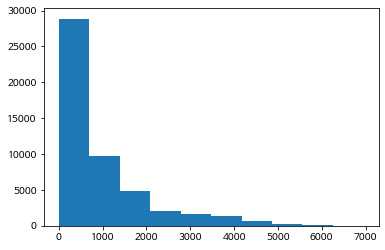

In [ ]:
plt.hist(nan0['em_cnt'])

In [ ]:
# 3구간에서의 데이터 갯수가 균일하게 구간 분할
nan0['em_cnt'] = pd.qcut(nan0.em_cnt, q=3, labels=['low','mid','high'])

In [ ]:
nan0.groupby(['em_cnt']).emd_nm.count()

em_cnt
low     16576
mid     16504
high    16516
Name: emd_nm, dtype: int64

# 4. 연도/월 범주형 변수 생성

In [ ]:
# datetime바꾸기
nan0.base_date = pd.to_datetime(nan0.base_date)

In [ ]:
# month, year 변수 생성
nan0['year'] = nan0['base_date'].dt.year
nan0['month'] = nan0['base_date'].dt.month
nan0

,base_date,emd_nm,region,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,...,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,year,month
0,2018-01-01,남원읍,서귀포시_동,low,1239600.0,19112,628,16153.5654,812.6967,11107.5655,32585.7557,2484.3162,19002.9037,19855.3082,461.6855,6160.3374,19551.2075,998.2235,11951.1205,40878.1785,3923.7522,23220.8175,18843.0999,1061.6917,6119.8320,14684.5211,566.0329,5139.2220,30916.7317,909.5769,6540.5814,17877.4276,165.9416,2053.9942,17803.0511,490.9392,5466.4894,37964.1653,1291.2687,7806.0479,...,0.0,0.0000,3513.4114,0.0,339.2087,8304.6658,0.0,741.1480,11032.1695,0.0,193.0342,2585.7948,328.2548,15.1443,194.9233,345.7900,15.2458,69.6760,0.0,37.1352,131.6772,0.0,54.7028,75.8742,182.2464,209.9038,19474238.0,24828201.0,644192.0,18592157.0,5864209.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,2018,1
1,2018-01-01,성산읍,서귀포시_동,low,424100.0,15338,1575,16727.8881,1250.9516,14703.8154,33126.8217,2341.8504,22326.8821,18136.0794,218.9821,5708.9318,16652.6077,863.4747,14905.7896,43521.3791,3686.8327,26526.2522,18698.6502,280.2342,5761.8376,14829.6794,742.1910,7717.2921,29849.8498,1020.5545,8790.3556,16643.7411,134.7935,2288.3799,15068.5259,352.4037,7137.4200,39374.1297,1884.8375,10411.3381,...,0.0,165.8707,4256.0307,0.0,367.3045,17202.1982,0.0,1326.8781,21573.6964,0.0,276.3276,3915.3667,565.2860,50.8318,417.2296,587.2609,26.4585,273.7653,0.0,29.1916,267.4784,0.0,29.5355,178.0462,486.4469,333.5771,15169445.0,15468906.0,352538.0,5948563.0,6757977.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,2018,1
2,2018-01-01,표선면,서귀포시_동,low,452850.0,12253,409,8873.5163,568.9623,6859.5800,24223.4533,2424.2823,12676.6533,13613.2390,553.3855,3888.2846,11639.7076,896.8565,6581.0867,28059.1008,2421.2159,15794.0004,12813.2761,376.5487,3673.6925,7730.9421,307.4551,4429.1290,22582.4659,756.7657,5185.7867,11953.0293,153.8146,1669.3967,10624.6740,428.6640,3078.3089,26516.8208,1105.8330,6666.7966,...,0.0,228.0861,3276.4695,0.0,344.2965,8101.8225,0.0,759.8231,12903.9506,0.0,421.7818,3173.9354,352.3231,8.7340,112.4051,378.4108,7.3327,73.9492,0.0,28.3955,123.1803,0.0,36.7293,64.5151,280.6459,94.5728,13160715.0,12063919.0,171850.0,8359864.0,3924809.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,2018,1
3,2018-01-01,대정읍,서귀포시_서,low,1264950.0,21085,1518,19245.1729,781.7883,8205.6476,42315.9377,1907.2044,15550.1501,26920.4007,831.5445,5199.6318,26000.9456,992.0483,8203.5551,50768.3756,2393.0628,19205.2393,24984.8080,403.5440,5113.3672,17495.0165,545.2812,4760.0934,39764.7801,999.5837,6984.4644,23763.6830,454.8418,2280.0025,22458.4297,803.5026,4916.7731,46811.6633,1199.0711,8170.6528,...,0.0,166.1916,1810.7644,0.0,378.9049,3982.0264,0.0,622.9472,6479.4503,0.0,289.8330,1625.0470,1066.0740,13.0664,270.6256,1129.0599,24.0387,226.4320,0.0,35.5750,152.2208,0.0,29.8549,119.3026,188.9941,99.1991,20044093.0,37142481.0,512113.0,4144384.0,9787299.0,0,6.1,0.0,340.0,7.8,58.4,1018.5,2018,1
4,2018-01-01,안덕면,서귀

In [ ]:
nan0['year'] = nan0['year'].astype(str)
nan0['month'] = nan0['month'].astype(str)

In [ ]:
nan0

,base_date,emd_nm,region,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,...,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,year,month
0,2018-01-01,남원읍,서귀포시_동,low,1239600.0,19112,628,16153.5654,812.6967,11107.5655,32585.7557,2484.3162,19002.9037,19855.3082,461.6855,6160.3374,19551.2075,998.2235,11951.1205,40878.1785,3923.7522,23220.8175,18843.0999,1061.6917,6119.8320,14684.5211,566.0329,5139.2220,30916.7317,909.5769,6540.5814,17877.4276,165.9416,2053.9942,17803.0511,490.9392,5466.4894,37964.1653,1291.2687,7806.0479,...,0.0,0.0000,3513.4114,0.0,339.2087,8304.6658,0.0,741.1480,11032.1695,0.0,193.0342,2585.7948,328.2548,15.1443,194.9233,345.7900,15.2458,69.6760,0.0,37.1352,131.6772,0.0,54.7028,75.8742,182.2464,209.9038,19474238.0,24828201.0,644192.0,18592157.0,5864209.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,2018,1
1,2018-01-01,성산읍,서귀포시_동,low,424100.0,15338,1575,16727.8881,1250.9516,14703.8154,33126.8217,2341.8504,22326.8821,18136.0794,218.9821,5708.9318,16652.6077,863.4747,14905.7896,43521.3791,3686.8327,26526.2522,18698.6502,280.2342,5761.8376,14829.6794,742.1910,7717.2921,29849.8498,1020.5545,8790.3556,16643.7411,134.7935,2288.3799,15068.5259,352.4037,7137.4200,39374.1297,1884.8375,10411.3381,...,0.0,165.8707,4256.0307,0.0,367.3045,17202.1982,0.0,1326.8781,21573.6964,0.0,276.3276,3915.3667,565.2860,50.8318,417.2296,587.2609,26.4585,273.7653,0.0,29.1916,267.4784,0.0,29.5355,178.0462,486.4469,333.5771,15169445.0,15468906.0,352538.0,5948563.0,6757977.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,2018,1
2,2018-01-01,표선면,서귀포시_동,low,452850.0,12253,409,8873.5163,568.9623,6859.5800,24223.4533,2424.2823,12676.6533,13613.2390,553.3855,3888.2846,11639.7076,896.8565,6581.0867,28059.1008,2421.2159,15794.0004,12813.2761,376.5487,3673.6925,7730.9421,307.4551,4429.1290,22582.4659,756.7657,5185.7867,11953.0293,153.8146,1669.3967,10624.6740,428.6640,3078.3089,26516.8208,1105.8330,6666.7966,...,0.0,228.0861,3276.4695,0.0,344.2965,8101.8225,0.0,759.8231,12903.9506,0.0,421.7818,3173.9354,352.3231,8.7340,112.4051,378.4108,7.3327,73.9492,0.0,28.3955,123.1803,0.0,36.7293,64.5151,280.6459,94.5728,13160715.0,12063919.0,171850.0,8359864.0,3924809.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,2018,1
3,2018-01-01,대정읍,서귀포시_서,low,1264950.0,21085,1518,19245.1729,781.7883,8205.6476,42315.9377,1907.2044,15550.1501,26920.4007,831.5445,5199.6318,26000.9456,992.0483,8203.5551,50768.3756,2393.0628,19205.2393,24984.8080,403.5440,5113.3672,17495.0165,545.2812,4760.0934,39764.7801,999.5837,6984.4644,23763.6830,454.8418,2280.0025,22458.4297,803.5026,4916.7731,46811.6633,1199.0711,8170.6528,...,0.0,166.1916,1810.7644,0.0,378.9049,3982.0264,0.0,622.9472,6479.4503,0.0,289.8330,1625.0470,1066.0740,13.0664,270.6256,1129.0599,24.0387,226.4320,0.0,35.5750,152.2208,0.0,29.8549,119.3026,188.9941,99.1991,20044093.0,37142481.0,512113.0,4144384.0,9787299.0,0,6.1,0.0,340.0,7.8,58.4,1018.5,2018,1
4,2018-01-01,안덕면,서귀

# 5. 제주 전체 지역 모델링

In [ ]:
df_all2 = nan0.drop(['emd_nm','base_date','region'],axis=1)
df_all2 = df_all2.reset_index().drop(['index'],axis=1)
df_all2

,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,...,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,year,month
0,low,1239600.0,19112,628,16153.5654,812.6967,11107.5655,32585.7557,2484.3162,19002.9037,19855.3082,461.6855,6160.3374,19551.2075,998.2235,11951.1205,40878.1785,3923.7522,23220.8175,18843.0999,1061.6917,6119.8320,14684.5211,566.0329,5139.2220,30916.7317,909.5769,6540.5814,17877.4276,165.9416,2053.9942,17803.0511,490.9392,5466.4894,37964.1653,1291.2687,7806.0479,17345.1800,408.5209,1961.6359,...,0.0,0.0000,3513.4114,0.0,339.2087,8304.6658,0.0,741.1480,11032.1695,0.0,193.0342,2585.7948,328.2548,15.1443,194.9233,345.7900,15.2458,69.6760,0.0,37.1352,131.6772,0.0,54.7028,75.8742,182.2464,209.9038,19474238.0,24828201.0,644192.0,18592157.0,5864209.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,2018,1
1,low,424100.0,15338,1575,16727.8881,1250.9516,14703.8154,33126.8217,2341.8504,22326.8821,18136.0794,218.9821,5708.9318,16652.6077,863.4747,14905.7896,43521.3791,3686.8327,26526.2522,18698.6502,280.2342,5761.8376,14829.6794,742.1910,7717.2921,29849.8498,1020.5545,8790.3556,16643.7411,134.7935,2288.3799,15068.5259,352.4037,7137.4200,39374.1297,1884.8375,10411.3381,17193.1875,136.0177,1897.8613,...,0.0,165.8707,4256.0307,0.0,367.3045,17202.1982,0.0,1326.8781,21573.6964,0.0,276.3276,3915.3667,565.2860,50.8318,417.2296,587.2609,26.4585,273.7653,0.0,29.1916,267.4784,0.0,29.5355,178.0462,486.4469,333.5771,15169445.0,15468906.0,352538.0,5948563.0,6757977.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,2018,1
2,low,452850.0,12253,409,8873.5163,568.9623,6859.5800,24223.4533,2424.2823,12676.6533,13613.2390,553.3855,3888.2846,11639.7076,896.8565,6581.0867,28059.1008,2421.2159,15794.0004,12813.2761,376.5487,3673.6925,7730.9421,307.4551,4429.1290,22582.4659,756.7657,5185.7867,11953.0293,153.8146,1669.3967,10624.6740,428.6640,3078.3089,26516.8208,1105.8330,6666.7966,11748.0776,136.4772,1292.0889,...,0.0,228.0861,3276.4695,0.0,344.2965,8101.8225,0.0,759.8231,12903.9506,0.0,421.7818,3173.9354,352.3231,8.7340,112.4051,378.4108,7.3327,73.9492,0.0,28.3955,123.1803,0.0,36.7293,64.5151,280.6459,94.5728,13160715.0,12063919.0,171850.0,8359864.0,3924809.0,0,4.8,0.0,340.0,2.4,55.0,1025.0,2018,1
3,low,1264950.0,21085,1518,19245.1729,781.7883,8205.6476,42315.9377,1907.2044,15550.1501,26920.4007,831.5445,5199.6318,26000.9456,992.0483,8203.5551,50768.3756,2393.0628,19205.2393,24984.8080,403.5440,5113.3672,17495.0165,545.2812,4760.0934,39764.7801,999.5837,6984.4644,23763.6830,454.8418,2280.0025,22458.4297,803.5026,4916.7731,46811.6633,1199.0711,8170.6528,22576.7086,220.0100,1855.1657,...,0.0,166.1916,1810.7644,0.0,378.9049,3982.0264,0.0,622.9472,6479.4503,0.0,289.8330,1625.0470,1066.0740,13.0664,270.6256,1129.0599,24.0387,226.4320,0.0,35.5750,152.2208,0.0,29.8549,119.3026,188.9941,99.1991,20044093.0,37142481.0,512113.0,4144384.0,97

### 1) 표준화(robust)
이상치라고 표현되지만 이상치로 볼 수 없는 데이터가 많아 이를 보완할 수 있는 robust 기법으로 표준화 진행

In [ ]:
all_date_no = df_all2.drop(['em_cnt','year','month','em_g'], axis=1)
all_date_yes = df_all2[['em_cnt','year','month','em_g']]

In [ ]:
# robust
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
print(robustScaler.fit(all_date_no))
all_date_no2 = pd.DataFrame(robustScaler.transform(all_date_no))
all_date_no2.columns = all_date_no.columns
all_date_no2

,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,n_e_resd_12_w_01020,n_e_work_12_w_01020,...,n_e_work_24_w_304050,n_e_visit_24_w_304050,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압
0,0.401259,0.729622,0.015031,-0.166707,0.555167,0.253216,-0.173179,0.644634,0.416785,-0.238662,0.228654,0.127201,-0.136066,0.669208,0.585811,0.008148,0.567984,0.486838,0.386179,0.133348,-0.026713,-0.015698,0.107591,0.145911,-0.088516,-0.025537,0.284493,-0.331259,-0.105397,0.094795,-0.181181,0.139409,0.331146,-0.012393,-0.051183,0.327893,0.215662,-0.182249,0.0,0.248916,...,0.569931,0.987082,0.0,-0.503695,0.773398,0.0,0.310553,0.934677,0.0,0.618344,0.748816,0.0,-0.065417,0.266217,0.459453,-0.318242,0.134128,0.432929,-0.201459,-0.582391,0.0,2.117520,0.069811,0.0,3.235778,-0.254980,0.677969,0.933416,-0.023925,0.013683,-0.141703,0.311311,-0.150022,0.000000,-1.035398,0.0,0.583333,0.000000,-0.795455,1.049587
1,0.174933,2.612326,0.036090,-0.001232,0.960730,0.268105,-0.204988,0.952522,0.309787,-0.565510,0.131682,0.024379,-0.186241,1.039600,0.665517,-0.036070,0.815734,0.477986,-0.495855,0.062482,-0.021012,0.137580,0.543460,0.117611,-0.012247,0.290537,0.208106,-0.397708,-0.032259,-0.012835,-0.298491,0.429552,0.370234,0.348868,0.281468,0.318288,-0.487480,-0.204048,0.0,0.730319,...,0.710521,2.642174,0.0,0.292218,1.091783,0.0,0.365306,2.690813,0.0,1.498906,2.158751,0.0,0.150284,0.871279,1.218328,0.608193,1.605435,1.184649,0.184770,1.122087,0.0,1.582208,0.939358,0.0,1.567008,0.492225,2.324756,1.686457,-0.156268,-0.259832,-0.240982,-0.303401,-0.081887,0.000000,-1.035398,0.0,0.583333,0.000000,-0.795455,1.049587
2,-0.010075,0.294235,-0.251901,-0.258736,0.076106,0.023102,-0.186583,0.058657,0.028301,-0.115170,-0.259431,-0.153443,-0.173811,-0.003970,0.199251,-0.272280,0.011327,0.117354,-0.387144,-0.350873,-0.299827,-0.240692,-0.012463,-0.075163,-0.193535,-0.215875,-0.082336,-0.357130,-0.225407,-0.187743,-0.233915,-0.275279,0.013794,-0.125253,-0.196646,-0.025806,-0.486294,-0.411112,0.0,0.094854,...,0.524091,1.360536,0.0,0.590752,0.671814,0.0,0.320468,0.894641,0.0,0.646419,0.999168,0.0,0.526959,0.533868,0.536510,-0.484651,-0.412009,0.534480,-0.474031,-0.546703,0.0,1.528559,0.015405,0.0,2.044008,-0.338051,1.210654,0.231171,-0.218023,-0.359338,-0.302488,-0.186167,-0.297868,0.000000,-1.035398,0.0,0.583333,0.000000,-0.795455,1.049587
3,0.519580,2.499006,0.128389,-0.178378,0.227907,0.520970,-0.302032,0.324818,0.856491,0.259425,0.022274,0.355992,-0.138365,0.199420,0.884052,-0.277535,0.267007,0.863177,-0.356675,-0.065885,0.083674,-0.033755,0.043493,0.380613,-0.026659,0.036824,0.648961,0.285060,-0.034874,0.278028,0.083494,0.043955,0.576423,-0.068506,-0.004630,0.658489,-0.270754,-0.218642,0.0,0.847521,...,0.025009,0.187657,0.0,0.293758,0.043420,0.0,0.387913,0.081503,0.0,0.440646,0.139888,0.0,0.185258,-0.171001,2.821642,-0.372184,0.635154

In [ ]:
df_all3 = pd.concat([all_date_no2,all_date_yes],axis=1)

In [ ]:
# 더미 변수 생성
df_all3 = pd.get_dummies(df_all3,drop_first=True)
df_all3

,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,n_e_resd_12_w_01020,n_e_work_12_w_01020,...,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,em_g,em_cnt_mid,em_cnt_high,year_2019,year_2020,year_2021,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,0.401259,0.729622,0.015031,-0.166707,0.555167,0.253216,-0.173179,0.644634,0.416785,-0.238662,0.228654,0.127201,-0.136066,0.669208,0.585811,0.008148,0.567984,0.486838,0.386179,0.133348,-0.026713,-0.015698,0.107591,0.145911,-0.088516,-0.025537,0.284493,-0.331259,-0.105397,0.094795,-0.181181,0.139409,0.331146,-0.012393,-0.051183,0.327893,0.215662,-0.182249,0.0,0.248916,...,0.432929,-0.201459,-0.582391,0.0,2.117520,0.069811,0.0,3.235778,-0.254980,0.677969,0.933416,-0.023925,0.013683,-0.141703,0.311311,-0.150022,0.000000,-1.035398,0.0,0.583333,0.000000,-0.795455,1.049587,1239600.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.174933,2.612326,0.036090,-0.001232,0.960730,0.268105,-0.204988,0.952522,0.309787,-0.565510,0.131682,0.024379,-0.186241,1.039600,0.665517,-0.036070,0.815734,0.477986,-0.495855,0.062482,-0.021012,0.137580,0.543460,0.117611,-0.012247,0.290537,0.208106,-0.397708,-0.032259,-0.012835,-0.298491,0.429552,0.370234,0.348868,0.281468,0.318288,-0.487480,-0.204048,0.0,0.730319,...,1.184649,0.184770,1.122087,0.0,1.582208,0.939358,0.0,1.567008,0.492225,2.324756,1.686457,-0.156268,-0.259832,-0.240982,-0.303401,-0.081887,0.000000,-1.035398,0.0,0.583333,0.000000,-0.795455,1.049587,424100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.010075,0.294235,-0.251901,-0.258736,0.076106,0.023102,-0.186583,0.058657,0.028301,-0.115170,-0.259431,-0.153443,-0.173811,-0.003970,0.199251,-0.272280,0.011327,0.117354,-0.387144,-0.350873,-0.299827,-0.240692,-0.012463,-0.075163,-0.193535,-0.215875,-0.082336,-0.357130,-0.225407,-0.187743,-0.233915,-0.275279,0.013794,-0.125253,-0.196646,-0.025806,-0.486294,-0.411112,0.0,0.094854,...,0.534480,-0.474031,-0.546703,0.0,1.528559,0.015405,0.0,2.044008,-0.338051,1.210654,0.231171,-0.218023,-0.359338,-0.302488,-0.186167,-0.297868,0.000000,-1.035398,0.0,0.583333,0.000000,-0.795455,1.049587,452850.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.519580,2.499006,0.128389,-0.178378,0.227907,0.520970,-0.302032,0.324818,0.856491,0.259425,0.022274,0.355992,-0.138365,0.199420,0.884052,-0.277535,0.267007,0.863177,-0.356675,-0.065885,0.083674,-0.033755,0.043493,0.380613,-0.026659,0.036824,0.648961,0.285060,-0.034874,0.278028,0.083494,0.043955,0.576423,-0.068506,-0.004630,0.658489,-0.270754,-0.218642,0.0,0.847521,...,2.871318,0.101418,0.726777,0.0,2.012379,0.201354,0.0,1.588187,0.062621,0.714498,0.259340,-0.006406,0.373553,-0.186663,-0.391118,0.149047,0.000000,-0.920354,0.0,0.583333,2.842105,-0.640909,0.512397,1264950.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.057511,0.518887,0.042897,0.802944,0.902524,0.093626,0.104337,0.856343,0.021792,0.520672,0.242568,0.046180,0.461716,0.591838,0.340793,0.483159,0.675252,0.302061,0.364702,0.132265,-0.027845,0.990295,0.603226,-0.010203,0.142691,0.270986,-0.022780,-0.209738,0.282508,-0.013635,0.583800,0.361664,0.132976,0.981922,0.276726,0.154199,0.079758,-0.213106,0.0,-0.028999,

### 2) em_g 변환(sqrt변환)

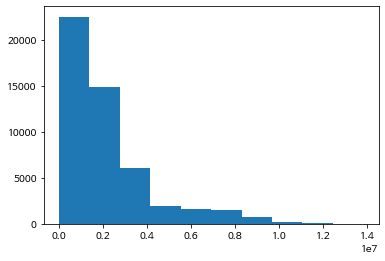

In [ ]:
plt.hist(df_all3['em_g'])
plt.show()

In [ ]:
df_all3['em_g'].skew()

1.8560845476799384

-0.28031052803739404


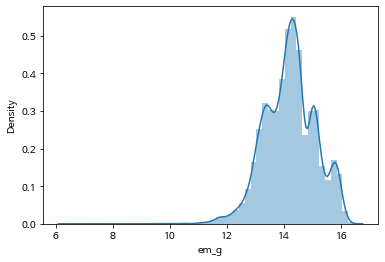

In [ ]:
# 최솟값 확인
df_all3['em_g'].describe()
# 로그 변환
df_log = np.log(df_all3['em_g'])
# skewness 확인
print(df_log.skew())
# KDE plot 출력
sns.distplot(df_log);

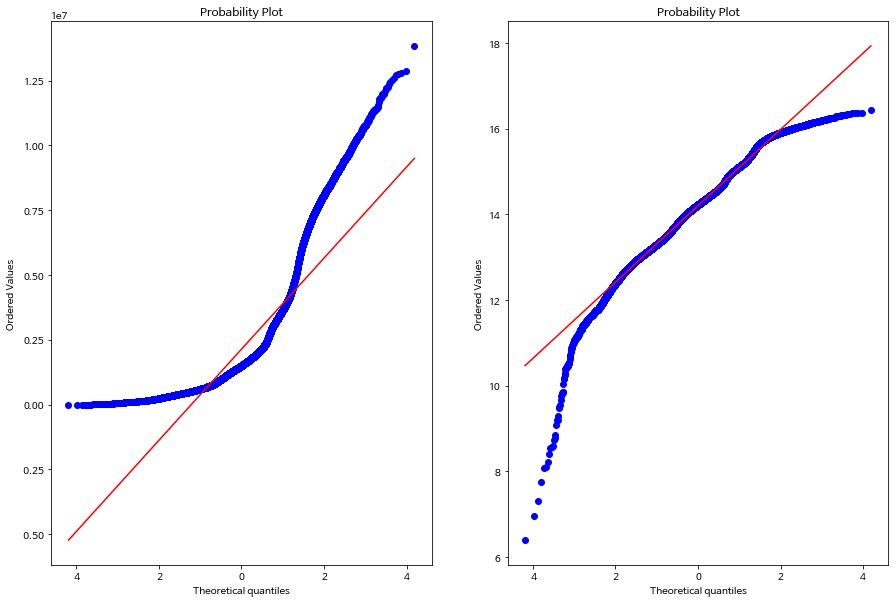

In [ ]:
from scipy import stats
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_all3['em_g'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(df_log, plot=plt)

0.9514616727329209


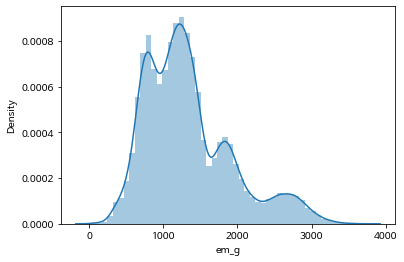

In [ ]:
# 루트 변환
df_root = np.sqrt(df_all3['em_g'])
# skewness 확인
print(df_root.skew())
# KDE plot 출력
sns.distplot(df_root)

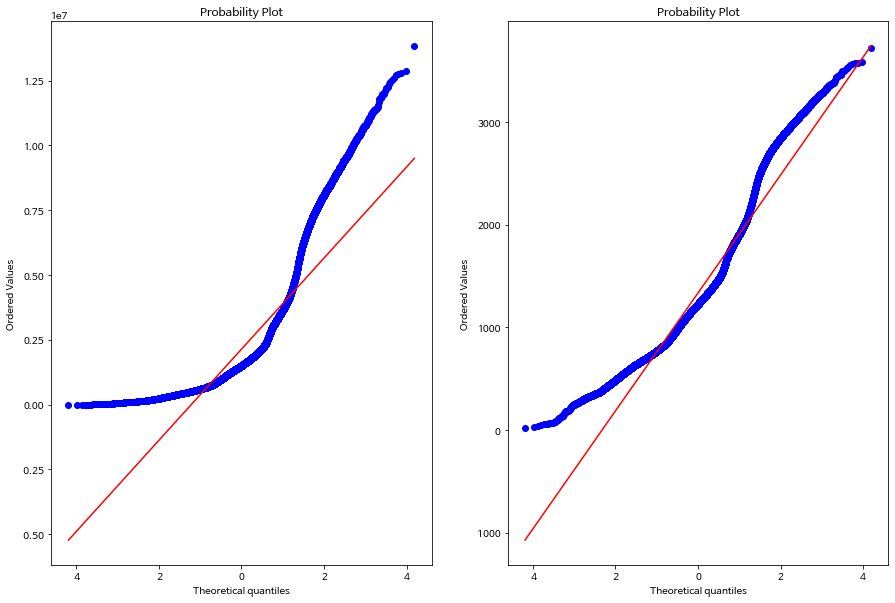

In [ ]:
from scipy import stats
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_all3['em_g'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(df_root, plot=plt)

In [ ]:
df_all5 = df_all3.copy()
df_all5['em_g'] = np.sqrt(df_all5['em_g'])

### 3) stepwise

In [ ]:
## 전진 단계별 선택법
variables = df_all5.drop(['em_g'], axis=1).columns ## 설명 변수 리스트

x_train = df_all5.drop(['em_g'], axis=1)
y_train = df_all5['em_g']

selected_variables0 = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables0))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = x_train[selected_variables0+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y_train,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables0.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables0) > 0:
            selected_X = x_train[selected_variables0]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y_train,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables0.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y_train,sm.add_constant(x_train[selected_variables0])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables0.copy())
    else:
        break

In [ ]:
len(selected_variables0)

79

### 4) 변수중요도 확인 : Random Forest

In [ ]:
X_train_rf0 = df_all5[selected_variables0]
y_train_rf0 = df_all5['em_g']

rf0 = RandomForestRegressor(max_depth=10, random_state=531,
                          n_estimators=150)
rf0.fit(X_train_rf0, y_train_rf0)
featureImportance = rf0.feature_importances_

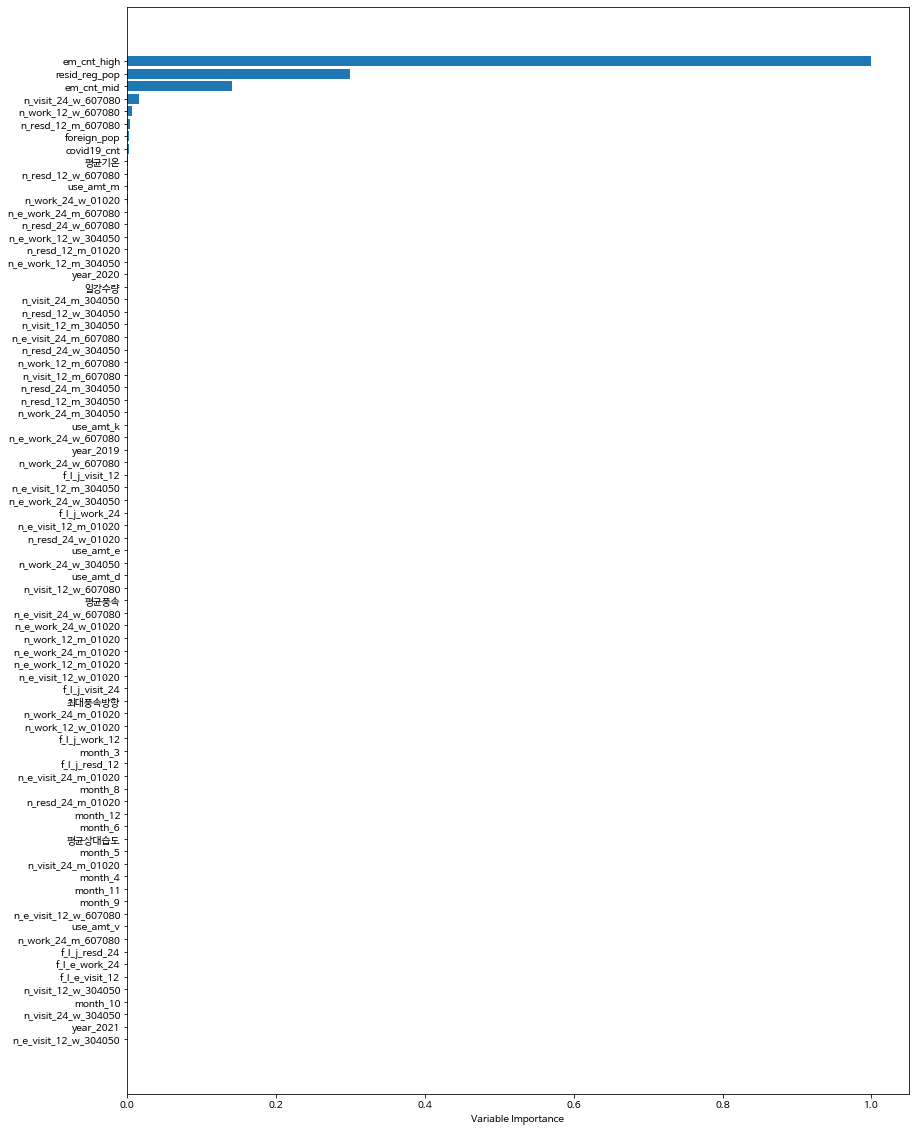

In [ ]:
#가장 높은 중요도 기준으로 스케일링
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,20)

featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plot.barh(barPos, featureImportance[sorted_idx], align='center')
plot.yticks(barPos, X_train_rf0.columns[sorted_idx])
plot.xlabel('Variable Importance')
plot.show()

### 5) 변수중요도 확인 : xgboost

In [ ]:
X_train_xg0 = df_all5[selected_variables0]
y_train_xg0 = df_all5['em_g']

dtrain0 = xgb.DMatrix(data=X_train_xg0, label = y_train_xg0)

In [ ]:
params0 = {'max_depth' : 8,
         'eta' : 0.01, 
         'objective' : 'reg:squarederror',
         'eval_metric' : 'rmse'}

num_rounds0 = 400

In [ ]:
xgb_model0 = xgb.train(params = params0, dtrain=dtrain0, num_boost_round=num_rounds0)

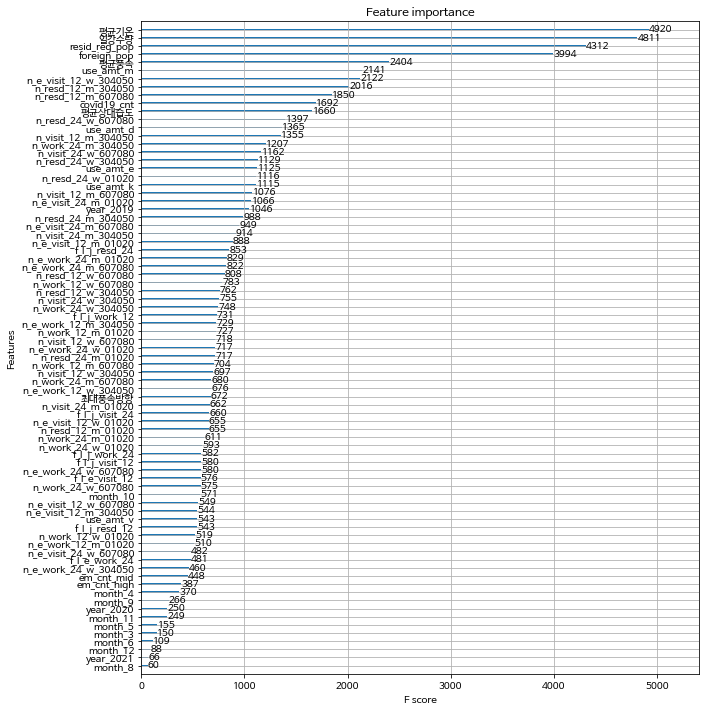

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model0, ax=ax)

### 6) 변수중요도 확인 : Decision Tree Regressor

In [ ]:
X_train_dtr0 = df_all5[selected_variables0]
y_train_dtr0 = df_all5['em_g']

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt0 = DecisionTreeRegressor(max_depth = 8)

dt0.fit(X_train_dtr0, y_train_dtr0)
print(dt0.score(X_train_dtr0, y_train_dtr0))

feature_importance0 = pd.DataFrame(dt0.feature_importances_.reshape((-1, 1)), columns=['feature_importance'], index=X_train_dtr0.columns)
fi0 = feature_importance0.sort_values(by=['feature_importance'], axis=0, ascending=False)
fi0

0.958398463016499


,feature_importance
em_cnt_high,6.541800e-01
resid_reg_pop,2.012852e-01
em_cnt_mid,9.242765e-02
n_visit_24_w_607080,1.230535e-02
foreign_pop,5.613950e-03
n_work_12_w_607080,4.168392e-03
평균기온,3.394625e-03
n_resd_12_w_607080,3.268407e-03
n_resd_24_m_304050,2.675983e-03
covid19_cnt,1.827426e-03


In [ ]:
# 0.0001 이상인 변수들만 선택
fi0.iloc[:14,:].index

Index(['em_cnt_high', 'resid_reg_pop', 'em_cnt_mid', 'n_visit_24_w_607080',
       'foreign_pop', 'n_work_12_w_607080', '평균기온', 'n_resd_12_w_607080',
       'n_resd_24_m_304050', 'covid19_cnt', 'n_resd_12_m_304050', 'use_amt_m',
       'n_visit_12_m_607080', 'n_e_work_24_m_607080'],
      dtype='object')

### 7) regression
Decicion Tree 기반으로 선택된 변수들로 모델링

In [ ]:
model01 = ols('em_g ~ em_cnt_high+ resid_reg_pop+ em_cnt_mid+ n_visit_24_w_607080+ foreign_pop+ n_work_12_w_607080+ 평균기온+ n_resd_12_w_607080+ n_resd_24_m_304050+ covid19_cnt+ n_resd_12_m_304050+ use_amt_m+ n_visit_12_m_607080+ n_e_work_24_m_607080', df_all5)
res01 = model01.fit()
res01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   em_g   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 2.724e+04
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:13:14   Log-Likelihood:            -3.3352e+05
No. Observations:               49596   AIC:                         6.671e+05
Df Residuals:                   49581   BIC:                         6.672e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              922.4355      2.035    453.235      0.000     918.446     926.425
em_cnt_high            594.6560      3.598    165.289      0.000     587.605     601.708
resid_reg_pop           94.1710      7.711     12.212      0.000      79.057     109.285
em_cnt_mid             294.5400      2.424    121.488      0.000     289.788     299.292
n_visit_24_w_607080    185.3111      2.689     68.923      0.000     180.041     190.581
foreign_pop             29.2350      1.150     25.414      0.000      26.980      31.490
n_work_12_w_607080     -28.9793      1.817    -15.952      0.000     -32.540     -25.419
평균기온                    21.6478      1.474     14.690      0.000      18.759      24.536
n_resd_12_w_607080      79.2626      5.112     15.505      0.000      69.243      89.282
n_resd_24_m_304050     403.1680      9.423     42.784      0.000     384.698     421.638
covid19_cnt              4.5178      0.417     10.830      0.000       3.700       5.335
n_resd_12_m_304050    -320.5798      8.127    -39.446      0.000    -336.509    -304.651
use_amt_m              142.5062      2.288     62.291      0.000     138.022     146.990
n_visit_12_m_607080   -173.9969      2.555    -68.093      0.000    -179.005    -168.989
n_e_work_24_m_607080    -1.1968      2.265     -0.528      0.597      -5.636       3.243
==============================================================================
Omnibus:                     6181.675   Durbin-Watson:                   1.382
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15849.976
Skew:                          -0.711   Prob(JB):                         0.00
Kurtosis:                       5.376   Cond. No.                         44.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model01.exog, i)} 
             for i, column in enumerate(model01.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,em_cnt_high,3.511141
1,resid_reg_pop,44.559100
2,em_cnt_mid,1.593907
3,n_visit_24_w_607080,5.801704
4,foreign_pop,2.624651
5,n_work_12_w_607080,5.765986
6,평균기온,1.077233
7,n_resd_12_w_607080,21.949968
8,n_resd_24_m_304050,108.332181
9,covid19_cnt,1.202081


### 8) regression 2
p-value 0.1 이상 변수 삭제

In [ ]:
model02 = ols('em_g ~ em_cnt_high+ resid_reg_pop+ em_cnt_mid+ n_visit_24_w_607080+ foreign_pop+ n_work_12_w_607080+ 평균기온+ n_resd_12_w_607080+ n_resd_24_m_304050+ covid19_cnt+ n_resd_12_m_304050+ use_amt_m+ n_visit_12_m_607080', df_all5)
res02 = model02.fit()
res02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   em_g   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 2.934e+04
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:13:47   Log-Likelihood:            -3.3352e+05
No. Observations:               49596   AIC:                         6.671e+05
Df Residuals:                   49582   BIC:                         6.672e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             922.2631      2.009    459.089      0.000     918.326     926.201
em_cnt_high           594.7016      3.597    165.350      0.000     587.652     601.751
resid_reg_pop          93.4809      7.600     12.301      0.000      78.585     108.376
em_cnt_mid            294.5368      2.424    121.488      0.000     289.785     299.289
n_visit_24_w_607080   185.5434      2.652     69.952      0.000     180.345     190.742
foreign_pop            29.1724      1.144     25.495      0.000      26.930      31.415
n_work_12_w_607080    -28.8137      1.789    -16.103      0.000     -32.321     -25.307
평균기온                   21.7241      1.467     14.813      0.000      18.850      24.599
n_resd_12_w_607080     78.1788      4.683     16.696      0.000      69.001      87.357
n_resd_24_m_304050    403.7028      9.369     43.091      0.000     385.340     422.065
covid19_cnt             4.4904      0.414     10.849      0.000       3.679       5.302
n_resd_12_m_304050   -320.5297      8.127    -39.442      0.000    -336.458    -304.602
use_amt_m             142.7188      2.252     63.372      0.000     138.305     147.133
n_visit_12_m_607080  -174.3696      2.456    -70.996      0.000    -179.183    -169.556
==============================================================================
Omnibus:                     6180.544   Durbin-Watson:                   1.383
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15845.936
Skew:                          -0.711   Prob(JB):                         0.00
Kurtosis:                       5.376   Cond. No.                         43.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model02.exog, i)} 
             for i, column in enumerate(model02.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,em_cnt_high,3.509126
1,resid_reg_pop,43.280918
2,em_cnt_mid,1.593897
3,n_visit_24_w_607080,5.646521
4,foreign_pop,2.596772
5,n_work_12_w_607080,5.594315
6,평균기온,1.066889
7,n_resd_12_w_607080,18.416388
8,n_resd_24_m_304050,107.082530
9,covid19_cnt,1.183436


### 9) regression 3
vif이 10 이상인 변수 삭제

In [ ]:
model03 = ols('em_g ~ em_cnt_high+ em_cnt_mid+ n_visit_24_w_607080+ foreign_pop+ n_work_12_w_607080+ 평균기온+ n_resd_24_m_304050+ covid19_cnt+ use_amt_m+ n_visit_12_m_607080', df_all5)
res03 = model03.fit()
res03.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   em_g   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                 3.638e+04
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:16:21   Log-Likelihood:            -3.3455e+05
No. Observations:               49596   AIC:                         6.691e+05
Df Residuals:                   49585   BIC:                         6.692e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             884.6576      1.797    492.372      0.000     881.136     888.179
em_cnt_high           656.6218      3.308    198.482      0.000     650.138     663.106
em_cnt_mid            310.5290      2.420    128.310      0.000     305.785     315.273
n_visit_24_w_607080   202.7485      2.663     76.126      0.000     197.528     207.969
foreign_pop            20.0266      1.065     18.805      0.000      17.939      22.114
n_work_12_w_607080    -21.6034      1.631    -13.247      0.000     -24.800     -18.407
평균기온                   22.9372      1.495     15.341      0.000      20.007      25.868
n_resd_24_m_304050    226.6184      2.942     77.026      0.000     220.852     232.385
covid19_cnt             4.6128      0.403     11.447      0.000       3.823       5.403
use_amt_m             131.6324      2.052     64.154      0.000     127.611     135.654
n_visit_12_m_607080  -175.0370      2.478    -70.631      0.000    -179.894    -170.180
==============================================================================
Omnibus:                     5676.489   Durbin-Watson:                   1.450
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13641.882
Skew:                          -0.678   Prob(JB):                         0.00
Kurtosis:                       5.183   Cond. No.                         12.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model03.exog, i)} 
             for i, column in enumerate(model03.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,em_cnt_high,2.847623
1,em_cnt_mid,1.523427
2,n_visit_24_w_607080,5.460342
3,foreign_pop,2.157581
4,n_work_12_w_607080,4.457303
5,평균기온,1.063566
6,n_resd_24_m_304050,10.128972
7,covid19_cnt,1.075919
8,use_amt_m,5.034946
9,n_visit_12_m_607080,6.650140


# 6. 제주 4구역 모델링

In [ ]:
df_w = pd.concat([nan0[nan0['region'] == '제주시_서'],nan0[nan0['region'] == '서귀포시_서']])
df_jm = nan0[nan0['region']=='제주시_중']
df_sm = nan0[nan0['region']=='서귀포시_중']
df_e = pd.concat([nan0[nan0['region'] == '제주시_동'],nan0[nan0['region'] == '서귀포시_동']])

In [ ]:
df_w = df_w.drop(['region'], axis=1)
df_jm = df_jm.drop(['region'], axis=1)
df_sm = df_sm.drop(['region'], axis=1)
df_e = df_e.drop(['region'], axis=1)

## * 제주_서(df_w)

In [ ]:
df_w2 = df_w.drop(['emd_nm','base_date'],axis=1)

In [ ]:
df_w2 = df_w2.reset_index().drop(['index'],axis=1)
df_w2

,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,...,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,year,month
0,low,299650.0,34271,935,52327.5625,2207.1099,30691.9543,92614.1157,6391.1452,42767.8619,42858.9767,1522.5867,11453.5272,56061.9309,3088.7700,28086.9051,103334.7886,9456.1997,55395.9181,37451.5288,1877.4104,13315.4460,47310.6050,1625.9476,19732.4878,88141.7083,2972.8490,23442.8125,39603.8666,859.6222,5651.9174,50572.4596,1965.1149,18386.4452,98272.4858,4803.2604,28853.0464,35236.8170,1024.2805,5971.7151,...,0.0,713.4574,8098.4701,0.0,698.4349,21713.3044,0.0,2227.2143,32897.9453,0.0,979.4283,7979.3857,1273.5096,116.7209,648.4721,1360.3301,117.9932,493.5554,0.0,138.1257,665.4932,0.0,165.8609,660.3100,377.5644,345.2284,47960340.0,74595224.0,777744.0,30973999.0,18440163.0,0,6.1,0.0,340.0,7.8,58.4,1018.5,2018,1
1,low,295850.0,34271,935,53642.8865,4824.5010,14620.5625,85642.7378,12492.3578,33045.0974,40199.4289,2319.0381,10762.7317,56292.1971,5783.5131,20740.0592,88430.1734,21498.1856,55083.7839,34262.5415,3228.8561,14629.8853,50640.1497,1778.1201,9874.6253,90370.1128,3083.1081,16210.6986,40193.1638,825.2068,4449.2214,54728.4768,1723.9013,11507.5105,99925.2273,4989.9775,22930.7181,35195.7819,890.6300,4951.7654,...,0.0,691.1075,7031.1825,0.0,625.7100,21407.6649,0.0,2264.3962,26492.0111,0.0,961.1002,6503.2618,1291.7657,158.3131,551.5844,1353.2769,95.9443,474.9228,0.0,139.5965,586.2196,0.0,142.4272,563.3368,414.7950,357.1743,45574620.0,54009313.0,885273.0,36078091.0,15759553.0,0,7.4,0.0,360.0,5.3,54.3,1019.3,2018,1
2,low,222900.0,34271,935,52617.9986,4107.0572,14376.0789,84948.8985,12714.6432,33252.5618,40753.7539,2499.6195,11111.1344,55973.2001,5488.0778,20107.9096,87399.8744,21795.5337,55912.6457,34123.3161,3237.6804,14689.3173,49751.2391,1512.3376,10133.5260,89665.5208,3110.6741,16371.8396,40070.8535,774.1107,4521.0150,54477.7651,1648.3895,10136.2129,98885.2205,4959.7889,22173.6640,34773.1901,812.5236,5327.5635,...,0.0,489.5437,6915.0284,0.0,586.2107,23256.1087,0.0,1877.3118,24804.8488,0.0,1016.8503,6645.1175,1338.6886,106.2404,543.1054,1367.9976,82.2825,352.1647,0.0,114.8516,585.4735,0.0,143.1855,629.7609,532.5764,395.9521,40631527.0,43835400.0,202783.0,29552995.0,17688619.0,0,4.7,0.0,360.0,9.5,71.8,1020.0,2018,1
3,low,275200.0,34271,935,50117.2291,4333.0853,17206.5531,79873.9137,12206.5393,33330.6282,38174.0939,2332.6817,12189.8655,51963.6713,5415.2238,20511.9836,83311.0972,22694.0237,57257.6157,31763.4094,3306.7595,14976.9100,49071.8832,1625.9630,12328.8135,86568.9386,3366.4493,16822.9022,37786.3554,781.4859,5493.1106,52363.1628,1580.4457,11055.5463,96486.6762,5203.2688,25045.9684,33167.0520,888.5244,5056.6221,...,0.0,509.5318,6733.9092,0.0,576.2927,22943.4260,0.0,2178.4619,24803.9936,0.0,1006.2663,6502.0911,1215.9115,130.2060,515.6944,1297.4407,78.2226,368.5450,0.0,1

### 1) 표준화(robust)
이상치라고 표현되지만 이상치로 볼 수 없는 데이터가 많아 이를 보완할 수 있는 robust 기법으로 표준화 진행

In [ ]:
w_date_no = df_w2.drop(['em_cnt','year','month','em_g'], axis=1)
w_date_yes = df_w2[['em_cnt','year','month','em_g']]

In [ ]:
# robust
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
print(robustScaler.fit(w_date_no))
w_date_no2 = pd.DataFrame(robustScaler.transform(w_date_no))
w_date_no2.columns = w_date_no.columns
w_date_no2

,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,n_e_resd_12_w_01020,n_e_work_12_w_01020,...,n_e_work_24_w_304050,n_e_visit_24_w_304050,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압
0,0.582164,-0.096082,1.051368,-0.156266,2.732963,1.086178,0.231089,1.785871,0.842203,0.517570,1.154294,1.192133,0.085757,1.825201,1.355966,0.069384,1.429312,0.596589,0.414379,1.302011,0.799729,0.519140,2.446842,0.940921,1.007451,1.680102,0.743945,1.604473,1.440785,0.882959,0.704520,2.034765,1.059887,1.203406,1.585549,0.577091,1.420730,1.523373,0.0,0.042312,...,1.096270,1.300670,0.0,1.314818,1.001504,0.0,0.102172,1.612343,0.0,1.221695,1.363331,0.0,0.991393,1.120744,0.464261,0.281162,0.463304,0.482838,0.619605,0.311086,0.0,2.985937,1.024457,0.0,3.403610,1.086396,0.719814,0.853019,0.745670,1.375739,-0.120103,0.441754,0.486353,0.000000,-0.863636,0.00,0.666667,0.605263,-0.909502,0.869565
1,0.582164,-0.096082,1.111690,0.665822,0.900705,0.932571,1.548561,1.180132,0.700364,1.238017,1.025334,1.203291,0.965597,1.188501,1.003727,1.574292,1.415813,0.412706,1.335349,1.556980,0.927650,0.649977,0.900288,0.986138,1.076464,0.974120,0.773591,1.497744,0.980458,1.044364,0.502561,1.057311,1.093052,1.291558,1.138365,0.574705,1.093779,1.118872,0.0,0.047673,...,1.019930,0.968565,0.0,1.242276,0.735797,0.0,-0.020158,1.578217,0.0,1.263872,0.941120,0.0,0.957205,0.740015,0.514481,0.625784,0.156192,0.464305,0.370710,0.254420,0.0,3.027384,0.789318,0.0,2.802070,0.808225,0.807911,0.889024,0.657766,0.694956,-0.071399,0.630379,0.271827,0.000000,-0.745455,0.00,0.740741,-0.052632,-1.095023,0.939130
2,0.582164,-0.096082,1.064688,0.440483,0.872832,0.917283,1.596561,1.193057,0.729927,1.401365,1.090375,1.187833,0.869137,1.133717,0.979378,1.611452,1.451660,0.404678,1.341363,1.568509,0.893498,0.421458,0.940906,0.971841,1.093718,0.989850,0.767438,1.339285,1.007937,1.034627,0.439337,0.862458,1.072182,1.277305,1.081202,0.550132,0.902707,1.267910,0.0,0.250816,...,1.015350,0.911734,0.0,0.588047,0.706880,0.0,-0.086599,1.784606,0.0,0.824783,0.829920,0.0,1.061196,0.776603,0.643558,0.194324,0.129315,0.502985,0.216492,-0.118917,0.0,2.330076,0.787105,0.0,2.821535,0.998765,1.086613,1.005900,0.475632,0.358502,-0.380522,0.389240,0.426208,0.000000,-0.990909,0.00,0.740741,1.052632,-0.303167,1.000000
3,0.582164,-0.096082,0.950001,0.511475,1.195527,0.805462,1.486843,1.197921,0.592348,1.250358,1.291756,0.993534,0.845350,1.168736,0.882749,1.723737,1.509828,0.268602,1.388438,1.624295,0.867397,0.519153,1.285314,0.909007,1.253812,1.033882,0.652510,1.362157,1.380003,0.952504,0.382451,0.993089,1.024052,1.392255,1.298084,0.456740,1.088628,1.160457,0.0,0.477782,...,1.044905,0.865247,0.0,0.652924,0.661790,0.0,-0.103282,1.749693,0.0,1.166392,0.829863,0.0,1.041454,0.739713,0.305818,0.392896,0.042428,0.317590,0.170662,-0.069100,0.0,3.107296,1.001383,0.0,2.425809,1.070707,0.98354

In [ ]:
df_w3 = pd.concat([w_date_no2,w_date_yes],axis=1)

In [ ]:
df_w3 = pd.get_dummies(df_w3,drop_first=True)
df_w3

,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,n_e_resd_12_w_01020,n_e_work_12_w_01020,...,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,em_g,em_cnt_mid,em_cnt_high,year_2019,year_2020,year_2021,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,0.582164,-0.096082,1.051368,-0.156266,2.732963,1.086178,0.231089,1.785871,0.842203,0.517570,1.154294,1.192133,0.085757,1.825201,1.355966,0.069384,1.429312,0.596589,0.414379,1.302011,0.799729,0.519140,2.446842,0.940921,1.007451,1.680102,0.743945,1.604473,1.440785,0.882959,0.704520,2.034765,1.059887,1.203406,1.585549,0.577091,1.420730,1.523373,0.0,0.042312,...,0.482838,0.619605,0.311086,0.0,2.985937,1.024457,0.0,3.403610,1.086396,0.719814,0.853019,0.745670,1.375739,-0.120103,0.441754,0.486353,0.000000,-0.863636,0.00,0.666667,0.605263,-0.909502,0.869565,299650.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.582164,-0.096082,1.111690,0.665822,0.900705,0.932571,1.548561,1.180132,0.700364,1.238017,1.025334,1.203291,0.965597,1.188501,1.003727,1.574292,1.415813,0.412706,1.335349,1.556980,0.927650,0.649977,0.900288,0.986138,1.076464,0.974120,0.773591,1.497744,0.980458,1.044364,0.502561,1.057311,1.093052,1.291558,1.138365,0.574705,1.093779,1.118872,0.0,0.047673,...,0.464305,0.370710,0.254420,0.0,3.027384,0.789318,0.0,2.802070,0.808225,0.807911,0.889024,0.657766,0.694956,-0.071399,0.630379,0.271827,0.000000,-0.745455,0.00,0.740741,-0.052632,-1.095023,0.939130,295850.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.582164,-0.096082,1.064688,0.440483,0.872832,0.917283,1.596561,1.193057,0.729927,1.401365,1.090375,1.187833,0.869137,1.133717,0.979378,1.611452,1.451660,0.404678,1.341363,1.568509,0.893498,0.421458,0.940906,0.971841,1.093718,0.989850,0.767438,1.339285,1.007937,1.034627,0.439337,0.862458,1.072182,1.277305,1.081202,0.550132,0.902707,1.267910,0.0,0.250816,...,0.502985,0.216492,-0.118917,0.0,2.330076,0.787105,0.0,2.821535,0.998765,1.086613,1.005900,0.475632,0.358502,-0.380522,0.389240,0.426208,0.000000,-0.990909,0.00,0.740741,1.052632,-0.303167,1.000000,222900.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.582164,-0.096082,0.950001,0.511475,1.195527,0.805462,1.486843,1.197921,0.592348,1.250358,1.291756,0.993534,0.845350,1.168736,0.882749,1.723737,1.509828,0.268602,1.388438,1.624295,0.867397,0.519153,1.285314,0.909007,1.253812,1.033882,0.652510,1.362157,1.380003,0.952504,0.382451,0.993089,1.024052,1.392255,1.298084,0.456740,1.088628,1.160457,0.0,0.477782,...,0.317590,0.170662,-0.069100,0.0,3.107296,1.001383,0.0,2.425809,1.070707,0.983540,1.257648,0.419275,0.540117,-0.182594,0.378383,0.834161,0.000000,-1.081818,5.50,-0.518519,0.578947,0.013575,0.660870,275200.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.582164,-0.096082,0.992265,0.528749,1.220266,0.900355,1.544847,1.162952,0.710188,1.460395,0.863803,1.152885,0.911199,1.159427,1.021560,1.721042,1.409607,0.376863,1.400804,1.413378,0.826775,0.503780,1.371513,0.907415,1.269583,1.003366,0.713951,1.002743,1.083053,0.951462,0.324877,1.137650,1.024960,1.357830,1.205798,0.529895,1.015616,0.989027,0.0,0.360374,...,0.393376,0.715100,0.074143,0.0,2.451297,0.578371,0.0,2.463977,0.656074,0.711448,0

### 2) em_g 변환(sqrt변환)

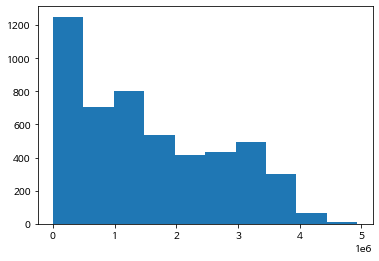

In [ ]:
plt.hist(df_w3['em_g'])
plt.show()

-0.9571965011655494


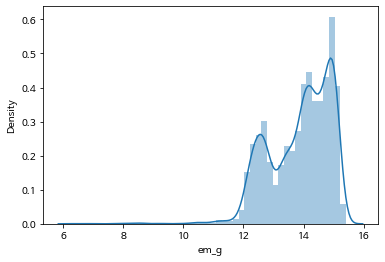

In [ ]:
# 최솟값 확인
df_w3['em_g'].describe()
# 로그 변환
df_log = np.log(df_w3['em_g'])
# skewness 확인
print(df_log.skew())
# KDE plot 출력
sns.distplot(df_log);

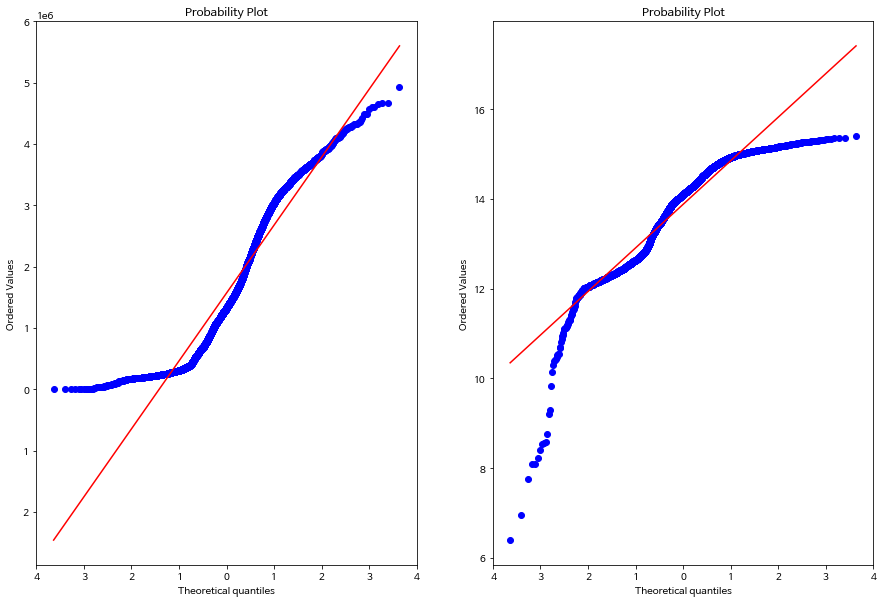

In [ ]:
from scipy import stats
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_w3['em_g'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(df_log, plot=plt)

0.025049626721292337


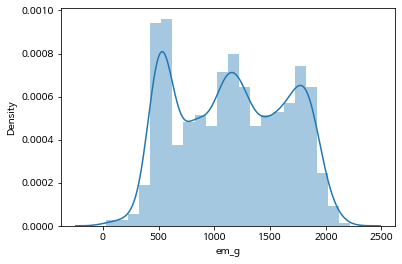

In [ ]:
# 루트 변환
df_root = np.sqrt(df_w3['em_g'])
# skewness 확인
print(df_root.skew())
# KDE plot 출력
sns.distplot(df_root)

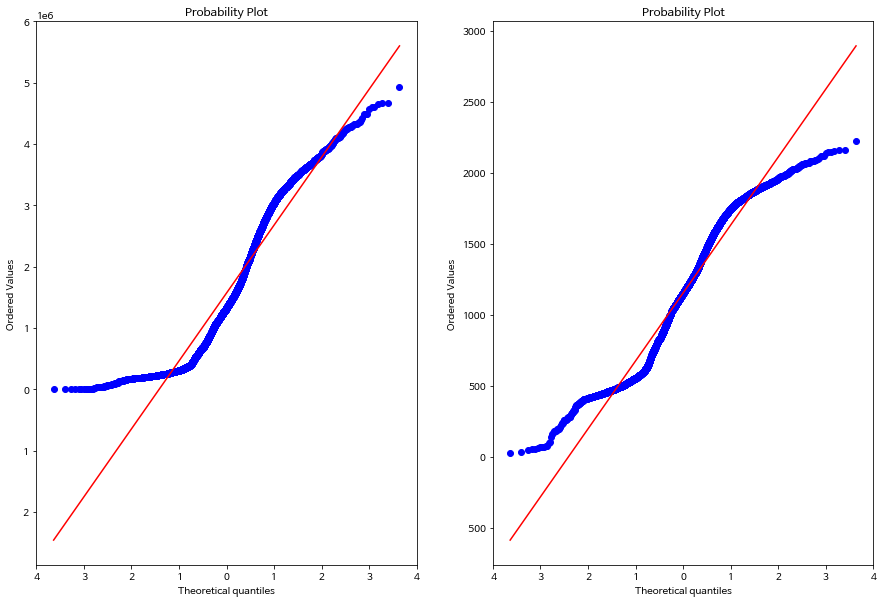

In [ ]:
from scipy import stats
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_w3['em_g'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(df_root, plot=plt)

-0.13758163998973694


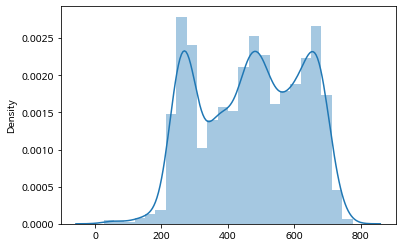

In [ ]:
from scipy import stats
# box-cox 변환
df_boxcox = pd.Series(stats.boxcox(df_w3['em_g'])[0])
# skewness 확인
print(df_boxcox.skew())
# KDE plot 출력
sns.distplot(df_boxcox);

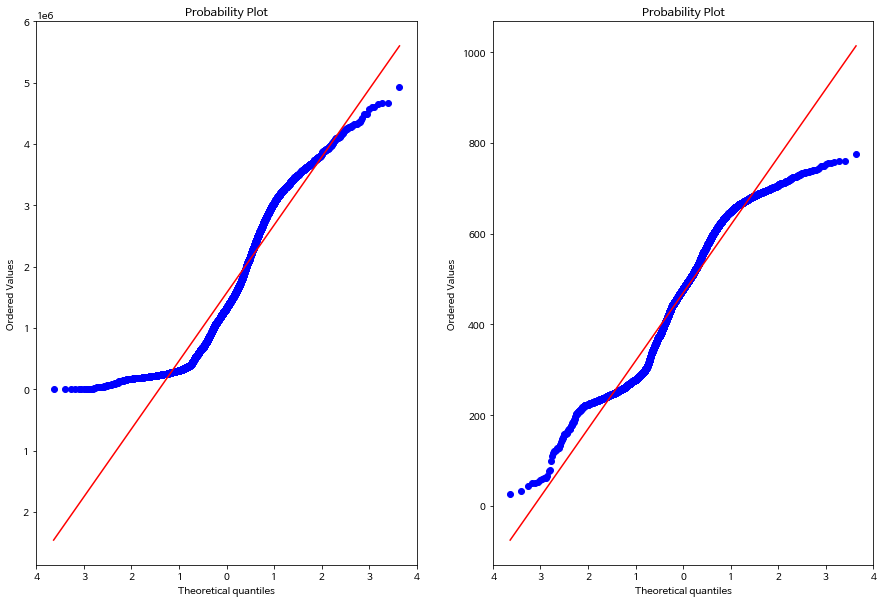

In [ ]:
from scipy import stats
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_w3['em_g'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(df_boxcox, plot=plt)

In [ ]:
df_w5 = df_w3.copy()
df_w5['em_g'] = np.sqrt(df_w5['em_g'])

### 3) stepwise

In [ ]:
## 전진 단계별 선택법
variables = df_w5.drop(['em_g'], axis=1).columns ## 설명 변수 리스트

x_train = df_w5.drop(['em_g'], axis=1)
y_train = df_w5['em_g']

selected_variables1 = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables1))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = x_train[selected_variables1+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y_train,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables1.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables1) > 0:
            selected_X = x_train[selected_variables1]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y_train,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables1.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y_train,sm.add_constant(x_train[selected_variables1])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables1.copy())
    else:
        break

In [ ]:
len(selected_variables1)

61

### 4) 변수중요도 확인 : Random Forest

In [ ]:
X_train_rf1 = df_w5[selected_variables1]
y_train_rf1 = df_w5['em_g']

rf1 = RandomForestRegressor(max_depth=8, random_state=531, n_estimators=150)
rf1.fit(X_train_rf1, y_train_rf1)
featureImportance = rf1.feature_importances_

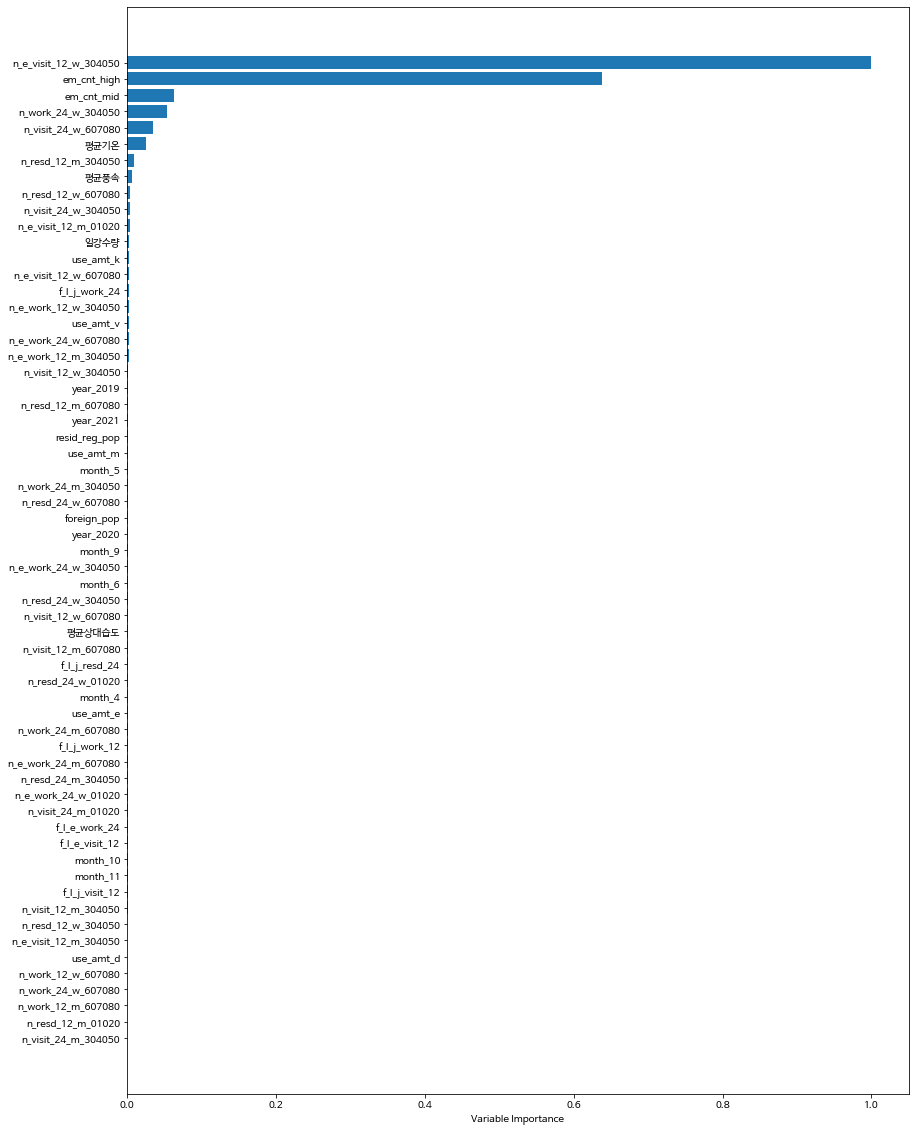

In [ ]:
#가장 높은 중요도 기준으로 스케일링
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,20)

featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plot.barh(barPos, featureImportance[sorted_idx], align='center')
plot.yticks(barPos, X_train_rf0.columns[sorted_idx])
plot.xlabel('Variable Importance')
plot.show()

### 5) 변수중요도 확인 : xgboost

In [ ]:
X_train_xg1 = df_w5[selected_variables1]
y_train_xg1 = df_w5['em_g']

dtrain1 = xgb.DMatrix(data=X_train_xg1, label = y_train_xg1)

In [ ]:
params1 = {'max_depth' : 8,
         'eta' : 0.01, 
         'objective' : 'reg:squarederror',
         'eval_metric' : 'rmse'}

num_rounds1 = 400

In [ ]:
xgb_model1 = xgb.train(params = params1, dtrain=dtrain1, num_boost_round=num_rounds1)

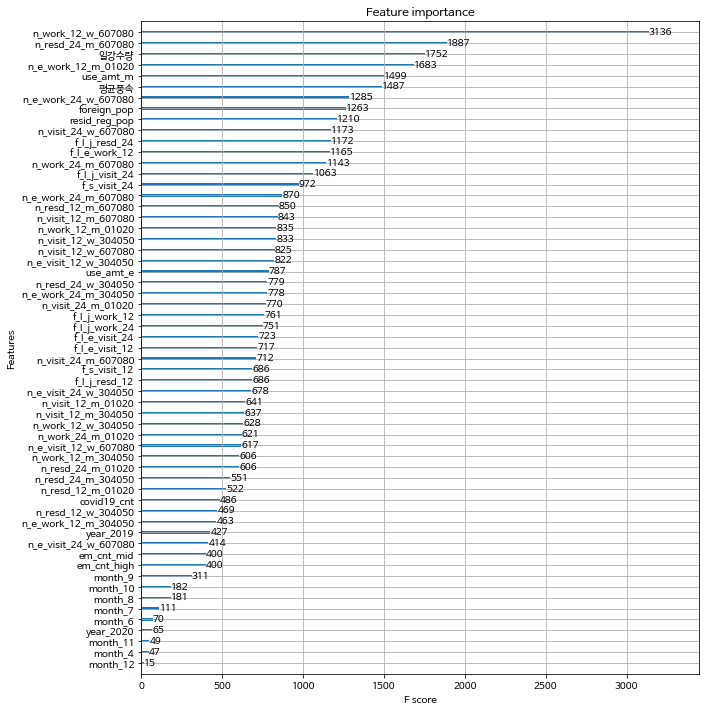

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model1, ax=ax)

### 6) 변수중요도 확인 : Decision Tree Regressor

In [ ]:
X_train_dtr1 = df_w5[selected_variables1]
y_train_dtr1 = df_w5['em_g']

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt1 = DecisionTreeRegressor(max_depth = 8)

dt1.fit(X_train_dtr1, y_train_dtr1)
print(dt1.score(X_train_dtr1, y_train_dtr1))

feature_importance1 = pd.DataFrame(dt1.feature_importances_.reshape((-1, 1)), columns=['feature_importance'], index=X_train_dtr1.columns)
fi = feature_importance1.sort_values(by=['feature_importance'], axis=0, ascending=False)
fi

0.9758584666169972


,feature_importance
em_cnt_high,0.532230
em_cnt_mid,0.338681
n_work_12_w_607080,0.034560
n_resd_12_m_607080,0.022877
resid_reg_pop,0.018856
n_resd_24_m_607080,0.017734
f_l_j_resd_24,0.004335
n_work_24_m_607080,0.003046
foreign_pop,0.002309
n_e_work_24_m_607080,0.002150


In [ ]:
# 0.0001 이상인 변수들만 선택
fi.iloc[:16,:].index

Index(['em_cnt_high', 'em_cnt_mid', 'n_work_12_w_607080', 'n_resd_12_m_607080',
       'resid_reg_pop', 'n_resd_24_m_607080', 'f_l_j_resd_24',
       'n_work_24_m_607080', 'foreign_pop', 'n_e_work_24_m_607080',
       'f_l_j_work_12', 'n_e_visit_12_w_304050', 'month_9', '일강수량',
       'f_s_visit_12', 'f_l_j_work_24'],
      dtype='object')

### 7) regression
Decicion Tree 기반으로 선택된 변수들로 모델링

In [ ]:
model11 = ols('em_g ~ em_cnt_high+ em_cnt_mid+ n_work_12_w_607080+ n_resd_12_m_607080+ resid_reg_pop+ n_resd_24_m_607080+ f_l_j_resd_24+ n_work_24_m_607080+ foreign_pop+ n_e_work_24_m_607080+ f_l_j_work_12+ n_e_visit_12_w_304050+ month_9+ 일강수량+ f_s_visit_12+ f_l_j_work_24', df_w5)
res11 = model11.fit()
res11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   em_g   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     2674.
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:23:59   Log-Likelihood:                -32535.
No. Observations:                5019   AIC:                         6.510e+04
Df Residuals:                    5002   BIC:                         6.522e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               794.5767      6.890    115.318      0.000     781.069     808.085
em_cnt_high             936.5682      9.998     93.678      0.000     916.968     956.168
em_cnt_mid              483.9115      7.321     66.101      0.000     469.560     498.263
n_work_12_w_607080     -106.2415      7.896    -13.455      0.000    -121.722     -90.761
n_resd_12_m_607080      106.1575     48.316      2.197      0.028      11.438     200.878
resid_reg_pop          -444.2758     23.838    -18.637      0.000    -491.009    -397.543
n_resd_24_m_607080      275.2816     55.454      4.964      0.000     166.567     383.996
f_l_j_resd_24            43.1095      3.658     11.785      0.000      35.938      50.281
n_work_24_m_607080       31.9117      6.381      5.001      0.000      19.402      44.421
foreign_pop              17.0600      4.244      4.020      0.000       8.740      25.380
n_e_work_24_m_607080    -63.7018      7.344     -8.674      0.000     -78.100     -49.304
f_l_j_work_12            37.8428      9.638      3.926      0.000      18.948      56.738
n_e_visit_12_w_304050    -3.0194      6.176     -0.489      0.625     -15.127       9.088
month_9                 -48.4973      9.274     -5.229      0.000     -66.679     -30.316
일강수량                     -0.2621      0.075     -3.471      0.001      -0.410      -0.114
f_s_visit_12              0.6578      4.385      0.150      0.881      -7.938       9.254
f_l_j_work_24           -74.5748     10.347     -7.208      0.000     -94.859     -54.291
==============================================================================
Omnibus:                      312.366   Durbin-Watson:                   1.486
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              856.400
Skew:                          -0.334   Prob(JB):                    1.08e-186
Kurtosis:                       4.910   Cond. No.                     1.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model11.exog, i)} 
             for i, column in enumerate(model11.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,em_cnt_high,3.494423
1,em_cnt_mid,2.391372
2,n_work_12_w_607080,5.962077
3,n_resd_12_m_607080,177.621176
4,resid_reg_pop,21.732593
5,n_resd_24_m_607080,232.038711
6,f_l_j_resd_24,2.978660
7,n_work_24_m_607080,5.434317
8,foreign_pop,2.653521
9,n_e_work_24_m_607080,5.104136


### 8) regression 2
p-value 0.1 이상 변수 삭제

In [ ]:
model12 = ols('em_g ~ em_cnt_high+ em_cnt_mid+ n_work_12_w_607080+ n_resd_12_m_607080+ resid_reg_pop+ n_resd_24_m_607080+ f_l_j_resd_24+ n_work_24_m_607080+ foreign_pop+ n_e_work_24_m_607080+ f_l_j_work_12+ month_9+ 일강수량+ f_l_j_work_24', df_w5)
res12 = model12.fit()
res12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   em_g   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     3057.
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:24:41   Log-Likelihood:                -32535.
No. Observations:                5019   AIC:                         6.510e+04
Df Residuals:                    5004   BIC:                         6.520e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              795.0855      6.074    130.904      0.000     783.178     806.993
em_cnt_high            936.6368      9.615     97.413      0.000     917.787     955.487
em_cnt_mid             483.3829      6.966     69.388      0.000     469.726     497.040
n_work_12_w_607080    -107.1266      7.661    -13.983      0.000    -122.146     -92.107
n_resd_12_m_607080     104.6302     48.199      2.171      0.030      10.139     199.122
resid_reg_pop         -442.3091     20.256    -21.836      0.000    -482.020    -402.598
n_resd_24_m_607080     274.3271     55.065      4.982      0.000     166.375     382.279
f_l_j_resd_24           43.1458      3.656     11.800      0.000      35.978      50.314
n_work_24_m_607080      31.5560      6.338      4.979      0.000      19.130      43.982
foreign_pop             17.5324      4.109      4.267      0.000       9.477      25.588
n_e_work_24_m_607080   -63.5232      7.325     -8.672      0.000     -77.884     -49.162
f_l_j_work_12           37.3948      9.589      3.900      0.000      18.597      56.193
month_9                -48.0805      9.233     -5.207      0.000     -66.182     -29.979
일강수량                    -0.2609      0.075     -3.458      0.001      -0.409      -0.113
f_l_j_work_24          -74.5191     10.315     -7.224      0.000     -94.741     -54.298
==============================================================================
Omnibus:                      313.411   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              861.891
Skew:                          -0.335   Prob(JB):                    6.96e-188
Kurtosis:                       4.917   Cond. No.                     1.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model12.exog, i)} 
             for i, column in enumerate(model12.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,em_cnt_high,3.233244
1,em_cnt_mid,2.166232
2,n_work_12_w_607080,5.614466
3,n_resd_12_m_607080,176.827630
4,resid_reg_pop,15.698087
5,n_resd_24_m_607080,228.873803
6,f_l_j_resd_24,2.976928
7,n_work_24_m_607080,5.363774
8,foreign_pop,2.488412
9,n_e_work_24_m_607080,5.079784


### 9) regression 3
vif이 10 이상인 변수 삭제

In [ ]:
model13 = ols('em_g ~ em_cnt_high+ em_cnt_mid+ n_work_12_w_607080+ n_resd_24_m_607080+ f_l_j_resd_24+ n_work_24_m_607080+ foreign_pop+ n_e_work_24_m_607080+ f_l_j_work_12+ month_9+ 일강수량', df_w5)
res13 = model13.fit()
res13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   em_g   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     3448.
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:27:17   Log-Likelihood:                -32806.
No. Observations:                5019   AIC:                         6.564e+04
Df Residuals:                    5007   BIC:                         6.571e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              776.2773      5.919    131.155      0.000     764.674     787.881
em_cnt_high            989.1876      9.856    100.359      0.000     969.865    1008.511
em_cnt_mid             513.3258      7.220     71.102      0.000     499.172     527.479
n_work_12_w_607080    -188.3222      6.572    -28.655      0.000    -201.206    -175.438
n_resd_24_m_607080     100.4535     14.192      7.078      0.000      72.631     128.276
f_l_j_resd_24           12.6406      3.560      3.551      0.000       5.662      19.619
n_work_24_m_607080      32.6725      6.632      4.926      0.000      19.670      45.675
foreign_pop             35.7721      3.953      9.049      0.000      28.023      43.522
n_e_work_24_m_607080   -34.4415      7.584     -4.541      0.000     -49.310     -19.573
f_l_j_work_12           27.8067      4.509      6.167      0.000      18.967      36.646
month_9                -58.3683      9.708     -6.013      0.000     -77.400     -39.337
일강수량                    -0.2035      0.079     -2.589      0.010      -0.358      -0.049
==============================================================================
Omnibus:                      183.033   Durbin-Watson:                   1.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              369.415
Skew:                          -0.255   Prob(JB):                     6.06e-81
Kurtosis:                       4.227   Cond. No.                         245.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model13.exog, i)} 
             for i, column in enumerate(model13.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,em_cnt_high,3.051615
1,em_cnt_mid,2.089616
2,n_work_12_w_607080,3.710709
3,n_resd_24_m_607080,13.655207
4,f_l_j_resd_24,2.534472
5,n_work_24_m_607080,5.275050
6,foreign_pop,2.068268
7,n_e_work_24_m_607080,4.890505
8,f_l_j_work_12,3.570242
9,month_9,1.040344


## * 제주시_중(df_jm)

In [ ]:
df_jm2 = df_jm.drop(['emd_nm','base_date'],axis=1)

In [ ]:
df_jm2 = df_jm2.reset_index().drop(['index'],axis=1)
df_jm2

,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,...,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,year,month
0,mid,1708250.0,9800,228,13908.7818,1244.3701,11616.8041,19564.8956,2580.2597,17508.8801,10131.9079,466.1778,7676.3925,12503.9237,1634.9479,11811.3553,20069.2347,4490.5522,21473.3543,10381.3675,662.1160,7369.7029,12449.3549,616.9883,7168.2886,19754.1470,1423.1800,9639.1932,9515.3719,254.8614,4286.8722,11543.5185,777.1826,7293.7586,20098.3661,2083.4544,11903.1996,10148.4596,364.9112,3859.9040,...,0.0,241.5921,906.5991,0.0,281.4135,5240.7567,0.0,276.4716,7665.7476,0.0,206.1700,1584.7212,226.3683,28.1748,182.0547,243.0018,38.5402,184.1960,0.0,23.7227,185.0380,0.0,42.2100,185.4558,322.6958,294.0984,25816289.0,19891147.0,54010.0,8656232.0,7189222.0,0,6.4,0.0,360.0,3.5,53.4,1025.5,2018,1
1,high,9357900.0,53369,1589,108845.0147,7315.3260,26215.7700,151002.6730,10792.8412,41421.5032,46550.6136,2223.2357,13233.5913,115866.4385,6693.3845,30400.0748,137625.8794,9239.5945,46268.4656,32739.8640,1464.7547,12772.0817,99904.4093,5277.8064,19740.0154,153494.3484,6200.9063,27291.4837,44467.8462,1531.7010,8765.8757,103835.6657,5331.1596,23398.0496,143882.1914,6021.1205,32942.1641,33282.7578,1134.1977,7669.8564,...,0.0,394.5215,3607.7032,0.0,742.9370,13738.3228,0.0,1388.9696,13254.5608,0.0,421.5099,3761.2191,2091.3094,178.1277,651.2448,2273.9906,170.4768,561.8190,0.0,42.8962,232.7443,0.0,52.5080,203.7370,607.7897,621.0056,129584867.0,168640726.0,2185932.0,45195225.0,57964882.0,0,6.4,0.0,360.0,3.5,53.4,1025.5,2018,1
2,low,613300.0,3026,98,2242.3159,77.3761,5390.5155,3858.5488,578.9789,8892.3470,1703.0670,118.3860,2528.5910,2515.7795,252.2573,5866.8368,3772.1162,1025.3877,10852.6925,1645.3753,140.1892,2264.3325,1932.8951,5.9489,2986.9342,3578.1603,236.6869,4133.3292,1751.1694,31.8574,1123.4288,2129.1021,133.5120,2892.9773,3754.5535,402.3382,5452.8829,1432.3541,100.9035,844.3197,...,0.0,57.0214,1389.0013,0.0,0.0000,2804.1813,0.0,18.5488,4651.6950,0.0,17.5664,1773.4895,103.5400,0.0000,100.1410,113.5789,0.0000,86.3554,0.0,0.0000,47.6508,0.0,0.0000,24.6071,176.5509,128.8954,8210011.0,12135409.0,0.0,1167303.0,1186256.0,0,6.4,0.0,360.0,3.5,53.4,1025.5,2018,1
3,low,395300.0,3927,76,6030.9174,539.4514,4221.6564,8833.2242,1688.0599,10282.2645,3240.8436,88.7972,3656.9593,6494.4658,531.6103,4378.0620,9403.9471,1450.2830,13294.2804,3880.2749,359.7095,4509.1873,5690.2918,351.9613,2089.5174,8837.4599,215.5049,3460.8509,3632.0017,41.4972,1659.9235,6031.0692,291.5695,2227.7873,9421.2739,622.9332,4526.6226,3675.3234,158.2141,1688.6885,...,0.0,0.0000,1435.8643,0.0,115.8728,3285.7698,0.0,77.7276,5202.6247,0.0,96.7789,1462.0498,87.0375,21.3418,145.8556,103.8354,21.5255,88.8451,0.0,0.0000,89.5997,0.0,0.0000,78.7286,19.5771,17.3097,3624071.0,10942279.0,0.0,920232.0,2851335.0,0,6.4,0.0,360.0,3.5,53.4,1025.5,2

### 1) 표준화(robust)
이상치라고 표현되지만 이상치로 볼 수 없는 데이터가 많아 이를 보완할 수 있는 robust 기법으로 표준화 진행

In [ ]:
jm_date_no = df_jm2.drop(['em_cnt','year','month','em_g'], axis=1)
jm_date_yes = df_jm2[['em_cnt','year','month','em_g']]

In [ ]:
# robust
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
print(robustScaler.fit(jm_date_no))
jm_date_no2 = pd.DataFrame(robustScaler.transform(jm_date_no))
jm_date_no2.columns = jm_date_no.columns
jm_date_no2

,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,n_e_resd_12_w_01020,n_e_work_12_w_01020,...,n_e_work_24_w_304050,n_e_visit_24_w_304050,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압
0,-0.199325,-0.091703,-0.096176,-0.124611,0.107208,-0.069824,-0.185101,0.095277,-0.148223,-0.249804,0.124111,-0.124006,-0.041850,0.160368,-0.021694,0.042440,0.097642,-0.007303,-0.207717,-0.035442,-0.135507,-0.111327,0.049547,-0.105026,-0.032881,0.019292,-0.230798,-0.272828,0.094102,-0.146491,-0.078509,0.036068,-0.114874,0.237171,0.002733,-0.108967,-0.171070,-0.062999,0.0,-0.330387,...,0.024913,0.853840,0.0,0.720787,-0.340290,0.0,0.238714,0.475666,0.0,-0.043410,0.635726,0.0,-0.061243,-0.140725,0.329060,0.042602,0.108791,0.295038,0.496249,0.373923,0.0,1.772577,0.800193,0.0,3.310027,0.919944,1.472873,1.403113,-0.156626,-0.319816,-0.357610,-0.312816,-0.244944,0.000000,-0.871795,0.0,0.666667,0.5000,-0.795918,0.886179
1,1.530977,5.851528,1.721885,1.205132,1.255864,2.281078,0.978422,1.301965,1.614582,1.005734,0.811382,1.921940,0.869063,1.670720,2.685264,0.611611,1.244336,1.257978,0.499881,0.703146,1.601082,2.512591,1.482843,1.879876,2.406863,1.637108,1.459549,1.318044,1.098142,1.804137,2.101740,2.017464,2.097375,2.007056,1.774878,1.099119,1.333671,0.852714,0.0,0.901896,...,1.733456,2.333311,0.0,1.514559,1.434885,0.0,1.139500,2.383477,0.0,2.140552,1.770944,0.0,0.504259,1.075708,8.912359,3.708869,3.296102,9.118376,4.615175,3.612186,0.0,3.407589,1.217432,0.0,4.181987,1.089645,3.088741,3.374524,1.800831,2.922227,0.033848,0.956648,2.179634,0.000000,-0.871795,0.0,0.666667,0.5000,-0.795918,0.886179
2,-0.468348,-0.659389,-0.319592,-0.380222,-0.382681,-0.350748,-0.468634,-0.339535,-0.556211,-0.498325,-0.512530,-0.321710,-0.290842,-0.322630,-0.396966,-0.372859,-0.393530,-0.501678,-0.667842,-0.733424,-0.344332,-0.455327,-0.427166,-0.345102,-0.638763,-0.485316,-0.606285,-0.550679,-0.615034,-0.345469,-0.386671,-0.505384,-0.406969,-0.518450,-0.540587,-0.564127,-0.687475,-0.787788,0.0,-0.357363,...,-0.324918,0.443532,0.0,-0.237218,-0.023253,0.0,-0.310539,-0.071376,0.0,-0.549742,0.023502,0.0,-0.556532,-0.035223,-0.236251,-0.646257,-0.447667,-0.267221,-0.706937,-0.465098,0.0,-0.250366,-0.401395,0.0,-0.264010,-0.573188,0.644546,0.406858,-0.488746,-0.488854,-0.367527,-0.573002,-0.531590,0.000000,-0.871795,0.0,0.666667,0.5000,-0.795918,0.886179
3,-0.432566,-0.755459,-0.247039,-0.279012,-0.474647,-0.261771,-0.311504,-0.269396,-0.481777,-0.519469,-0.372982,-0.242957,-0.240536,-0.443595,-0.267282,-0.321935,-0.280614,-0.375204,-0.474316,-0.426518,-0.269721,-0.260531,-0.529480,-0.267046,-0.649580,-0.546948,-0.515325,-0.538668,-0.494770,-0.262999,-0.311000,-0.587226,-0.305694,-0.419298,-0.618607,-0.446998,-0.575374,-0.584846,0.0,-0.195480,...,-0.259226,0.365930,0.0,-0.533184,0.007545,0.0,-0.084383,0.036747,0.0,-0.433567,0.135408,0.0,-0.34

In [ ]:
df_jm3 = pd.concat([jm_date_no2,jm_date_yes],axis=1)

In [ ]:
df_jm3 = pd.get_dummies(df_jm3,drop_first=True)
df_jm3

,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,n_e_resd_12_w_01020,n_e_work_12_w_01020,...,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,em_g,em_cnt_mid,em_cnt_high,year_2019,year_2020,year_2021,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,-0.199325,-0.091703,-0.096176,-0.124611,0.107208,-0.069824,-0.185101,0.095277,-0.148223,-0.249804,0.124111,-0.124006,-0.041850,0.160368,-0.021694,0.042440,0.097642,-0.007303,-0.207717,-0.035442,-0.135507,-0.111327,0.049547,-0.105026,-0.032881,0.019292,-0.230798,-0.272828,0.094102,-0.146491,-0.078509,0.036068,-0.114874,0.237171,0.002733,-0.108967,-0.171070,-0.062999,0.0,-0.330387,...,0.295038,0.496249,0.373923,0.0,1.772577,0.800193,0.0,3.310027,0.919944,1.472873,1.403113,-0.156626,-0.319816,-0.357610,-0.312816,-0.244944,0.000000,-0.871795,0.0,0.666667,0.5000,-0.795918,0.886179,1708250.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.530977,5.851528,1.721885,1.205132,1.255864,2.281078,0.978422,1.301965,1.614582,1.005734,0.811382,1.921940,0.869063,1.670720,2.685264,0.611611,1.244336,1.257978,0.499881,0.703146,1.601082,2.512591,1.482843,1.879876,2.406863,1.637108,1.459549,1.318044,1.098142,1.804137,2.101740,2.017464,2.097375,2.007056,1.774878,1.099119,1.333671,0.852714,0.0,0.901896,...,9.118376,4.615175,3.612186,0.0,3.407589,1.217432,0.0,4.181987,1.089645,3.088741,3.374524,1.800831,2.922227,0.033848,0.956648,2.179634,0.000000,-0.871795,0.0,0.666667,0.5000,-0.795918,0.886179,9357900.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.468348,-0.659389,-0.319592,-0.380222,-0.382681,-0.350748,-0.468634,-0.339535,-0.556211,-0.498325,-0.512530,-0.321710,-0.290842,-0.322630,-0.396966,-0.372859,-0.393530,-0.501678,-0.667842,-0.733424,-0.344332,-0.455327,-0.427166,-0.345102,-0.638763,-0.485316,-0.606285,-0.550679,-0.615034,-0.345469,-0.386671,-0.505384,-0.406969,-0.518450,-0.540587,-0.564127,-0.687475,-0.787788,0.0,-0.357363,...,-0.267221,-0.706937,-0.465098,0.0,-0.250366,-0.401395,0.0,-0.264010,-0.573188,0.644546,0.406858,-0.488746,-0.488854,-0.367527,-0.573002,-0.531590,0.000000,-0.871795,0.0,0.666667,0.5000,-0.795918,0.886179,613300.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.432566,-0.755459,-0.247039,-0.279012,-0.474647,-0.261771,-0.311504,-0.269396,-0.481777,-0.519469,-0.372982,-0.242957,-0.240536,-0.443595,-0.267282,-0.321935,-0.280614,-0.375204,-0.474316,-0.426518,-0.269721,-0.260531,-0.529480,-0.267046,-0.649580,-0.546948,-0.515325,-0.538668,-0.494770,-0.262999,-0.311000,-0.587226,-0.305694,-0.419298,-0.618607,-0.446998,-0.575374,-0.584846,0.0,-0.195480,...,-0.309550,-0.034932,-0.443747,0.0,-0.250366,-0.034510,0.0,-0.264010,-0.070787,-0.245157,-0.266058,-0.575253,-0.514859,-0.367527,-0.581586,-0.452081,0.000000,-0.871795,0.0,0.666667,0.5000,-0.795918,0.886179,395300.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.243487,-0.117904,-0.235910,-0.277779,-0.141573,-0.220304,-0.360708,-0.051318,-0.217101,-0.053276,-0.072664,-0.212478,-0.275810,-0.077416,-0.190934,-0.343441,-0.189923,-0.292106,-0.357917,-0.423922,-0.261604,-0.165250,-0.030378,-0.231593,-0.335336,0.036942,-0.294903,0.147876,0.120826,-0.238244,-0.239583,-0.045001,-0.236003,

### 2) em_g 변환(sqrt변환)

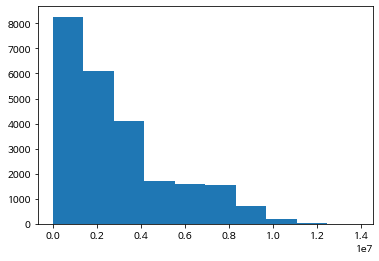

In [ ]:
plt.hist(df_jm3['em_g'])
plt.show()

-0.1647116759687407


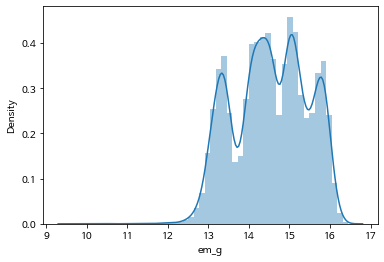

In [ ]:
# 최솟값 확인
df_jm3['em_g'].describe()
# 로그 변환
df_log = np.log(df_jm3['em_g'])
# skewness 확인
print(df_log.skew())
# KDE plot 출력
sns.distplot(df_log);

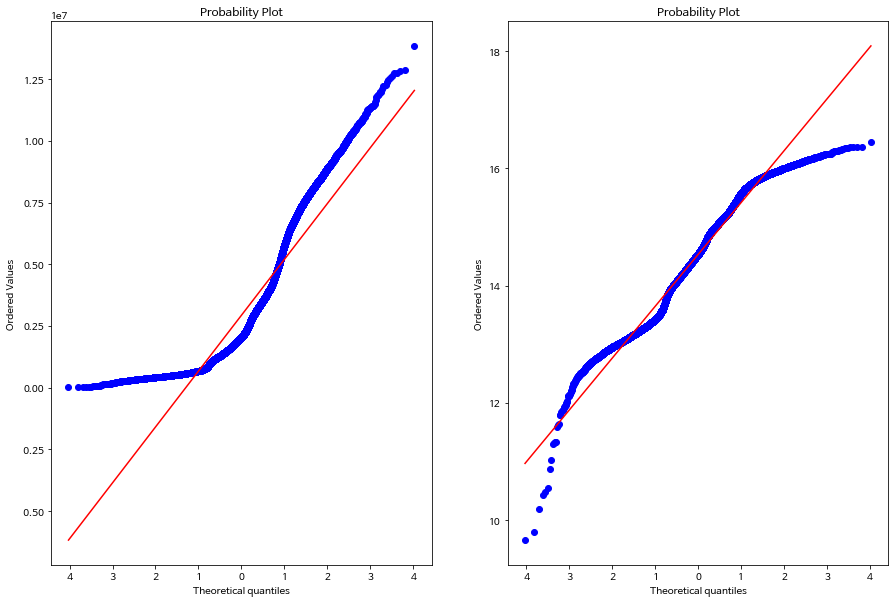

In [ ]:
from scipy import stats
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_jm3['em_g'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(df_log, plot=plt)

0.5362027819845314


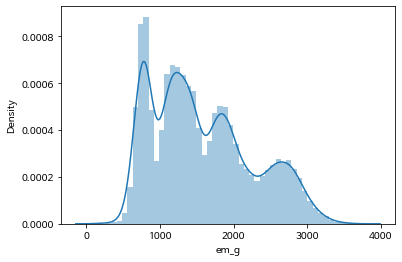

In [ ]:
# 루트 변환
df_root = np.sqrt(df_jm3['em_g'])
# skewness 확인
print(df_root.skew())
# KDE plot 출력
sns.distplot(df_root)

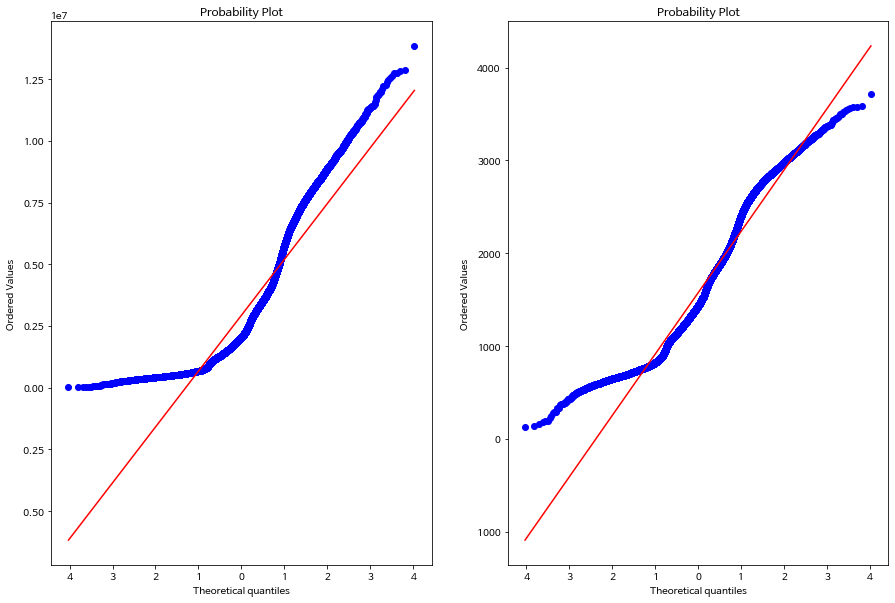

In [ ]:
from scipy import stats
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_jm3['em_g'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(df_root, plot=plt)

-0.02405259989696451


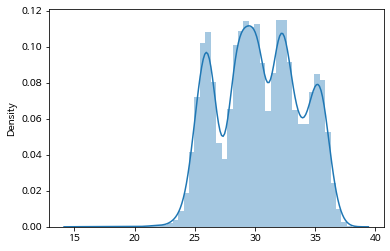

In [ ]:
from scipy import stats
# box-cox 변환
df_boxcox = pd.Series(stats.boxcox(df_jm3['em_g'])[0])
# skewness 확인
print(df_boxcox.skew())
# KDE plot 출력
sns.distplot(df_boxcox);

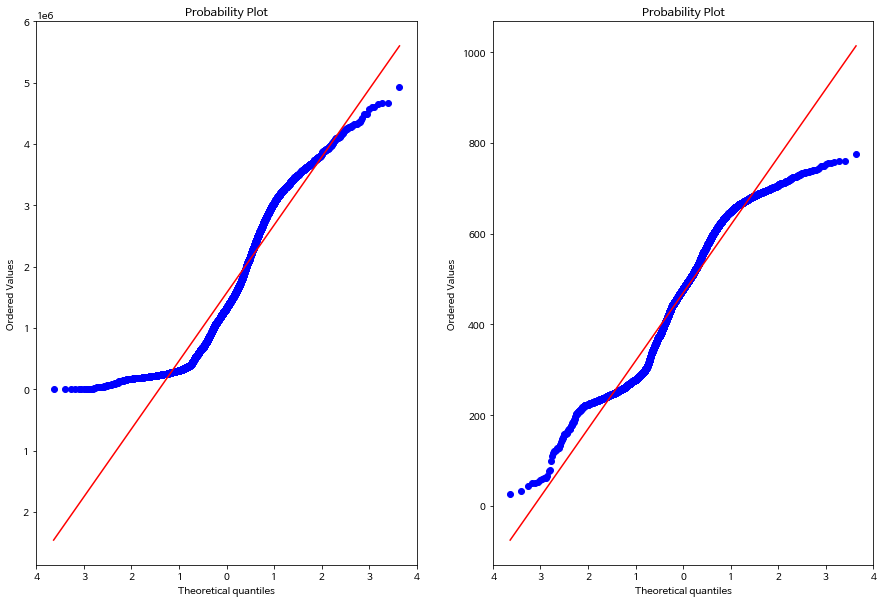

In [ ]:
from scipy import stats
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_w3['em_g'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(df_boxcox, plot=plt)

In [ ]:
df_jm5 = df_jm3.copy()
df_jm5['em_g'] = np.sqrt(df_jm5['em_g'])

### 3) stepwise

In [ ]:
## 전진 단계별 선택법
variables = df_jm5.drop(['em_g'], axis=1).columns ## 설명 변수 리스트

x_train = df_jm5.drop(['em_g'], axis=1)
y_train = df_jm5['em_g']

selected_variables2 = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables2))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = x_train[selected_variables2+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y_train,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables2.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables2) > 0:
            selected_X = x_train[selected_variables2]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y_train,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables2.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y_train,sm.add_constant(x_train[selected_variables2])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables2.copy())
    else:
        break

In [ ]:
len(selected_variables2)

75

### 4) 변수중요도 확인 : Random Forest

In [ ]:
X_train_rf2 = df_jm5[selected_variables2]
y_train_rf2 = df_jm5['em_g']

regr2 = RandomForestRegressor(max_depth=10, random_state=531, n_estimators=150)
regr2.fit(X_train_rf2, y_train_rf2)
featureImportance = regr2.feature_importances_

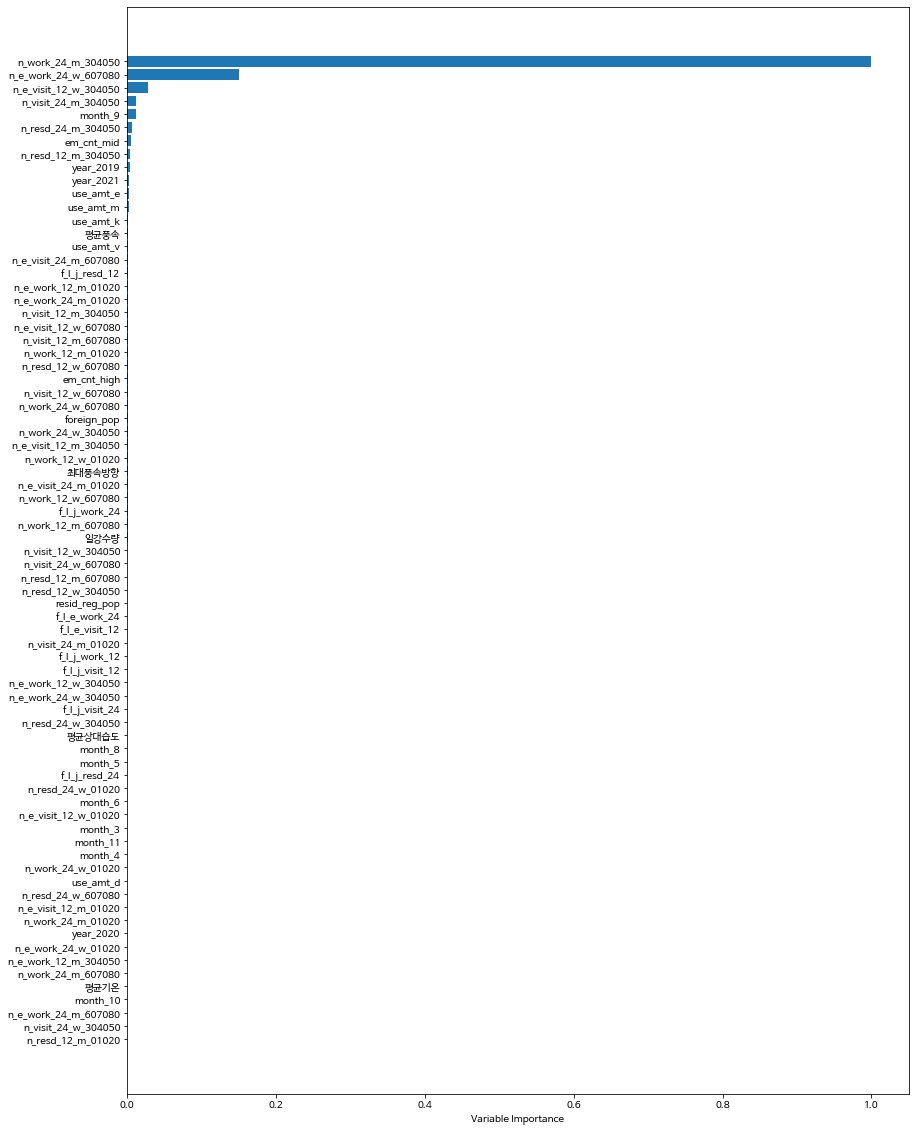

In [ ]:
#가장 높은 중요도 기준으로 스케일링
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,20)

featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plot.barh(barPos, featureImportance[sorted_idx], align='center')
plot.yticks(barPos, X_train_rf0.columns[sorted_idx])
plot.xlabel('Variable Importance')
plot.show()

### 5) 변수중요도 확인 : xgboost

In [ ]:
X_train_xg2 = df_jm5[selected_variables2]
y_train_xg2 = df_jm5['em_g']

dtrain2 = xgb.DMatrix(data=X_train_xg2, label = y_train_xg2)

In [ ]:
params2 = {'max_depth' : 8,
         'eta' : 0.01, 
         'objective' : 'reg:squarederror',
         'eval_metric' : 'rmse'}

num_rounds2 = 400

In [ ]:
xgb_model2 = xgb.train(params = params2, dtrain=dtrain2, num_boost_round=num_rounds2)

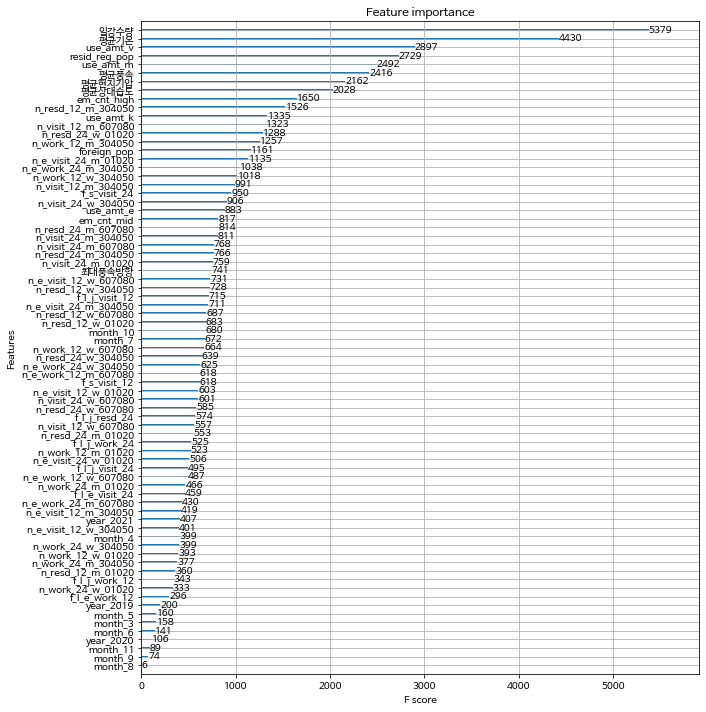

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model2, ax=ax)

### 6) 변수중요도 확인 : Decision Tree Regressor

In [ ]:
X_train_dtr2 = df_jm5[selected_variables2]
y_train_dtr2 = df_jm5['em_g']

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt2 = DecisionTreeRegressor(max_depth = 10)

dt2.fit(X_train_dtr2, y_train_dtr2)
print(dt2.score(X_train_dtr2, y_train_dtr2))

feature_importance2 = pd.DataFrame(dt2.feature_importances_.reshape((-1, 1)), columns=['feature_importance'], index=X_train_dtr2.columns)
fi2 = feature_importance2.sort_values(by=['feature_importance'], axis=0, ascending=False)
fi2

0.9822128510777803


,feature_importance
resid_reg_pop,8.055130e-01
n_visit_24_m_304050,1.299227e-01
em_cnt_high,2.251089e-02
n_visit_24_w_607080,9.640203e-03
평균기온,5.691410e-03
em_cnt_mid,3.333932e-03
n_work_12_m_304050,3.304210e-03
foreign_pop,2.435866e-03
n_resd_12_m_304050,2.373793e-03
일강수량,2.061893e-03


In [ ]:
# 0.0001 이상인 변수들만 선택
fi2.iloc[:13,:].index

Index(['resid_reg_pop', 'n_visit_24_m_304050', 'em_cnt_high',
       'n_visit_24_w_607080', '평균기온', 'em_cnt_mid', 'n_work_12_m_304050',
       'foreign_pop', 'n_resd_12_m_304050', '일강수량', 'use_amt_m',
       'n_work_12_w_304050', 'n_resd_24_m_607080'],
      dtype='object')

### 7) regression
Decicion Tree 기반으로 선택된 변수들로 모델링

In [ ]:
model21 = ols('em_g ~ resid_reg_pop+ n_visit_24_m_304050+ em_cnt_high+ n_visit_24_w_607080+ 평균기온+ em_cnt_mid+ n_work_12_m_304050+ foreign_pop+ n_resd_12_m_304050+ 일강수량+ use_amt_m+ n_work_12_w_304050+ n_resd_24_m_607080', df_jm5)
res21 = model21.fit()
res21.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   em_g   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                 3.824e+04
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:43:35   Log-Likelihood:            -1.5522e+05
No. Observations:               24234   AIC:                         3.105e+05
Df Residuals:                   24220   BIC:                         3.106e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1163.5953      2.923    398.103      0.000    1157.866    1169.324
resid_reg_pop         755.3805      8.164     92.524      0.000     739.378     771.383
n_visit_24_m_304050    66.7820      3.985     16.760      0.000      58.972      74.592
em_cnt_high           367.3424      3.966     92.626      0.000     359.569     375.116
n_visit_24_w_607080    36.2625      4.431      8.183      0.000      27.577      44.948
평균기온                   39.5902      1.516     26.111      0.000      36.618      42.562
em_cnt_mid            178.1733      3.172     56.163      0.000     171.955     184.392
n_work_12_m_304050   -132.5869      5.179    -25.600      0.000    -142.738    -122.435
foreign_pop            -9.5196      0.915    -10.399      0.000     -11.314      -7.725
n_resd_12_m_304050     15.4005      6.125      2.515      0.012       3.396      27.405
일강수량                   -1.1899      0.041    -29.125      0.000      -1.270      -1.110
use_amt_m              87.2028      3.318     26.284      0.000      80.700      93.706
n_work_12_w_304050     73.3692      4.791     15.315      0.000      63.979      82.759
n_resd_24_m_607080    -43.5864      5.128     -8.500      0.000     -53.637     -33.536
==============================================================================
Omnibus:                     5100.770   Durbin-Watson:                   1.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46775.825
Skew:                          -0.753   Prob(JB):                         0.00
Kurtosis:                       9.638   Cond. No.                         244.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model21.exog, i)} 
             for i, column in enumerate(model21.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,resid_reg_pop,29.322984
1,n_visit_24_m_304050,15.684577
2,em_cnt_high,4.399737
3,n_visit_24_w_607080,9.314996
4,평균기온,1.054983
5,em_cnt_mid,2.175810
6,n_work_12_m_304050,34.752499
7,foreign_pop,6.600259
8,n_resd_12_m_304050,30.938043
9,일강수량,1.039271


### 8) regression 3
vif이 10 이상인 변수 삭제

In [ ]:
model33 = ols('em_g ~ n_visit_24_m_304050+ em_cnt_high+ n_visit_24_w_607080+ 평균기온+ em_cnt_mid+ n_work_12_m_304050+ foreign_pop+ 일강수량+ use_amt_m+ n_resd_24_m_607080', df_jm5)
res33 = model33.fit()
res33.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   em_g   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                 3.300e+04
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:51:06   Log-Likelihood:            -1.5990e+05
No. Observations:               24234   AIC:                         3.198e+05
Df Residuals:                   24223   BIC:                         3.199e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1090.9874      3.040    358.825      0.000    1085.028    1096.947
n_visit_24_m_304050    79.8494      4.797     16.647      0.000      70.448      89.251
em_cnt_high           519.0483      4.206    123.405      0.000     510.804     527.292
n_visit_24_w_607080    29.1979      5.048      5.784      0.000      19.303      39.092
평균기온                   32.4200      1.824     17.776      0.000      28.845      35.995
em_cnt_mid            178.0065      3.766     47.270      0.000     170.625     185.388
n_work_12_m_304050    -25.1862      2.022    -12.454      0.000     -29.150     -21.222
foreign_pop             4.6892      0.945      4.960      0.000       2.836       6.542
일강수량                   -0.9435      0.049    -19.161      0.000      -1.040      -0.847
use_amt_m             251.8541      3.386     74.391      0.000     245.218     258.490
n_resd_24_m_607080    279.9390      4.138     67.650      0.000     271.828     288.050
==============================================================================
Omnibus:                     2164.339   Durbin-Watson:                   1.525
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8236.604
Skew:                          -0.399   Prob(JB):                         0.00
Kurtosis:                       5.742   Cond. No.                         144.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model33.exog, i)} 
             for i, column in enumerate(model33.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,n_visit_24_m_304050,15.439691
1,em_cnt_high,3.361821
2,n_visit_24_w_607080,8.211527
3,평균기온,1.036868
4,em_cnt_mid,2.082550
5,n_work_12_m_304050,3.599724
6,foreign_pop,4.782891
7,일강수량,1.025536
8,use_amt_m,7.639887
9,n_resd_24_m_607080,6.461139


## * 제주_동(df_e)

In [ ]:
df_e2 = df_e.drop(['emd_nm','base_date'],axis=1)

In [ ]:
df_e2 = df_e2.reset_index().drop(['index'],axis=1)
df_e2

,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,...,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,year,month
0,low,6150.0,24614,624,29857.4872,4227.1673,5561.4762,49030.8890,10464.0476,16515.4995,26333.7682,1216.8271,6708.5413,29606.8813,4023.5827,5489.8590,47914.5155,14339.4565,27924.1151,27820.0228,2025.6997,9849.1310,31753.6472,1489.5173,3750.5860,52136.3767,1565.1194,5602.5939,25747.8937,432.7085,2190.7935,30811.0299,1250.7519,2993.4319,54336.8016,2428.9267,8979.4917,27591.1202,322.7811,2450.9844,...,0.0,458.2042,7446.5267,0.0,982.2419,7200.5403,0.0,1604.5411,15916.5244,0.0,539.1988,6944.0898,536.7685,55.9975,226.9478,588.7466,35.2742,135.5703,0.0,19.0620,252.2459,0.0,19.1479,210.4660,293.6245,235.1724,34099299.0,35479454.0,635271.0,35767283.0,12110861.0,0,16.6,2.8,90.0,2.7,74.5,1018.2,2019,11
1,low,1500.0,15556,658,19419.7123,7569.7146,4261.1683,31810.6494,6533.1309,10735.0884,18121.0910,745.4639,3691.0410,16341.3154,7921.5019,6354.9453,35406.3104,8130.8148,17917.3599,21480.4248,705.4859,6465.7982,17322.4634,1606.8944,1313.9153,30234.7343,843.9932,2419.5913,16500.6826,195.7138,799.1796,15991.7242,1597.4356,1711.5538,35597.2555,1612.4048,3946.1168,20643.0592,190.8728,1521.8702,...,0.0,28.6944,2298.0110,0.0,191.3045,4067.8055,0.0,938.6797,6576.3893,0.0,488.1797,2166.4437,485.1077,43.2494,210.3185,478.5483,18.7064,92.2358,0.0,13.2534,305.4305,0.0,20.4111,132.3067,222.4890,123.2916,20473674.0,12003326.0,331578.0,9217412.0,4520513.0,0,15.6,0.2,320.0,2.6,74.0,1016.8,2019,11
2,low,36550.0,24614,624,29129.7845,4981.9026,4536.3161,48683.2750,10844.0051,18990.1859,26645.7215,1309.0297,8904.2659,28466.9407,4337.6495,6256.5550,47363.3082,14715.0469,33053.8825,27081.1362,1958.5064,12853.2963,30944.9371,1905.9103,3118.7254,51693.5505,1716.5616,5852.9934,25154.8532,419.8579,2529.2318,30840.9216,1362.2077,3629.2593,53862.1438,2433.1389,9140.9416,27137.4702,347.6837,3040.1821,...,0.0,428.4243,8421.8446,0.0,1029.5209,6554.5577,0.0,1599.1084,15336.4007,0.0,523.1828,7471.9590,579.0056,61.8976,296.7371,599.6032,40.1636,151.9118,0.0,13.2274,284.3151,0.0,13.2214,154.2153,284.2247,204.2068,40762040.0,29720188.0,1674621.0,38201943.0,14503040.0,0,15.6,0.2,320.0,2.6,74.0,1016.8,2019,11
3,low,14050.0,15556,658,18903.5409,7923.0382,3829.4716,30811.2109,6203.1314,9159.1561,18033.6203,675.8745,3392.1524,16634.8440,8051.4877,6440.3120,35029.1589,8119.5834,18775.4801,21137.5731,765.4315,6276.0643,16831.1185,1445.9564,1573.0119,29665.3163,864.7987,2351.4475,16577.5010,183.3957,1013.7133,15995.3340,1759.7569,1595.3716,35143.9057,1799.0036,3919.5676,20140.3478,183.6741,1826.2603,...,0.0,0.0000,2497.9686,0.0,197.1334,4719.9832,0.0,919.6176,7210.0656,0.0,437.7403,2283.6283,467.2216,55.5598,219.1573,477.8538,24.7544,69.5925,0.0,20.2879,244.0622,0.0,20.3386,98.7491,175.5180,103.2224,20371868.0,13382721.0,1

### 1) 표준화(robust)
이상치라고 표현되지만 이상치로 볼 수 없는 데이터가 많아 이를 보완할 수 있는 robust 기법으로 표준화 진행

In [ ]:
e_date_no = df_e2.drop(['em_cnt','year','month','em_g'], axis=1)
e_date_yes = df_e2[['em_cnt','year','month','em_g']]

In [ ]:
# robust
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
print(robustScaler.fit(e_date_no))
e_date_no2 = pd.DataFrame(robustScaler.transform(e_date_no))
e_date_no2.columns = e_date_no.columns
e_date_no2

,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,n_e_resd_12_w_01020,n_e_work_12_w_01020,...,n_e_work_24_w_304050,n_e_visit_24_w_304050,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압
0,1.386817,-0.025862,2.036905,4.799252,0.932163,2.886280,2.884953,1.035490,1.076816,1.994232,0.867415,2.601350,3.264940,0.376394,0.940135,3.013903,1.269055,0.724346,1.831662,1.283781,3.500256,4.461132,1.318434,3.694465,3.091223,1.315960,1.386392,1.747274,1.614463,4.195814,2.175337,0.529668,1.744468,2.418019,1.374957,0.946838,0.232793,0.937417,0.0,1.344990,...,2.420423,0.920799,0.0,1.101308,1.539966,0.0,1.815522,0.056558,0.0,1.560572,0.672434,0.0,-0.018013,1.768938,0.800347,1.026247,0.238473,1.090138,1.206479,0.241283,0.0,0.315036,0.122748,0.0,0.276205,0.107159,0.414019,0.608163,2.167158,1.242465,-0.070278,1.688055,1.943033,0.000000,0.086957,2.8,-0.857143,0.000000,0.188073,0.293103
1,0.007916,0.006705,0.500915,9.741687,0.410722,-0.001762,1.149001,0.087560,-0.262758,0.620553,-0.117438,-0.303325,7.793683,0.736734,-0.258657,0.858812,0.198654,0.031495,-0.369284,0.325118,0.473731,4.920656,-0.410303,0.048942,0.140315,-0.528450,-0.288505,0.005574,-0.755190,-0.090508,3.213994,-0.468170,-0.106913,0.528788,-0.540944,0.111192,-0.557289,-0.149265,0.0,0.393076,...,0.389547,-0.420012,0.0,-1.169718,-0.807720,0.0,-0.370921,-0.585666,0.0,0.108119,-0.887503,0.0,-0.154323,-0.980361,0.391507,0.485170,0.083032,0.227278,0.088136,-0.333880,0.0,-0.070129,0.495115,0.0,0.358089,-0.479254,0.244502,0.161296,0.450461,-0.726230,-0.294442,-0.393100,-0.395965,0.000000,0.000000,0.2,0.238095,-0.071429,0.165138,0.172414
2,1.386817,-0.025862,1.929819,5.915237,0.521060,2.827981,3.052748,1.441314,1.127698,2.262935,1.584057,2.351744,3.629834,0.695751,0.887307,3.144275,1.817775,0.643593,1.719643,2.135007,3.330652,6.091284,0.870150,3.620756,3.710937,1.461055,1.278978,1.652833,2.190759,4.204460,2.509256,1.024607,1.697574,2.427765,1.436411,0.892277,0.381950,1.626536,0.0,1.904613,...,2.087254,1.003963,0.0,0.943847,1.984704,0.0,1.946218,-0.075871,0.0,1.548722,0.575545,0.0,-0.060804,2.072701,1.134609,1.276670,0.890821,1.175146,1.536518,0.458178,0.0,-0.071853,0.347278,0.0,-0.107969,-0.314878,0.391619,0.484482,3.006599,0.759496,0.696892,1.878900,2.680193,0.000000,0.000000,0.2,0.238095,-0.071429,0.165138,0.172414
3,0.007916,0.006705,0.424957,10.264127,0.237605,-0.169380,1.003269,-0.170878,-0.277025,0.417751,-0.214989,-0.239053,7.944705,0.772292,-0.294804,0.854914,0.290445,-0.005975,-0.269347,0.271357,0.370686,4.290594,-0.226482,-0.045838,0.225453,-0.567937,-0.274592,-0.084954,-0.389880,-0.089464,3.700305,-0.558608,-0.151702,0.960532,-0.551050,0.050731,-0.600407,0.206747,0.0,0.247382,...,0.256230,-0.464973,0.0,-1.321439,-0.716541,0.0,-0.354808,-0.451967,0.0,0.066539,-0.781670,0.0,-0.289083,-0.912927,0.249957,1.007670,0.165652,0.221840,0.496382,-0.634416,0.

In [ ]:
df_e3 = pd.concat([e_date_no2,e_date_yes],axis=1)

In [ ]:
df_e3 = pd.get_dummies(df_e3,drop_first=True)
df_e3

,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,n_e_resd_12_w_01020,n_e_work_12_w_01020,...,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,em_g,em_cnt_mid,em_cnt_high,year_2019,year_2020,year_2021,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,1.386817,-0.025862,2.036905,4.799252,0.932163,2.886280,2.884953,1.035490,1.076816,1.994232,0.867415,2.601350,3.264940,0.376394,0.940135,3.013903,1.269055,0.724346,1.831662,1.283781,3.500256,4.461132,1.318434,3.694465,3.091223,1.315960,1.386392,1.747274,1.614463,4.195814,2.175337,0.529668,1.744468,2.418019,1.374957,0.946838,0.232793,0.937417,0.0,1.344990,...,1.090138,1.206479,0.241283,0.0,0.315036,0.122748,0.0,0.276205,0.107159,0.414019,0.608163,2.167158,1.242465,-0.070278,1.688055,1.943033,0.000000,0.086957,2.8,-0.857143,0.000000,0.188073,0.293103,6150.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0.007916,0.006705,0.500915,9.741687,0.410722,-0.001762,1.149001,0.087560,-0.262758,0.620553,-0.117438,-0.303325,7.793683,0.736734,-0.258657,0.858812,0.198654,0.031495,-0.369284,0.325118,0.473731,4.920656,-0.410303,0.048942,0.140315,-0.528450,-0.288505,0.005574,-0.755190,-0.090508,3.213994,-0.468170,-0.106913,0.528788,-0.540944,0.111192,-0.557289,-0.149265,0.0,0.393076,...,0.227278,0.088136,-0.333880,0.0,-0.070129,0.495115,0.0,0.358089,-0.479254,0.244502,0.161296,0.450461,-0.726230,-0.294442,-0.393100,-0.395965,0.000000,0.000000,0.2,0.238095,-0.071429,0.165138,0.172414,1500.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1.386817,-0.025862,1.929819,5.915237,0.521060,2.827981,3.052748,1.441314,1.127698,2.262935,1.584057,2.351744,3.629834,0.695751,0.887307,3.144275,1.817775,0.643593,1.719643,2.135007,3.330652,6.091284,0.870150,3.620756,3.710937,1.461055,1.278978,1.652833,2.190759,4.204460,2.509256,1.024607,1.697574,2.427765,1.436411,0.892277,0.381950,1.626536,0.0,1.904613,...,1.175146,1.536518,0.458178,0.0,-0.071853,0.347278,0.0,-0.107969,-0.314878,0.391619,0.484482,3.006599,0.759496,0.696892,1.878900,2.680193,0.000000,0.000000,0.2,0.238095,-0.071429,0.165138,0.172414,36550.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0.007916,0.006705,0.424957,10.264127,0.237605,-0.169380,1.003269,-0.170878,-0.277025,0.417751,-0.214989,-0.239053,7.944705,0.772292,-0.294804,0.854914,0.290445,-0.005975,-0.269347,0.271357,0.370686,4.290594,-0.226482,-0.045838,0.225453,-0.567937,-0.274592,-0.084954,-0.389880,-0.089464,3.700305,-0.558608,-0.151702,0.960532,-0.551050,0.050731,-0.600407,0.206747,0.0,0.247382,...,0.221840,0.496382,-0.634416,0.0,0.396325,0.065451,0.0,0.353390,-0.731030,0.132569,0.081137,0.437635,-0.610554,-0.464342,-0.396522,0.008963,0.000000,-0.052174,0.0,0.333333,0.071429,-0.137615,-0.025862,14050.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1.386817,-0.025862,1.979983,5.639508,0.430426,2.686988,3.336701,1.452811,0.920129,2.401263,1.942942,2.428949,3.458980,0.810784,0.785591,3.176611,1.932042,0.652242,1.865404,2.029512,3.310002,5.455514,0.624531,3.553616,3.364708,1.423262,1.362313,1.351099,2.131878,4.183153,2.585284,0.903973,1.644609,2.506796,1.393225,0.835248,0.863719,1.992037,0.0,1.879806,...,1.260071,1.604836,0.477917,0.0,-0.072755,0.433152,0

### 2) em_g 변환(sqrt변환)

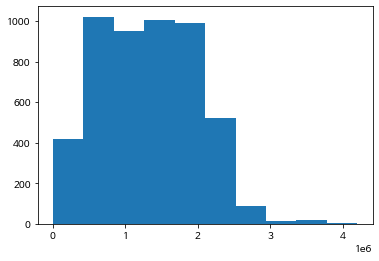

In [ ]:
plt.hist(df_e3['em_g'])
plt.show()

-1.5270393894051901


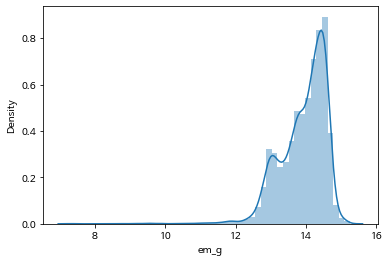

In [ ]:
# 최솟값 확인
df_e3['em_g'].describe()
# 로그 변환
df_log = np.log(df_e3['em_g'])
# skewness 확인
print(df_log.skew())
# KDE plot 출력
sns.distplot(df_log);

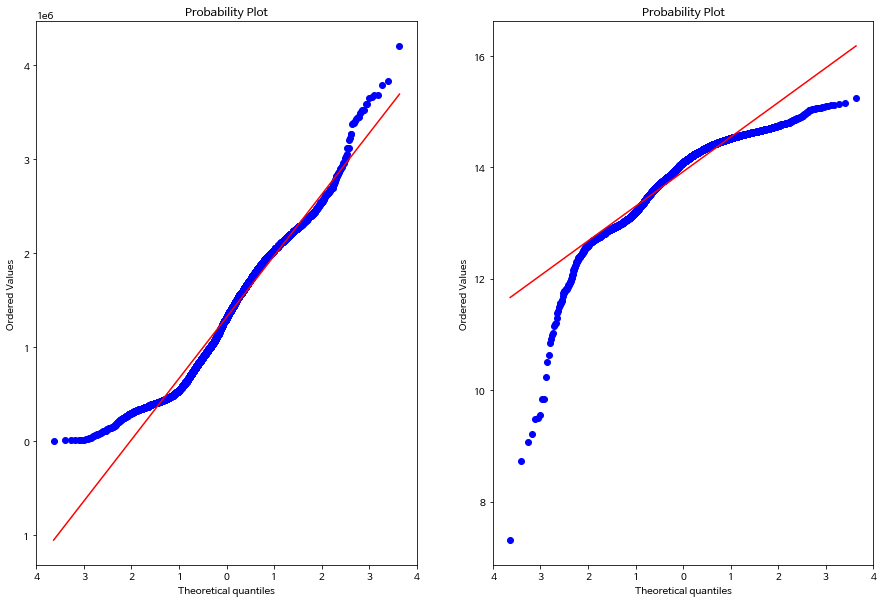

In [ ]:
from scipy import stats
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_e3['em_g'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(df_log, plot=plt)

-0.2883880761397374


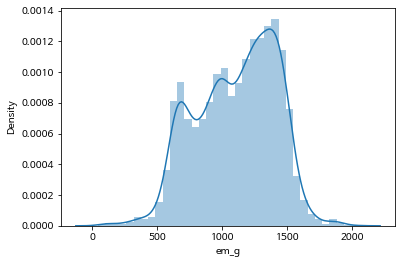

In [ ]:
# 루트 변환
df_root = np.sqrt(df_e3['em_g'])
# skewness 확인
print(df_root.skew())
# KDE plot 출력
sns.distplot(df_root)

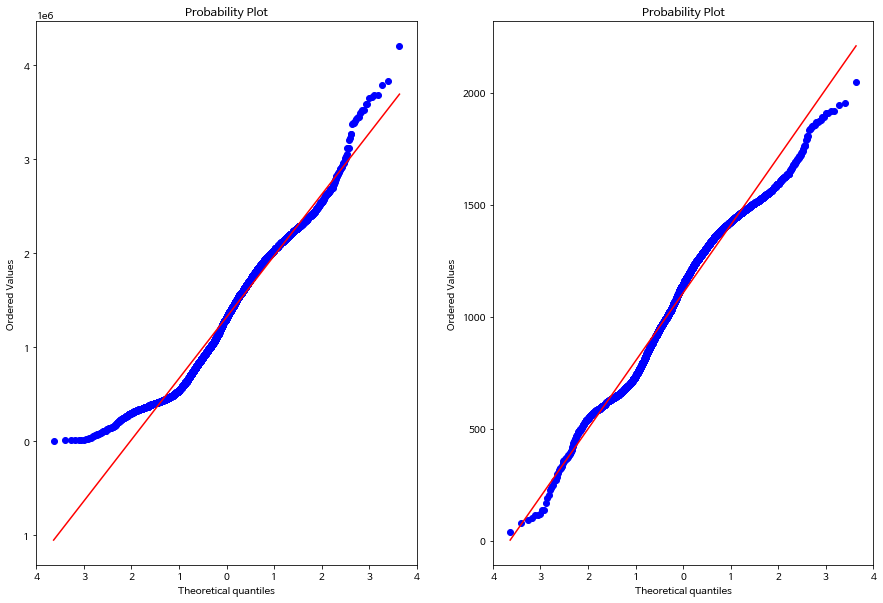

In [ ]:
from scipy import stats
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_e3['em_g'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(df_root, plot=plt)

-0.11821241863604859


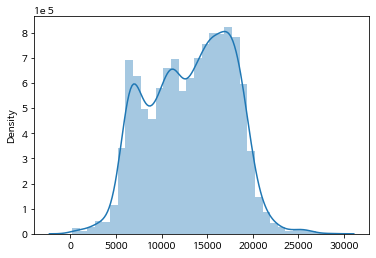

In [ ]:
from scipy import stats
# box-cox 변환
df_boxcox = pd.Series(stats.boxcox(df_e3['em_g'])[0])
# skewness 확인
print(df_boxcox.skew())
# KDE plot 출력
sns.distplot(df_boxcox);

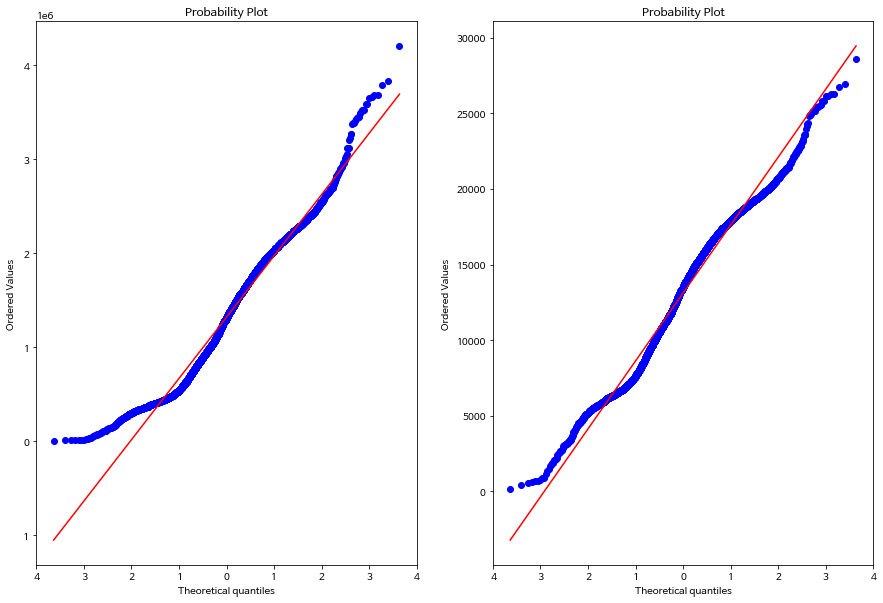

In [ ]:
from scipy import stats
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_e3['em_g'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(df_boxcox, plot=plt)

In [ ]:
df_e5 = df_e3.copy()
df_e5['em_g'] = np.sqrt(df_e5['em_g'])

### 3) stepwise

In [ ]:
## 전진 단계별 선택법
variables = df_e5.drop(['em_g'], axis=1).columns ## 설명 변수 리스트

x_train = df_e5.drop(['em_g'], axis=1)
y_train = df_e5['em_g']

selected_variables3 = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables3))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = x_train[selected_variables3+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y_train,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables3.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables3) > 0:
            selected_X = x_train[selected_variables3]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y_train,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables3.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y_train,sm.add_constant(x_train[selected_variables3])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables3.copy())
    else:
        break

In [ ]:
len(selected_variables3)

56

In [ ]:
selected_variables3

['em_cnt_mid',
 'em_cnt_high',
 'f_l_j_resd_24',
 'year_2019',
 'n_resd_12_w_01020',
 'n_work_24_m_607080',
 'f_s_visit_12',
 'n_work_12_m_607080',
 'use_amt_d',
 'year_2020',
 'year_2021',
 'foreign_pop',
 'resid_reg_pop',
 'n_resd_24_w_304050',
 'month_7',
 'month_8',
 '일강수량',
 'n_work_12_w_607080',
 'use_amt_m',
 'month_11',
 'n_resd_24_m_01020',
 'n_e_visit_24_w_304050',
 'n_e_visit_12_w_304050',
 'n_visit_12_w_607080',
 'n_visit_12_m_304050',
 '평균풍속',
 'n_e_visit_12_m_607080',
 'n_e_visit_24_m_607080',
 'n_resd_12_w_607080',
 'n_work_24_w_01020',
 'n_work_24_m_304050',
 'f_l_e_work_24',
 'month_4',
 'use_amt_k',
 'n_visit_24_w_01020',
 'n_visit_12_w_304050',
 'month_12',
 'n_e_visit_12_w_01020',
 'month_6',
 'use_amt_v',
 'n_visit_24_w_304050',
 'n_visit_24_m_01020',
 'n_visit_12_m_01020',
 'f_l_j_visit_12',
 'n_e_work_12_w_304050',
 'n_e_work_24_w_304050',
 'n_work_24_m_01020',
 'n_work_12_m_01020',
 'n_work_12_w_304050',
 'n_resd_12_m_304050',
 'n_e_work_24_m_304050',
 'n_e_work

### 4) 변수중요도 확인 : Random Forest

In [ ]:
X_train_rf3 = df_e5[selected_variables3]
y_train_rf3 = df_e5['em_g']

rf3 = RandomForestRegressor(max_depth=8, random_state=531, n_estimators=150)
rf3.fit(X_train_rf3, y_train_rf3)
featureImportance = rf3.feature_importances_

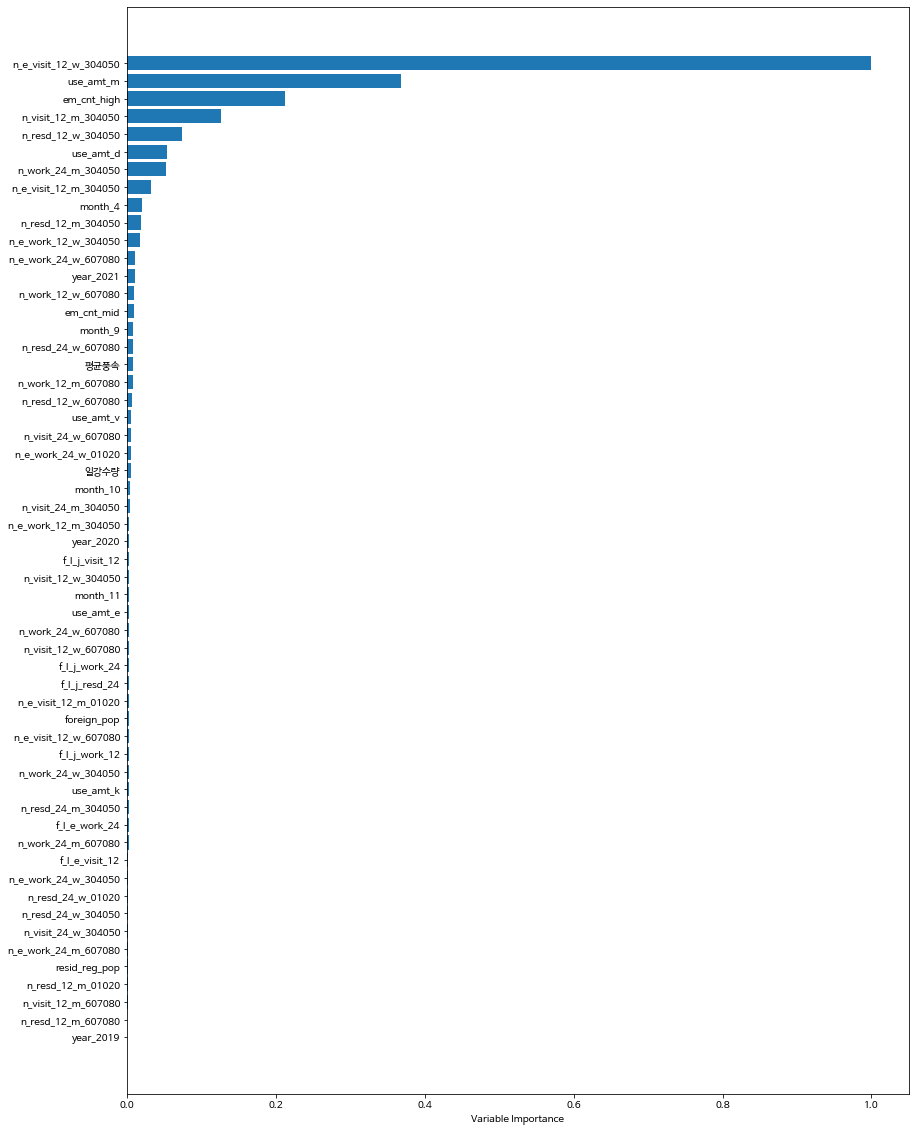

In [ ]:
#가장 높은 중요도 기준으로 스케일링
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,20)

featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plot.barh(barPos, featureImportance[sorted_idx], align='center')
plot.yticks(barPos, X_train_rf0.columns[sorted_idx])
plot.xlabel('Variable Importance')
plot.show()

### 5) 변수중요도 확인 : xgboost

In [ ]:
X_train_xg3 = df_e5[selected_variables3]
y_train_xg3 = df_e5['em_g']

dtrain3 = xgb.DMatrix(data=X_train_xg3, label = y_train_xg3)

In [ ]:
params3 = {'max_depth' : 8,
         'eta' : 0.01, 
         'objective' : 'reg:squarederror',
         'eval_metric' : 'rmse'}

num_rounds3 = 400

In [ ]:
xgb_model3 = xgb.train(params = params3, dtrain=dtrain3, num_boost_round=num_rounds3)

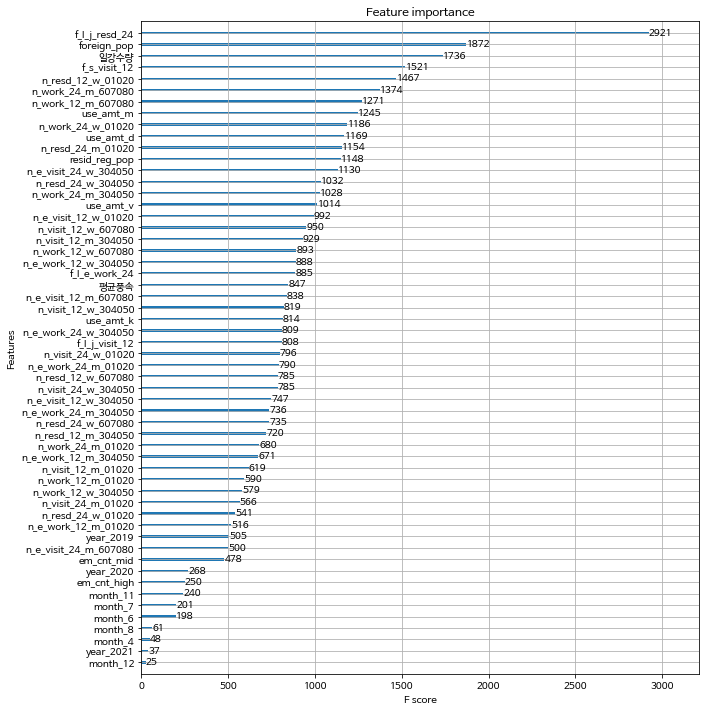

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model3, ax=ax)

In [ ]:
score = pd.DataFrame(xgb_model1.get_score(importance_type='weight'),index=[0]).T
score.columns = ['fscore']
score2 = score.sort_values(by=['fscore'], axis=0, ascending=False)
score3 = score2.iloc[:-8,:].index
score3

Index(['em_cnt', 'f_s_visit_24', 'f_l_j_visit_24', 'resid_reg_pop',
       'use_amt_d', 'n_visit_24_m_2030', 'use_amt_v', 'use_amt_m', '평균풍속',
       'n_resd_24_m_010', 'n_work_24_m_2030', 'f_l_e_visit_24',
       'n_work_24_w_2030', 'n_work_24_m_4050', 'n_resd_12_w_2030',
       'n_visit_24_m_010', 'n_e_visit_12', 'n_visit_12_w_4050', 'month_9',
       'n_work_12_w_4050', 'n_visit_12_m_607080', 'n_visit_24_w_607080',
       'n_work_24_w_4050', 'n_e_work_24', 'n_e_visit_24', 'n_visit_12_m_4050',
       'n_resd_12_w_4050', 'n_visit_24_m_4050', 'use_amt_e', 'n_work_24_m_010',
       'n_resd_24_w_010', 'n_resd_24_m_4050', 'n_work_12_m_2030',
       'n_visit_12_w_607080', 'n_visit_12_m_2030', 'n_work_12_w_2030',
       'n_resd_12_m_2030', 'month_10', '일강수량', 'n_visit_24_w_2030', '최대풍속방향',
       'n_resd_24_w_4050'],
      dtype='object')

### 6) 변수중요도 확인 : Decision Tree Regressor

In [ ]:
X_train_dtr3 = df_e5[selected_variables3]
y_train_dtr3 = df_e5['em_g']

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt3 = DecisionTreeRegressor(max_depth = 7)

dt3.fit(X_train_dtr3, y_train_dtr3)
print(dt3.score(X_train_dtr3, y_train_dtr3))

feature_importance3 = pd.DataFrame(dt3.feature_importances_.reshape((-1, 1)), columns=['feature_importance'], index=X_train_dtr3.columns)
fi3 = feature_importance3.sort_values(by=['feature_importance'], axis=0, ascending=False)
fi3

0.8372100053687103


,feature_importance
em_cnt_mid,0.516340
foreign_pop,0.147098
em_cnt_high,0.111558
f_s_visit_12,0.065538
n_resd_24_w_607080,0.056318
n_work_24_w_01020,0.023347
year_2019,0.022030
n_resd_12_m_304050,0.008255
month_11,0.006841
f_l_j_resd_24,0.005803


In [ ]:
# 0.0001 이상인 변수들만 선택
fi3.iloc[:23,:].index

Index(['em_cnt_mid', 'foreign_pop', 'em_cnt_high', 'f_s_visit_12',
       'n_resd_24_w_607080', 'n_work_24_w_01020', 'year_2019',
       'n_resd_12_m_304050', 'month_11', 'f_l_j_resd_24',
       'n_e_visit_12_w_01020', '일강수량', 'n_visit_12_w_304050',
       'n_e_visit_12_w_304050', 'f_l_j_visit_12', 'n_work_24_m_607080',
       'resid_reg_pop', 'n_e_visit_24_w_304050', 'n_resd_24_w_304050',
       'n_visit_12_w_607080', 'n_visit_24_m_01020', 'month_8', 'use_amt_k'],
      dtype='object')

### 7) regression
Decicion Tree 기반으로 선택된 변수들로 모델링

In [ ]:
model31 = ols('em_g ~ em_cnt_mid+ foreign_pop+ em_cnt_high+ f_s_visit_12+ n_resd_24_w_607080+ n_work_24_w_01020+ year_2019+ n_resd_12_m_304050+ month_11+ f_l_j_resd_24+ n_e_visit_12_w_01020+ 일강수량+ n_visit_12_w_304050+ n_e_visit_12_w_304050+ f_l_j_visit_12+ n_work_24_m_607080+ resid_reg_pop+ n_e_visit_24_w_304050+ n_resd_24_w_304050+ n_visit_12_w_607080+ n_visit_24_m_01020+ month_8+ use_amt_k', df_e5)
res31 = model31.fit()
res31.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   em_g   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     596.2
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:57:48   Log-Likelihood:                -32644.
No. Observations:                5033   AIC:                         6.534e+04
Df Residuals:                    5009   BIC:                         6.549e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               857.1372      6.224    137.716      0.000     844.936     869.339
em_cnt_mid              332.8676      6.402     51.993      0.000     320.317     345.419
foreign_pop             158.2259     10.106     15.656      0.000     138.413     178.039
em_cnt_high             514.4123     18.548     27.734      0.000     478.050     550.775
f_s_visit_12            -18.3949      5.055     -3.639      0.000     -28.304      -8.486
n_resd_24_w_607080      247.4070      8.094     30.566      0.000     231.539     263.275
n_work_24_w_01020       -17.5387      2.491     -7.041      0.000     -22.422     -12.655
year_2019                98.3269      6.801     14.459      0.000      84.995     111.659
n_resd_12_m_304050     -119.0338     12.905     -9.224      0.000    -144.333     -93.735
month_11                -85.7828      9.028     -9.501      0.000    -103.482     -68.083
f_l_j_resd_24           -58.4947      4.473    -13.076      0.000     -67.265     -49.725
n_e_visit_12_w_01020     32.3642      5.518      5.865      0.000      21.546      43.182
일강수량                     -0.4964      0.123     -4.035      0.000      -0.738      -0.255
n_visit_12_w_304050      59.0155      8.645      6.827      0.000      42.068      75.963
n_e_visit_12_w_304050  -173.2617     16.567    -10.458      0.000    -205.740    -140.783
f_l_j_visit_12            0.5908      4.688      0.126      0.900      -8.600       9.782
n_work_24_m_607080       56.7013      4.004     14.161      0.000      48.851      64.551
resid_reg_pop            39.8465     16.406      2.429      0.015       7.684      72.009
n_e_visit_24_w_304050   150.8018     15.527      9.712      0.000     120.362     181.242
n_resd_24_w_304050      -85.4781      7.774    -10.996      0.000    -100.718     -70.238
n_visit_12_w_607080       2.3317      7.177      0.325      0.745     -11.739      16.403
n_visit_24_m_01020      -20.5263      3.817     -5.377      0.000     -28.010     -13.043
month_8                  32.6241      9.961      3.275      0.001      13.097      52.152
use_amt_k                 2.7652      3.762      0.735      0.462      -4.611      10.141
==============================================================================
Omnibus:                      128.841   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              265.590
Skew:                           0.147   Prob(JB):                     2.13e-58
Kurtosis:                       4.086   Cond. No.                         222.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model31.exog, i)} 
             for i, column in enumerate(model31.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,em_cnt_mid,2.026431
1,foreign_pop,4.685378
2,em_cnt_high,1.527433
3,f_s_visit_12,2.414337
4,n_resd_24_w_607080,9.619810
5,n_work_24_w_01020,1.425123
6,year_2019,1.679440
7,n_resd_12_m_304050,16.672136
8,month_11,1.139611
9,f_l_j_resd_24,2.406884


### 8) regression 2
p-value 0.1 이상 변수 삭제

In [ ]:
model32 = ols('em_g ~ em_cnt_mid+ foreign_pop+ em_cnt_high+ f_s_visit_12+ n_resd_24_w_607080+ n_work_24_w_01020+ year_2019+ n_resd_12_m_304050+ month_11+ f_l_j_resd_24+ n_e_visit_12_w_01020+ 일강수량+ n_visit_12_w_304050+ n_e_visit_12_w_304050+ n_work_24_m_607080+ resid_reg_pop+ n_e_visit_24_w_304050+ n_resd_24_w_304050+ n_visit_24_m_01020+ month_8', df_e5)
res32 = model32.fit()
res32.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   em_g   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     685.9
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:58:54   Log-Likelihood:                -32645.
No. Observations:                5033   AIC:                         6.533e+04
Df Residuals:                    5012   BIC:                         6.547e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               857.0233      6.174    138.822      0.000     844.920     869.126
em_cnt_mid              332.6580      6.381     52.129      0.000     320.147     345.168
foreign_pop             158.0598     10.049     15.729      0.000     138.359     177.760
em_cnt_high             514.0468     18.510     27.772      0.000     477.760     550.334
f_s_visit_12            -18.4502      5.016     -3.678      0.000     -28.285      -8.616
n_resd_24_w_607080      248.2446      7.624     32.561      0.000     233.298     263.191
n_work_24_w_01020       -17.5533      2.485     -7.064      0.000     -22.425     -12.682
year_2019                98.7546      6.279     15.727      0.000      86.445     111.065
n_resd_12_m_304050     -120.8736     12.655     -9.552      0.000    -145.682     -96.065
month_11                -85.5804      9.010     -9.498      0.000    -103.244     -67.917
f_l_j_resd_24           -58.0542      4.422    -13.128      0.000     -66.724     -49.385
n_e_visit_12_w_01020     32.4064      5.492      5.901      0.000      21.641      43.172
일강수량                     -0.5079      0.121     -4.206      0.000      -0.745      -0.271
n_visit_12_w_304050      61.8666      6.810      9.085      0.000      48.517      75.217
n_e_visit_12_w_304050  -171.8150     16.360    -10.502      0.000    -203.887    -139.743
n_work_24_m_607080       57.0704      3.964     14.395      0.000      49.298      64.842
resid_reg_pop            44.3996     15.420      2.879      0.004      14.170      74.630
n_e_visit_24_w_304050   149.9556     15.106      9.927      0.000     120.341     179.571
n_resd_24_w_304050      -85.4956      7.636    -11.196      0.000    -100.466     -70.526
n_visit_24_m_01020      -21.2308      3.496     -6.073      0.000     -28.084     -14.377
month_8                  32.9354      9.938      3.314      0.001      13.452      52.418
==============================================================================
Omnibus:                      128.726   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              265.888
Skew:                           0.146   Prob(JB):                     1.83e-58
Kurtosis:                       4.087   Cond. No.                         219.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model32.exog, i)} 
             for i, column in enumerate(model32.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,em_cnt_mid,2.014289
1,foreign_pop,4.634667
2,em_cnt_high,1.521823
3,f_s_visit_12,2.379147
4,n_resd_24_w_607080,8.538439
5,n_work_24_w_01020,1.418873
6,year_2019,1.432464
7,n_resd_12_m_304050,16.039096
8,month_11,1.135453
9,f_l_j_resd_24,2.353097


### 9) regression 3
vif이 10 이상인 변수 삭제

In [ ]:
model33 = ols('em_g ~ em_cnt_mid+ foreign_pop+ em_cnt_high+ f_s_visit_12+ n_resd_24_w_607080+ n_work_24_w_01020+ year_2019+ month_11+ f_l_j_resd_24+ 일강수량+ n_visit_12_w_304050+ n_work_24_m_607080+ n_e_visit_24_w_304050+ n_resd_24_w_304050+ n_visit_24_m_01020+ month_8', df_e5)
res33 = model33.fit()
res33.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   em_g   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     789.4
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:04:17   Log-Likelihood:                -32797.
No. Observations:                5033   AIC:                         6.563e+04
Df Residuals:                    5016   BIC:                         6.574e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               895.5169      4.481    199.830      0.000     886.731     904.302
em_cnt_mid              334.2519      6.218     53.759      0.000     322.063     346.441
foreign_pop              95.2170      7.867     12.104      0.000      79.795     110.639
em_cnt_high             522.8689     18.964     27.572      0.000     485.691     560.046
f_s_visit_12            -18.9455      4.696     -4.035      0.000     -28.151      -9.740
n_resd_24_w_607080      224.9777      7.335     30.672      0.000     210.598     239.357
n_work_24_w_01020       -21.5700      2.389     -9.030      0.000     -26.253     -16.887
year_2019               112.2006      6.314     17.769      0.000      99.822     124.579
month_11                -95.5217      9.143    -10.447      0.000    -113.446     -77.597
f_l_j_resd_24           -76.7388      4.300    -17.848      0.000     -85.168     -68.310
일강수량                     -0.8593      0.121     -7.106      0.000      -1.096      -0.622
n_visit_12_w_304050      14.4428      6.128      2.357      0.018       2.429      26.457
n_work_24_m_607080       72.0552      3.926     18.355      0.000      64.359      79.751
n_e_visit_24_w_304050    22.0899      4.243      5.206      0.000      13.771      30.409
n_resd_24_w_304050      -99.5090      4.414    -22.545      0.000    -108.162     -90.856
n_visit_24_m_01020      -17.4256      3.376     -5.161      0.000     -24.045     -10.807
month_8                  41.9858      9.962      4.215      0.000      22.456      61.515
==============================================================================
Omnibus:                      126.593   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              299.891
Skew:                           0.031   Prob(JB):                     7.58e-66
Kurtosis:                       4.194   Cond. No.                         173.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model33.exog, i)} 
             for i, column in enumerate(model33.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,em_cnt_mid,1.801519
1,foreign_pop,2.675798
2,em_cnt_high,1.504970
3,f_s_visit_12,1.963906
4,n_resd_24_w_607080,7.445906
5,n_work_24_w_01020,1.235286
6,year_2019,1.364638
7,month_11,1.101613
8,f_l_j_resd_24,2.095758
9,일강수량,1.087284


## * 서귀포시_중(df_sm)

In [ ]:
df_sm2 = df_sm.drop(['emd_nm','base_date'],axis=1)

In [ ]:
df_sm2 = df_sm2.reset_index().drop(['index'],axis=1)
df_sm2

,em_cnt,em_g,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,...,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,year,month
0,mid,1717700.0,13473,178,20721.6892,1355.9920,10670.7833,35419.3549,2508.0803,17505.8349,14002.6447,349.1461,5923.1258,18730.8122,964.5996,10518.1753,31365.3617,3629.9768,19028.1335,12413.5799,605.2522,5098.7552,19821.0889,1268.0891,7270.7548,35836.6346,1737.5119,11007.5430,13945.8359,295.5239,3814.3825,17456.2318,881.7619,8100.8011,32944.4378,2526.5763,12213.6170,12058.3487,575.6272,3298.4777,...,0.0,222.9020,3734.3988,0.0,243.1905,8406.8604,0.0,472.0668,10356.6948,0.0,333.3452,2937.3150,160.4398,15.7894,195.6597,193.8638,15.8409,157.8745,0.0,8.2025,69.6206,0.0,8.1928,95.3535,87.4845,102.5191,19997939.0,37971731.0,396728.0,3533285.0,10642229.0,0,6.1,0.0,180.0,1.5,58.9,1020.3,2018,1
1,mid,1765600.0,13160,244,11792.1258,798.9118,8019.2157,17277.0336,1029.7199,12641.8194,6653.1872,307.0630,5622.5555,12217.6886,659.1016,6440.7674,20009.8601,1308.1045,15096.7545,7777.9522,351.6254,3554.4324,10906.9479,559.8661,5660.6275,17693.3368,928.0131,8297.4944,7031.7135,203.6612,3685.9612,11200.0098,438.2669,4948.7292,21229.6774,969.4358,9812.9345,7935.6639,242.0118,2332.4344,...,0.0,61.7376,2019.9574,0.0,102.6523,6755.0993,0.0,139.8883,6974.9300,0.0,48.2472,1470.6449,168.3786,7.9066,162.9279,202.4254,0.0000,132.1643,0.0,0.0000,56.2507,0.0,0.0000,57.9527,65.4224,88.6644,19312994.0,39231391.0,162030.0,3299471.0,9661751.0,0,6.1,0.0,180.0,1.5,58.9,1020.3,2018,1
2,high,4165050.0,22693,1266,30472.5224,1594.1883,8500.9998,44809.0203,2822.9047,15947.4975,20702.1182,718.3539,6467.9281,31891.6784,3475.9664,10224.3991,44038.8435,3421.3584,16777.0880,12010.5240,799.3599,5819.0870,27606.5250,1406.6116,7066.9258,46280.2362,2356.6976,11173.8023,20621.8764,823.5603,4046.0810,28939.3705,2737.8710,7916.2878,46336.2309,2428.9672,12097.2684,12345.0533,536.9128,4037.5758,...,0.0,31.0826,1850.1559,0.0,64.4770,4685.2582,0.0,420.1233,4364.9131,0.0,254.4013,1211.8650,356.5485,59.4796,212.0978,411.2173,53.3001,152.8606,0.0,7.9076,56.2283,0.0,7.9405,66.8592,99.1674,95.1525,39230900.0,69274797.0,421916.0,5567204.0,14468297.0,0,6.1,0.0,180.0,1.5,58.9,1020.3,2018,1
3,mid,1712150.0,10637,127,12010.5932,529.8844,5516.7649,12600.9923,954.8304,7079.4437,6651.9908,187.1809,2936.2971,11078.0052,267.7416,5983.9460,13169.1007,534.8467,7877.5823,3866.7483,320.3538,2207.1840,11206.1503,473.7913,4299.5459,13270.1329,648.9988,5465.1363,6094.7192,180.2418,2045.1980,9724.0974,211.8594,4438.8862,14540.8225,337.5159,5547.3019,4264.3160,316.4414,1745.7155,...,0.0,0.0000,913.9005,0.0,16.5268,1773.7426,0.0,172.4736,2362.4912,0.0,0.0000,803.1089,56.2650,0.0000,83.5079,97.6701,0.0000,78.3928,0.0,9.2878,57.8778,0.0,9.2919,67.2820,99.3307,115.9763,24167020.0,35267744.0,169395.0,2452005.0,5608693.0,0,6.1,0.0,180.0,1.5,58.9,1020.3,

### 1) 표준화(robust)
이상치라고 표현되지만 이상치로 볼 수 없는 데이터가 많아 이를 보완할 수 있는 robust 기법으로 표준화 진행

In [ ]:
sm_date_no = df_sm2.drop(['em_cnt','year','month','em_g'], axis=1)
sm_date_yes = df_sm2[['em_cnt','year','month','em_g']]

In [ ]:
# robust
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
print(robustScaler.fit(sm_date_no))
sm_date_no2 = pd.DataFrame(robustScaler.transform(sm_date_no))
sm_date_no2.columns = sm_date_no.columns
sm_date_no2

,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,n_e_resd_12_w_01020,n_e_work_12_w_01020,...,n_e_work_24_w_304050,n_e_visit_24_w_304050,n_e_resd_24_w_607080,n_e_work_24_w_607080,n_e_visit_24_w_607080,n_e_resd_24_m_01020,n_e_work_24_m_01020,n_e_visit_24_m_01020,n_e_resd_24_m_304050,n_e_work_24_m_304050,n_e_visit_24_m_304050,n_e_resd_24_m_607080,n_e_work_24_m_607080,n_e_visit_24_m_607080,f_l_j_resd_12,f_l_j_work_12,f_l_j_visit_12,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압
0,0.927526,-0.041237,1.151152,0.374587,1.406551,1.971964,0.232280,1.307322,1.579197,-0.306455,0.893059,1.080649,0.104880,1.477606,1.584594,0.586867,0.912603,1.287430,0.463706,0.543899,1.168405,1.332156,1.291457,1.729647,1.442793,1.433831,1.499450,0.252969,1.213224,1.037753,0.690242,1.519695,1.373904,2.084907,1.250765,1.039062,2.199257,0.969637,0.0,0.349271,...,1.164851,1.932342,0.0,1.701442,1.533062,0.0,0.728083,1.632726,0.0,1.295355,1.275237,0.0,1.647834,1.065754,0.125803,-0.173581,0.509142,0.210304,-0.002076,0.445406,0.0,1.186782,-0.349090,0.0,1.154338,-0.018001,0.322904,0.443805,0.748546,0.881586,-0.099000,-0.196006,1.047811,0.000000,-1.000000,0.0,0.0000,0.000000,-0.725883,0.892857
1,0.892096,0.347570,0.483309,0.016062,0.853044,0.659685,-0.459692,0.635479,0.217140,-0.395066,0.786039,0.535781,-0.130496,0.475928,0.778514,-0.221323,0.470284,0.446187,-0.130715,-0.032063,0.461578,0.226715,0.835901,0.550661,0.278399,0.883835,0.222526,-0.036531,1.139852,0.486857,-0.001930,0.572138,0.663778,0.183599,0.785679,0.347559,0.362728,0.352145,0.0,1.288349,...,1.162833,0.995367,0.0,0.190681,0.510578,0.0,0.147025,1.166239,0.0,-0.066948,0.591910,0.0,-0.266108,0.105177,0.189474,-0.481553,0.167006,0.273252,-0.755507,0.136424,0.0,0.000000,-0.489329,0.0,0.000000,-0.429657,0.154284,0.332051,0.703356,0.929971,-0.298367,-0.226056,0.907300,0.000000,-1.000000,0.0,0.0000,0.000000,-0.725883,0.892857
2,1.971192,6.368189,1.880418,0.527886,0.953615,2.651142,0.379639,1.092076,2.820794,0.470952,1.087040,2.181646,2.039810,1.405435,2.484231,0.514252,0.659338,1.214286,0.918634,0.812551,1.785733,1.548371,1.233787,2.408292,2.333438,1.467573,2.732404,1.917046,1.345603,2.048910,3.587110,1.464228,2.185688,1.965724,1.228225,1.087151,1.986137,1.442065,0.0,0.816730,...,0.620175,0.219588,0.0,-0.096680,0.409309,0.0,-0.010811,0.581679,0.0,1.082329,0.064524,0.0,1.117862,-0.064307,1.698636,1.533344,0.680964,1.808354,1.779572,0.385150,0.0,1.144114,-0.489564,0.0,1.118790,-0.331627,0.412196,0.384385,2.017450,2.083970,-0.077604,0.065388,1.596122,0.000000,-1.000000,0.0,0.0000,0.000000,-0.725883,0.892857
3,0.606503,-0.341679,0.499648,-0.157079,0.330664,0.321456,-0.494745,-0.132826,0.216919,-0.647491,-0.170422,0.440438,-0.432027,0.363702,0.292918,-0.490476,-0.341945,-0.263592,-0.204006,-0.534525,0.485303,0.092364,0.450808,0.263233,-0.122939,0.309017,0.049479,-0.110336,0.202415,0.356895,-0.355288,0.418872,0.258313,-0.587991,-0.040706,-0.268241,0.772457,-0.022883,0.0,-0.192429,...,-0.167012,-0.276034,0.0,-0.388050,-0.149069,0.0,-0.209062,-0.240585,0.0,0.066688,-0.340090,0.0,-0.590005,-0.332017,-0.709701,-0.790454,-0.663148,-0.496941,-0.755507,-0.509796,0.0,1.343

In [ ]:
df_sm3 = pd.concat([sm_date_no2,sm_date_yes],axis=1)

In [ ]:
df_sm3 = pd.get_dummies(df_sm3,drop_first=True)
df_sm3

,resid_reg_pop,foreign_pop,n_resd_12_w_01020,n_work_12_w_01020,n_visit_12_w_01020,n_resd_12_w_304050,n_work_12_w_304050,n_visit_12_w_304050,n_resd_12_w_607080,n_work_12_w_607080,n_visit_12_w_607080,n_resd_12_m_01020,n_work_12_m_01020,n_visit_12_m_01020,n_resd_12_m_304050,n_work_12_m_304050,n_visit_12_m_304050,n_resd_12_m_607080,n_work_12_m_607080,n_visit_12_m_607080,n_resd_24_w_01020,n_work_24_w_01020,n_visit_24_w_01020,n_resd_24_w_304050,n_work_24_w_304050,n_visit_24_w_304050,n_resd_24_w_607080,n_work_24_w_607080,n_visit_24_w_607080,n_resd_24_m_01020,n_work_24_m_01020,n_visit_24_m_01020,n_resd_24_m_304050,n_work_24_m_304050,n_visit_24_m_304050,n_resd_24_m_607080,n_work_24_m_607080,n_visit_24_m_607080,n_e_resd_12_w_01020,n_e_work_12_w_01020,...,f_l_j_resd_24,f_l_j_work_24,f_l_j_visit_24,f_l_e_resd_12,f_l_e_work_12,f_l_e_visit_12,f_l_e_resd_24,f_l_e_work_24,f_l_e_visit_24,f_s_visit_12,f_s_visit_24,use_amt_k,use_amt_m,use_amt_d,use_amt_v,use_amt_e,covid19_cnt,평균기온,일강수량,최대풍속방향,평균풍속,평균상대습도,평균현지기압,em_g,em_cnt_mid,em_cnt_high,year_2019,year_2020,year_2021,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,0.927526,-0.041237,1.151152,0.374587,1.406551,1.971964,0.232280,1.307322,1.579197,-0.306455,0.893059,1.080649,0.104880,1.477606,1.584594,0.586867,0.912603,1.287430,0.463706,0.543899,1.168405,1.332156,1.291457,1.729647,1.442793,1.433831,1.499450,0.252969,1.213224,1.037753,0.690242,1.519695,1.373904,2.084907,1.250765,1.039062,2.199257,0.969637,0.0,0.349271,...,0.210304,-0.002076,0.445406,0.0,1.186782,-0.349090,0.0,1.154338,-0.018001,0.322904,0.443805,0.748546,0.881586,-0.099000,-0.196006,1.047811,0.000000,-1.000000,0.0,0.0000,0.000000,-0.725883,0.892857,1717700.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.892096,0.347570,0.483309,0.016062,0.853044,0.659685,-0.459692,0.635479,0.217140,-0.395066,0.786039,0.535781,-0.130496,0.475928,0.778514,-0.221323,0.470284,0.446187,-0.130715,-0.032063,0.461578,0.226715,0.835901,0.550661,0.278399,0.883835,0.222526,-0.036531,1.139852,0.486857,-0.001930,0.572138,0.663778,0.183599,0.785679,0.347559,0.362728,0.352145,0.0,1.288349,...,0.273252,-0.755507,0.136424,0.0,0.000000,-0.489329,0.0,0.000000,-0.429657,0.154284,0.332051,0.703356,0.929971,-0.298367,-0.226056,0.907300,0.000000,-1.000000,0.0,0.0000,0.000000,-0.725883,0.892857,1765600.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.971192,6.368189,1.880418,0.527886,0.953615,2.651142,0.379639,1.092076,2.820794,0.470952,1.087040,2.181646,2.039810,1.405435,2.484231,0.514252,0.659338,1.214286,0.918634,0.812551,1.785733,1.548371,1.233787,2.408292,2.333438,1.467573,2.732404,1.917046,1.345603,2.048910,3.587110,1.464228,2.185688,1.965724,1.228225,1.087151,1.986137,1.442065,0.0,0.816730,...,1.808354,1.779572,0.385150,0.0,1.144114,-0.489564,0.0,1.118790,-0.331627,0.412196,0.384385,2.017450,2.083970,-0.077604,0.065388,1.596122,0.000000,-1.000000,0.0,0.0000,0.000000,-0.725883,0.892857,4165050.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.606503,-0.341679,0.499648,-0.157079,0.330664,0.321456,-0.494745,-0.132826,0.216919,-0.647491,-0.170422,0.440438,-0.432027,0.363702,0.292918,-0.490476,-0.341945,-0.263592,-0.204006,-0.534525,0.485303,0.092364,0.450808,0.263233,-0.122939,0.309017,0.049479,-0.110336,0.202415,0.356895,-0.355288,0.418872,0.258313,-0.587991,-0.040706,-0.268241,0.772457,-0.022883,0.0,-0.192429,...,-0.496941,-0.755507,-0.509796,0.0,1.343809,-0.472262,0.0,1.309198,-0.326973,0.413444,0.552352,1.023603,0.777723,-0.292111,-0.334970,0.326460,0.000000,-1.000000,0.0,0.0000,0.000000,-0.725883,0.892857,1712150.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.093273,1.991163,-0.234915,-0.496187,-0.519335,-0.257834,-0.803219,-0.650389,-0.356320,-0.801705,-0.673811,-0.231830,-0.579265,-0.556331,-0.287698,-0.584350,-0.659967,-0.387729,-0.882732,-0.811238,-0.256098,-0.647160,-0.524035,-0.296242,-0.849560,-0.421440,-0.419339,-0.482365,-0.464124,-0.259922,-0.571450,-0.505347,-0.317781,-0.651758,-0.681113,-0.461254,-0.629434,-0.561775,0.0,-0.317442,...,-0.414115,-0.7

### 2) em_g 변환(sqrt변환)

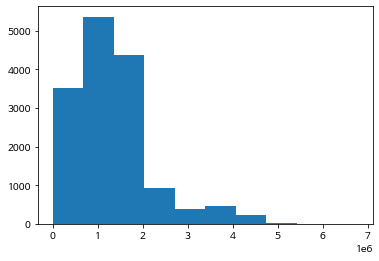

In [ ]:
plt.hist(df_sm3['em_g'])
plt.show()

In [ ]:
df_sm3['em_g'].skew()

1.4860110664806028

-0.8196436011445364


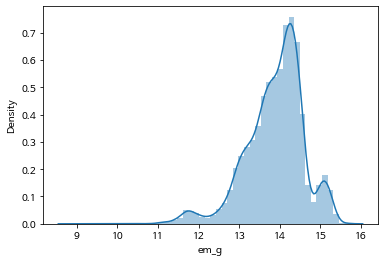

In [ ]:
# 최솟값 확인
df_sm3['em_g'].describe()
# 로그 변환
df_log = np.log(df_sm3['em_g'])
# skewness 확인
print(df_log.skew())
# KDE plot 출력
sns.distplot(df_log);

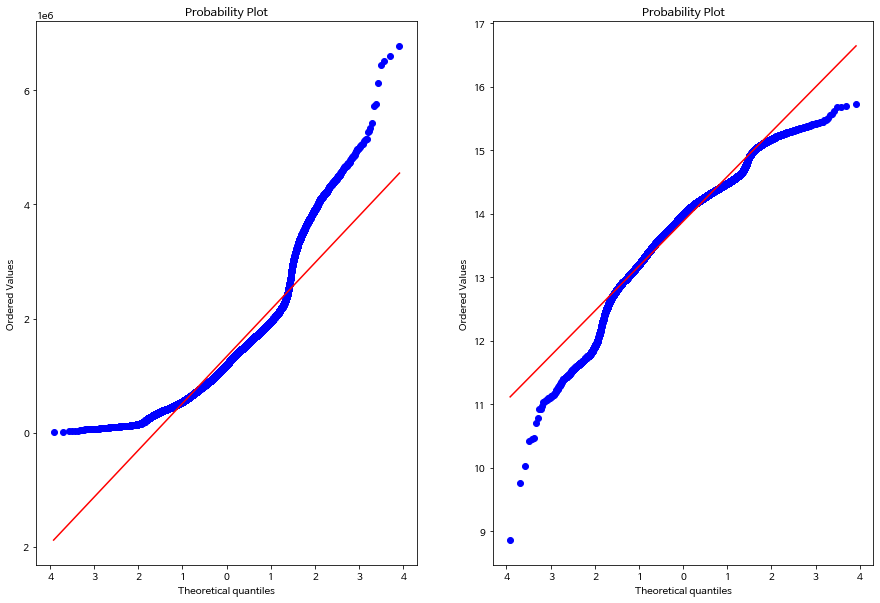

In [ ]:
from scipy import stats
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_sm3['em_g'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(df_log, plot=plt)

0.44375426943444224


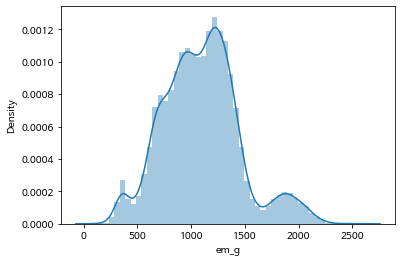

In [ ]:
# 루트 변환
df_root = np.sqrt(df_sm3['em_g'])
# skewness 확인
print(df_root.skew())
# KDE plot 출력
sns.distplot(df_root)

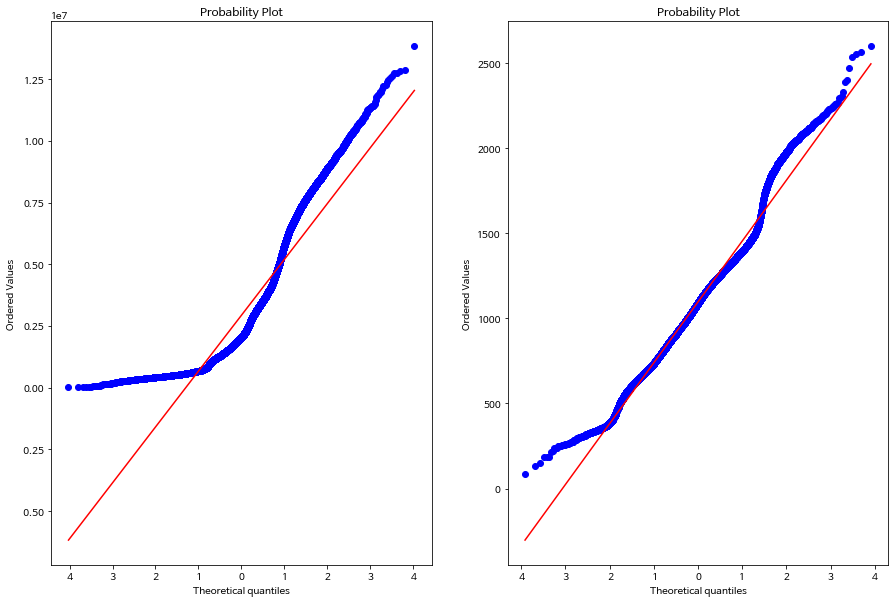

In [ ]:
from scipy import stats
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_jm3['em_g'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(df_root, plot=plt)

-0.02405259989696451


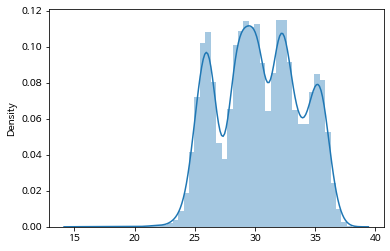

In [ ]:
from scipy import stats
# box-cox 변환
df_boxcox = pd.Series(stats.boxcox(df_jm3['em_g'])[0])
# skewness 확인
print(df_boxcox.skew())
# KDE plot 출력
sns.distplot(df_boxcox);

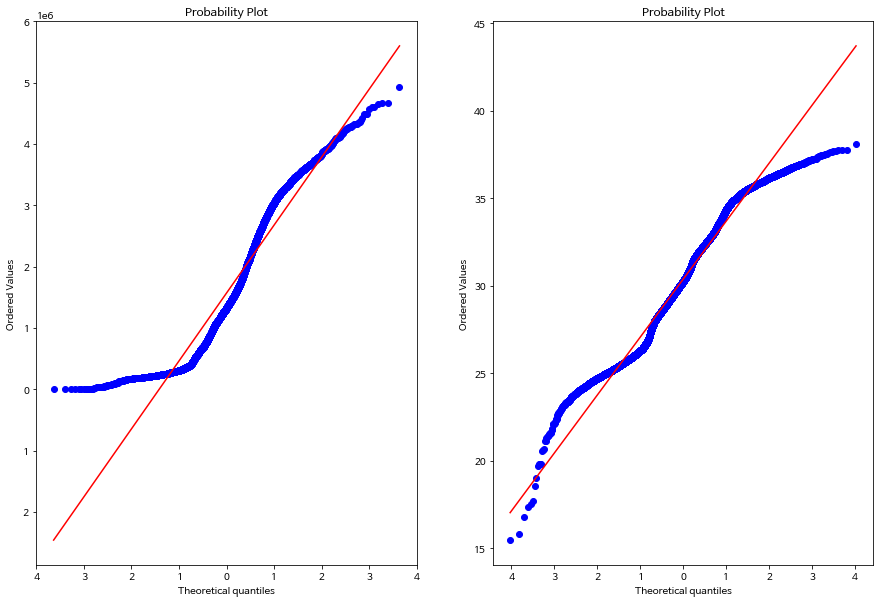

In [ ]:
from scipy import stats
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_w3['em_g'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(df_boxcox, plot=plt)

In [ ]:
df_sm5 = df_sm3.copy()
df_sm5['em_g'] = np.sqrt(df_sm5['em_g'])

### 3) stepwise

In [ ]:
## 전진 단계별 선택법
variables = df_sm5.drop(['em_g'], axis=1).columns ## 설명 변수 리스트

x_train = df_sm5.drop(['em_g'], axis=1)
y_train = df_sm5['em_g']

selected_variables4 = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables4))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = x_train[selected_variables4+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y_train,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables4.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables4) > 0:
            selected_X = x_train[selected_variables4]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y_train,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables4.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y_train,sm.add_constant(x_train[selected_variables4])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables4.copy())
    else:
        break

In [ ]:
len(selected_variables4)

67

In [ ]:
selected_variables4

['em_cnt_high',
 'n_visit_12_w_607080',
 'em_cnt_mid',
 'foreign_pop',
 'f_l_j_work_12',
 'year_2019',
 'year_2020',
 'n_work_24_w_607080',
 'month_4',
 'n_e_work_24_w_607080',
 'n_e_visit_24_m_01020',
 'n_work_24_m_304050',
 'n_e_work_12_w_304050',
 'n_visit_24_w_01020',
 '일강수량',
 'month_3',
 'f_s_visit_12',
 'n_e_work_24_m_607080',
 'n_resd_24_m_607080',
 'n_resd_12_w_607080',
 'n_resd_12_w_01020',
 'n_e_work_24_m_01020',
 'use_amt_v',
 'n_resd_24_m_304050',
 'n_resd_24_w_607080',
 'month_8',
 'f_l_e_visit_24',
 'month_12',
 'n_visit_12_m_607080',
 'f_l_j_work_24',
 'n_resd_24_m_01020',
 'n_resd_12_m_304050',
 '평균상대습도',
 'n_visit_24_m_304050',
 'n_visit_24_m_607080',
 'n_visit_12_w_304050',
 'n_e_work_12_m_607080',
 'n_work_12_m_01020',
 'n_work_24_m_01020',
 'n_work_12_m_607080',
 'use_amt_d',
 'year_2021',
 'month_11',
 'use_amt_m',
 'n_resd_12_m_607080',
 '평균기온',
 'n_e_work_24_m_304050',
 'f_l_j_visit_12',
 'n_visit_12_m_304050',
 'month_5',
 '최대풍속방향',
 'n_resd_24_w_304050',
 'n_r

### 4) 변수중요도 확인 : Random Forest

In [ ]:
X_train_rf4 = df_sm5[selected_variables4]
y_train_rf4 = df_sm5['em_g']

regr4 = RandomForestRegressor(max_depth=10, random_state=531, n_estimators=150)
regr4.fit(X_train_rf4, y_train_rf4)
featureImportance = regr4.feature_importances_

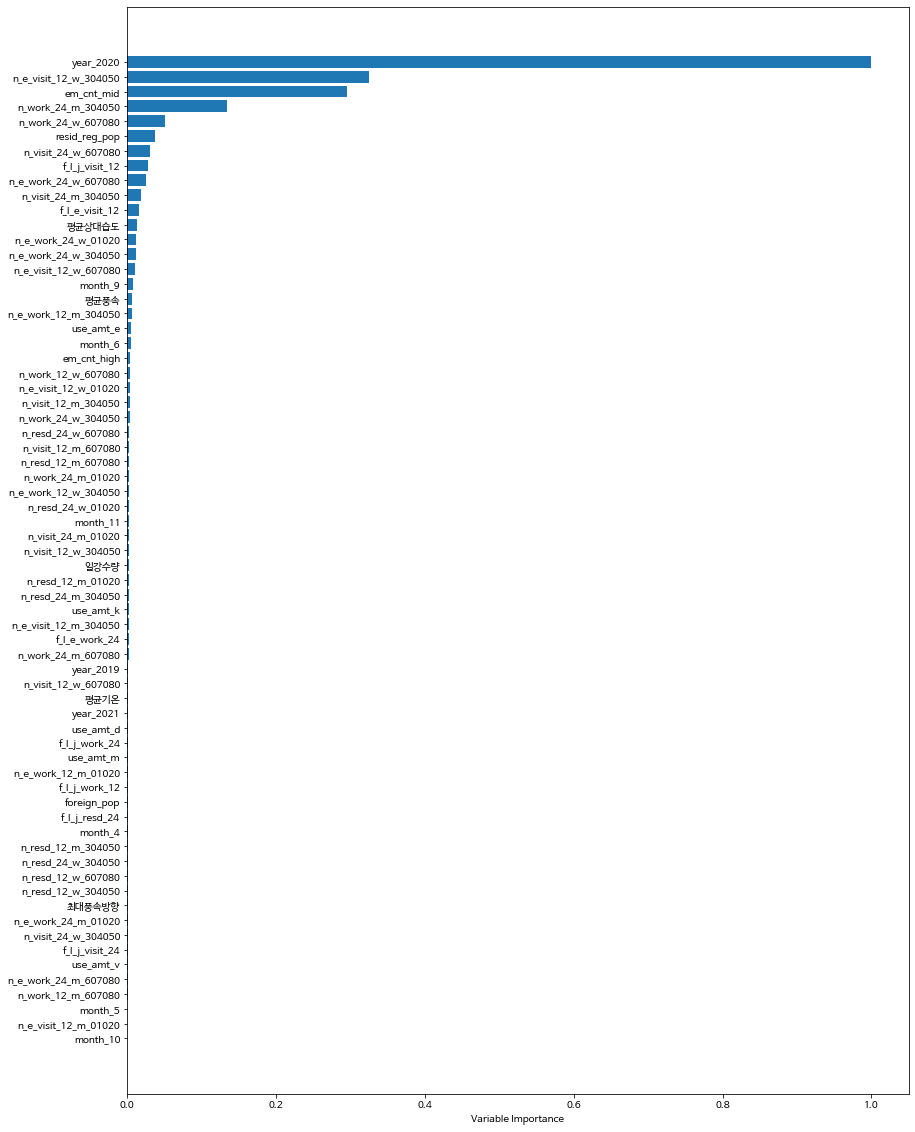

In [ ]:
#가장 높은 중요도 기준으로 스케일링
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,20)

featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plot.barh(barPos, featureImportance[sorted_idx], align='center')
plot.yticks(barPos, X_train_rf0.columns[sorted_idx])
plot.xlabel('Variable Importance')
plot.show()

### 5) 변수중요도 확인 : xgboost

In [ ]:
X_train_xg4 = df_e5[selected_variables4]
y_train_xg4 = df_e5['em_g']

dtrain4 = xgb.DMatrix(data=X_train_xg4, label = y_train_xg4)

In [ ]:
params4 = {'max_depth' : 8,
         'eta' : 0.01, 
         'objective' : 'reg:squarederror',
         'eval_metric' : 'rmse'}

num_rounds4 = 400

In [ ]:
xgb_model4 = xgb.train(params = params4, dtrain=dtrain4, num_boost_round=num_rounds4)

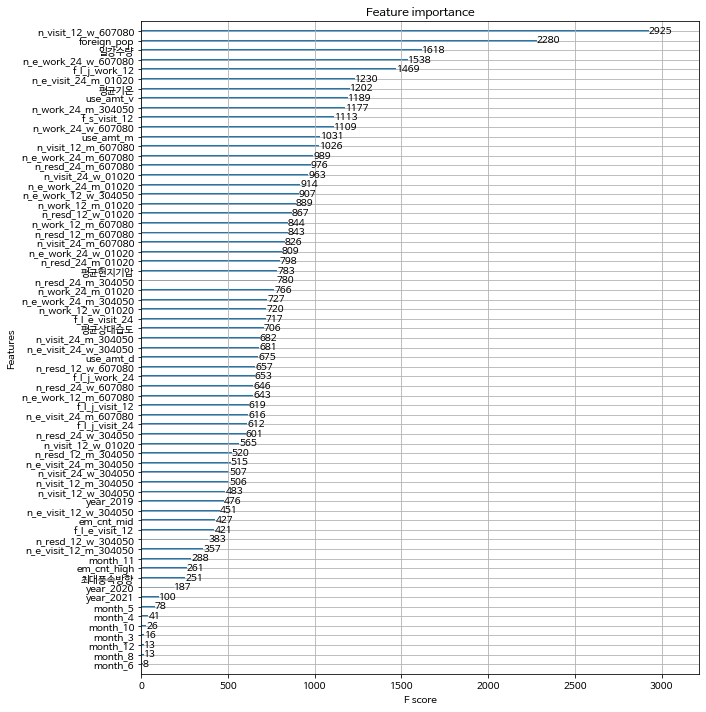

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model4, ax=ax)

In [ ]:
score = pd.DataFrame(xgb_model1.get_score(importance_type='weight'),index=[0]).T
score.columns = ['fscore']
score2 = score.sort_values(by=['fscore'], axis=0, ascending=False)
score3 = score2.iloc[:-8,:].index
score3

Index(['em_cnt', 'f_s_visit_24', 'f_l_j_visit_24', 'resid_reg_pop',
       'use_amt_d', 'n_visit_24_m_2030', 'use_amt_v', 'use_amt_m', '평균풍속',
       'n_resd_24_m_010', 'n_work_24_m_2030', 'f_l_e_visit_24',
       'n_work_24_w_2030', 'n_work_24_m_4050', 'n_resd_12_w_2030',
       'n_visit_24_m_010', 'n_e_visit_12', 'n_visit_12_w_4050', 'month_9',
       'n_work_12_w_4050', 'n_visit_12_m_607080', 'n_visit_24_w_607080',
       'n_work_24_w_4050', 'n_e_work_24', 'n_e_visit_24', 'n_visit_12_m_4050',
       'n_resd_12_w_4050', 'n_visit_24_m_4050', 'use_amt_e', 'n_work_24_m_010',
       'n_resd_24_w_010', 'n_resd_24_m_4050', 'n_work_12_m_2030',
       'n_visit_12_w_607080', 'n_visit_12_m_2030', 'n_work_12_w_2030',
       'n_resd_12_m_2030', 'month_10', '일강수량', 'n_visit_24_w_2030', '최대풍속방향',
       'n_resd_24_w_4050'],
      dtype='object')

### 6) 변수중요도 확인 : Decision Tree Regressor

In [ ]:
X_train_dtr4 = df_e5[selected_variables4]
y_train_dtr4 = df_e5['em_g']

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt4 = DecisionTreeRegressor(max_depth = 8)

dt4.fit(X_train_dtr4, y_train_dtr4)
print(dt4.score(X_train_dtr4, y_train_dtr4))

feature_importance4 = pd.DataFrame(dt4.feature_importances_.reshape((-1, 1)), columns=['feature_importance'], index=X_train_dtr4.columns)
fi4 = feature_importance4.sort_values(by=['feature_importance'], axis=0, ascending=False)
fi4

0.915930043026585


,feature_importance
em_cnt_mid,0.471963
foreign_pop,0.173105
n_e_work_24_m_607080,0.103864
n_resd_24_m_607080,0.062293
em_cnt_high,0.047335
n_resd_24_w_607080,0.041534
f_l_j_work_24,0.019913
year_2019,0.012746
month_11,0.007219
n_e_visit_12_m_304050,0.006101


In [ ]:
# 0.0001 이상인 변수들만 선택
fi4.iloc[:29,:].index

Index(['em_cnt_mid', 'foreign_pop', 'n_e_work_24_m_607080',
       'n_resd_24_m_607080', 'em_cnt_high', 'n_resd_24_w_607080',
       'f_l_j_work_24', 'year_2019', 'month_11', 'n_e_visit_12_m_304050',
       'n_resd_12_w_01020', '일강수량', 'n_visit_12_m_304050',
       'n_visit_12_m_607080', 'n_visit_12_w_304050', 'n_e_visit_24_m_01020',
       '평균기온', 'n_e_work_24_m_304050', 'n_visit_12_w_607080', '평균현지기압',
       'n_e_visit_24_m_304050', 'n_e_work_24_m_01020', 'f_s_visit_12',
       'n_resd_12_m_607080', 'f_l_j_visit_24', 'n_resd_24_w_304050',
       'n_visit_24_m_304050', 'n_e_work_12_m_607080', 'n_resd_24_m_304050'],
      dtype='object')

### 7) regression
Decicion Tree 기반으로 선택된 변수들로 모델링

In [ ]:
model41 = ols('em_g ~ em_cnt_mid+ foreign_pop+ n_e_work_24_m_607080+ n_resd_24_m_607080+ em_cnt_high+ n_resd_24_w_607080+ f_l_j_work_24+ year_2019+ month_11+ n_e_visit_12_m_304050+ n_resd_12_w_01020+ 일강수량+ n_visit_12_m_304050+ n_visit_12_m_607080+ n_visit_12_w_304050+ n_e_visit_24_m_01020+ 평균기온+ n_e_work_24_m_304050+ n_visit_12_w_607080+ 평균현지기압+ n_e_visit_24_m_304050+ n_e_work_24_m_01020+ f_s_visit_12+ n_resd_12_m_607080+ f_l_j_visit_24+ n_resd_24_w_304050+ n_visit_24_m_304050+ n_e_work_12_m_607080+ n_resd_24_m_304050', df_sm5)
res41 = model41.fit()
res41.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   em_g   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     2514.
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:15:46   Log-Likelihood:                -98461.
No. Observations:               15310   AIC:                         1.970e+05
Df Residuals:                   15280   BIC:                         1.972e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               853.2158      2.889    295.345      0.000     847.553     858.878
em_cnt_mid              325.0315      3.947     82.357      0.000     317.296     332.767
foreign_pop              41.0780      1.185     34.677      0.000      38.756      43.400
n_e_work_24_m_607080     56.7371      5.288     10.730      0.000      46.372      67.102
n_resd_24_m_607080     -436.3419     18.016    -24.220      0.000    -471.655    -401.029
em_cnt_high             580.6834      7.097     81.821      0.000     566.772     594.594
n_resd_24_w_607080       63.1723      9.498      6.651      0.000      44.555      81.790
f_l_j_work_24           -26.6911      2.234    -11.950      0.000     -31.069     -22.313
year_2019               -85.2899      3.116    -27.372      0.000     -91.398     -79.182
month_11                 16.0165      4.854      3.300      0.001       6.502      25.530
n_e_visit_12_m_304050   -27.3466     10.075     -2.714      0.007     -47.095      -7.598
n_resd_12_w_01020        85.9636      7.227     11.894      0.000      71.797     100.130
일강수량                     -0.7083      0.052    -13.674      0.000      -0.810      -0.607
n_visit_12_m_304050     -77.0083     10.319     -7.462      0.000     -97.236     -56.781
n_visit_12_m_607080      40.8034      7.987      5.109      0.000      25.149      56.458
n_visit_12_w_304050     -43.8488     11.403     -3.845      0.000     -66.200     -21.497
n_e_visit_24_m_01020     23.1400      2.312     10.007      0.000      18.608      27.672
평균기온                     24.9164      2.189     11.381      0.000      20.625      29.208
n_e_work_24_m_304050      9.9555      3.426      2.906      0.004       3.240      16.671
n_visit_12_w_607080      75.8440      6.186     12.260      0.000      63.718      87.970
평균현지기압                   -0.6494      0.472     -1.377      0.169      -1.574       0.275
n_e_visit_24_m_304050   -14.0761     10.352     -1.360      0.174     -34.367       6.214
n_e_work_24_m_01020       4.8218      1.240      3.889      0.000       2.392       7.252
f_s_visit_12              5.6233      0.912      6.163      0.000       3.835       7.412
n_resd_12_m_607080      226.9124     16.265     13.951      0.000     195.030     258.795
f_l_j_visit_24           19.4326      2.180      8.912      0.000      15.159      23.706
n_resd_24_w_304050     -238.3612     22.475    -10.606      0.000    -282.415    -194.308
n_visit_24_m_304050     100.1850      8.759     11.439      0.000      83.017     117.353
n_e_work_12_m_607080    -38.1471      5.359     -7.118      0.000     -48.652     -27.642
n_resd_24_m_304050      296.9305     24.415     12.162      0.000     249.073     344.788
==============================================================================
Omnibus:                      451.

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model41.exog, i)} 
             for i, column in enumerate(model41.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,em_cnt_mid,2.547161
1,foreign_pop,3.030257
2,n_e_work_24_m_607080,18.281937
3,n_resd_24_m_607080,154.664760
4,em_cnt_high,3.707830
5,n_resd_24_w_607080,72.984327
6,f_l_j_work_24,1.910701
7,year_2019,1.342404
8,month_11,1.045643
9,n_e_visit_12_m_304050,52.938317


### 8) regression 2
p-value 0.1 이상 변수 삭제

In [ ]:
model42 = ols('em_g ~ em_cnt_mid+ foreign_pop+ n_e_work_24_m_607080+ n_resd_24_m_607080+ em_cnt_high+ n_resd_24_w_607080+ f_l_j_work_24+ year_2019+ month_11+ n_e_visit_12_m_304050+ n_resd_12_w_01020+ 일강수량+ n_visit_12_m_304050+ n_visit_12_m_607080+ n_visit_12_w_304050+ n_e_visit_24_m_01020+ 평균기온+ n_e_work_24_m_304050+ n_visit_12_w_607080+ n_e_work_24_m_01020+ f_s_visit_12+ n_resd_12_m_607080+ f_l_j_visit_24+ n_resd_24_w_304050+ n_visit_24_m_304050+ n_e_work_12_m_607080+ n_resd_24_m_304050', df_sm5)
res42 = model42.fit()
res42.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   em_g   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     2700.
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:16:20   Log-Likelihood:                -98463.
No. Observations:               15310   AIC:                         1.970e+05
Df Residuals:                   15282   BIC:                         1.972e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               853.0977      2.884    295.826      0.000     847.445     858.750
em_cnt_mid              325.5463      3.928     82.875      0.000     317.847     333.246
foreign_pop              41.1784      1.182     34.851      0.000      38.862      43.494
n_e_work_24_m_607080     56.8695      5.286     10.759      0.000      46.509      67.230
n_resd_24_m_607080     -440.5052     17.725    -24.852      0.000    -475.249    -405.762
em_cnt_high             581.6658      7.071     82.261      0.000     567.806     595.526
n_resd_24_w_607080       64.5166      9.440      6.834      0.000      46.012      83.021
f_l_j_work_24           -27.2024      2.201    -12.357      0.000     -31.517     -22.888
year_2019               -85.2469      3.114    -27.372      0.000     -91.351     -79.142
month_11                 15.2822      4.839      3.158      0.002       5.797      24.767
n_e_visit_12_m_304050   -40.5158      2.771    -14.622      0.000     -45.947     -35.085
n_resd_12_w_01020        86.4517      7.211     11.990      0.000      72.318     100.585
일강수량                     -0.6999      0.052    -13.562      0.000      -0.801      -0.599
n_visit_12_m_304050     -71.9142      9.673     -7.435      0.000     -90.874     -52.954
n_visit_12_m_607080      40.2348      7.980      5.042      0.000      24.594      55.876
n_visit_12_w_304050     -44.0366     11.403     -3.862      0.000     -66.388     -21.685
n_e_visit_24_m_01020     22.2378      2.222     10.008      0.000      17.883      26.593
평균기온                     25.0748      2.179     11.507      0.000      20.804      29.346
n_e_work_24_m_304050      9.6096      3.418      2.811      0.005       2.910      16.310
n_visit_12_w_607080      76.4923      6.172     12.394      0.000      64.395      88.589
n_e_work_24_m_01020       4.6775      1.235      3.789      0.000       2.258       7.098
f_s_visit_12              5.7314      0.909      6.305      0.000       3.949       7.513
n_resd_12_m_607080      230.1863     16.052     14.340      0.000     198.723     261.650
f_l_j_visit_24           19.6345      2.172      9.038      0.000      15.376      23.893
n_resd_24_w_304050     -242.6256     22.221    -10.919      0.000    -286.182    -199.069
n_visit_24_m_304050      95.1090      7.950     11.963      0.000      79.525     110.693
n_e_work_12_m_607080    -38.3898      5.354     -7.170      0.000     -48.885     -27.895
n_resd_24_m_304050      300.7798     24.251     12.403      0.000     253.244     348.316
==============================================================================
Omnibus:                      442.111   Durbin-Watson:                   1.686
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              533.487
Skew:                          -0.366   Prob(JB):       

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model42.exog, i)} 
             for i, column in enumerate(model42.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,em_cnt_mid,2.523059
1,foreign_pop,3.014287
2,n_e_work_24_m_607080,18.265946
3,n_resd_24_m_607080,149.699851
4,em_cnt_high,3.680272
5,n_resd_24_w_607080,72.089880
6,f_l_j_work_24,1.855669
7,year_2019,1.340813
8,month_11,1.039226
9,n_e_visit_12_m_304050,4.003511


### 9) regression 3
vif이 10 이상인 변수 삭제

In [ ]:
model43 = ols('em_g ~ em_cnt_mid+ foreign_pop+ n_e_work_24_m_607080+ em_cnt_high+ f_l_j_work_24+ year_2019+ n_e_visit_12_m_304050+ 일강수량+ n_visit_12_m_304050+ n_visit_12_m_607080+ n_e_visit_24_m_01020+ 평균기온+ n_e_work_24_m_304050+ n_e_work_24_m_01020+ f_s_visit_12+ f_l_j_visit_24+ n_visit_24_m_304050+ n_resd_24_m_304050', df_sm5)
res43 = model43.fit()
res43.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   em_g   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     3678.
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:28:09   Log-Likelihood:                -99073.
No. Observations:               15310   AIC:                         1.982e+05
Df Residuals:                   15291   BIC:                         1.983e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               873.3568      2.768    315.479      0.000     867.931     878.783
em_cnt_mid              343.1917      3.725     92.121      0.000     335.889     350.494
foreign_pop              47.2680      1.162     40.664      0.000      44.990      49.546
n_e_work_24_m_607080     16.3081      2.368      6.887      0.000      11.667      20.949
em_cnt_high             597.2181      7.120     83.876      0.000     583.262     611.175
f_l_j_work_24           -29.8920      2.237    -13.360      0.000     -34.278     -25.506
year_2019               -82.7045      3.092    -26.750      0.000     -88.765     -76.644
n_e_visit_12_m_304050   -33.4485      2.692    -12.425      0.000     -38.725     -28.172
일강수량                     -0.5221      0.052    -10.087      0.000      -0.624      -0.421
n_visit_12_m_304050     -96.6926      7.807    -12.385      0.000    -111.995     -81.390
n_visit_12_m_607080      57.0758      5.609     10.177      0.000      46.082      68.069
n_e_visit_24_m_01020     22.2841      2.258      9.869      0.000      17.858      26.710
평균기온                     17.2050      2.172      7.921      0.000      12.948      21.462
n_e_work_24_m_304050     10.2157      3.524      2.899      0.004       3.309      17.123
n_e_work_24_m_01020      -3.4565      1.208     -2.860      0.004      -5.825      -1.088
f_s_visit_12              9.0852      0.905     10.037      0.000       7.311      10.860
f_l_j_visit_24           20.7851      1.860     11.173      0.000      17.139      24.432
n_visit_24_m_304050     151.0110      5.966     25.311      0.000     139.316     162.706
n_resd_24_m_304050      -30.2841      4.644     -6.521      0.000     -39.387     -21.181
==============================================================================
Omnibus:                      439.101   Durbin-Watson:                   1.686
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              553.688
Skew:                          -0.348   Prob(JB):                    5.86e-121
Kurtosis:                       3.618   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model43.exog, i)} 
             for i, column in enumerate(model43.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,em_cnt_mid,2.096979
1,foreign_pop,2.695735
2,n_e_work_24_m_607080,3.386926
3,em_cnt_high,3.448222
4,f_l_j_work_24,1.771449
5,year_2019,1.221008
6,n_e_visit_12_m_304050,3.492061
7,일강수량,1.058498
8,n_visit_12_m_304050,11.975909
9,n_visit_12_m_607080,8.837759
